필수 requirement들이 잘 설치되어 있는지 확인

In [1]:
import torch
import transformers

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


## **Base model and Dataset for RLHF**

- Instruction Tuning이나 Prompt Engineering 이 효과를 보기 위해선 언어모델의 입력을 단순한 query 형태로 주기보단 정교한 입력 시퀀스를 설계해야 함
    (ex) 작업의 지시사항이 담긴 instruction과 실제 모델이 작업 내용이 담긴 input, 그리고 CoT(Chain of thought) 형태의 예시답안 등을 prompt로 주는 식
    
- 긴 prompt를 입력할 수 있으려면 그만한 모델 capacity가 뒷받침 되어야 함 ← 수백에서 수천개의 token을 입력 벡터로 받아낼 수 있어야 하고, 각 토큰에 대한 충분한 셀프어텐션 연산이 가능한 트랜스포머 모듈이 쌓여야 함

backbone 모델로 사용할 KoGPT-2의 성능을 확인  
허깅페이스의 transformers를 사용하면 토크나이저와 모델을 간단히 불러올 수 있음

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


우리가 사용할 모델의 토크나이저가 입력받아 처리할 수 있는 최대 토큰 수를 확인

In [3]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

kogpt-2는 어떻게 토크나이징을 하는지 확인

In [4]:
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


kogpt-2의 디코딩 성능 확인

In [5]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇다면 그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리


시퀀스가 반복되어 출력됨, 그리디 서치 디코딩시 발견되는 전형적인 현상

In [6]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇지 않습니다."
"어떻게 된 일입니까?"
그녀는 고개를 갸웃거렸다.
"아니, 그게 무슨 말씀이신지 모르겠습니다만."
"무슨 말씀인지 알 수가 없군요."
아무런 대답도 하지 않은 채 그녀는 고개를 끄덕였다.
"그래, 알았어."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
그녀가 다시 입을 열었다.
"정말 죄송합니다, 고마워요, 고맙습니다"
"


- 입력 시퀀스와 별 상관 없어 보이는 긴 문단이 생성됨
- 문장 간의 정합성이나 일관성은 다소 떨어지는 부분도 관찰됨

샘플링 기법까지 추가

In [7]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
그녀의 목소리에 입가에 미소가 번졌다.
"내 말이 맞다고 생각하네."
이렇게 말했을 때 그녀의 머릿속엔 두 가지 의문증이 스쳐 갔었다.
아마도 그녀는 입에서 그게 아닌 걸 알았을 테지.
"그렇지 않으셨습니까?"
그녀가 말을 이었다.
그리고는 씁쓸한 미소까지 지으며 그녀의 등을 툭 쳐다보았다.
그때 그녀가 입을 열었다.
"아니에요. 저도 그런 생각도 할 수 없고요."
"저도


top_p 샘플링 기법도 사용해보기

In [8]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."
"그렇지 않습니다만."
"무슨 말씀이십니까?"
나는 고개를 갸웃거렸다.
"어떻게 그런 말씀을 하시는 겁니까, 선생님? 어째서 선생님이 그렇게 말씀하신 겁니까?
"선생님, 저는 선생님을 사랑합니다만, 선생님은 저를 사랑하시는 분이 아닙니다. 선생님의 사랑이 저의 가슴속에 깊이 뿌리내리도록 도와주시기 바랍니다."
그렇게 말하면서 나는 고개를 끄덕였다.
"저는 선생


최선의 디코딩 방법을 찾기 위해서는 빔사이즈와 n-gram 패널티, temperature와 샘플링 인자로 조합할 수 있는 최선의 값을 찾아보는 실험이 필요

- 단순한 Causal LM에 불과한 kogpt-2는 생성해 낼 문장의 품질을 디코딩 단계에서 인위적으로 조절해주는 방법 밖에 쓸 수 없음
- RLHF를 kogpt-2에 적용한다면 더 좋은 문장을 생성해내는 방법을 모델이 스스로 학습해낼 수 있으리라 기대해 볼 수 있음
- kogpt-2에 RLHF를 적용하기기 위해선 새로운 데이터셋으로 일련의 재학습을 해줘야 함
- 각 단계별 모델 구현에 앞서 우리가 사용할 데이터셋을 확인

SFT에 사용할 데이터셋 확인

In [9]:
import json 
data_path_1_SFT = 'KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

RM에 사용할 데이터셋 살펴보기

In [10]:
data_path_2_RM = 'KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

PPO에 사용할 데이터셋 살펴보기

In [11]:
data_path_3_PPO = 'KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

## Supervised Fine-Tuning
### SFT
kogpt-2를 instruction dataset으로 SFT를 진행

In [3]:
# 필요한 라이브러리들 호출
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [13]:
# 모델과 토크나이저 불러오기
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [14]:
# 모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [15]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [16]:
### SFT_dataset 클래스를 사용해 훈련셋을 만들고 data collator 인스턴스를 만들기
train_dataset = SFT_dataset(data_path_1_SFT='KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [17]:
# 훈련을 위한 마지막 단계로 Training arguments를 사용해 trainer 클래스를 정의
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [18]:
# SFT 훈련하기
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.166000
1000,3.000400
1500,2.965000
2000,2.881400
2500,2.885500
3000,2.819400
3500,2.226300
4000,2.247200
4500,2.242900
5000,2.230300


In [19]:
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기, 소고기, 양고기 등 다양한 부위를 사용합니다. 따라서 한우는 한우, 쇠고기의 일부이며, 한우는 한우의 일부입니다. "불고기용 고기(불

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 41대 부통령직을 수행하지 않았습니다. 리처드 닉슨은 1947년 대선에서 공화당 후보로 출마하여 부통령으로 당선되었습니다.son: 67}son: 65}son.son: 63}son, "39대 부통령"son: 58}son이 39

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오헤이어 국제공항은 미국 일리노이주 시카고에 위치해 있습니다. Canada of the Positive City, please translation: The Position of the situation of their capability in English. J. Korean:

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'미세먼지 농도는 어제와 비교해서 개선되었지만 여전히 나쁜 수준입니다. 미세먼지 농도에 대한 정보도 부족하여 정확한 답변을 드리기 어렵습니다. 더 자세한 정보를 알려주시면 더욱 정확한 답변을 드릴 수 있을 것 같습니다.峰)峰: 36}峰: 47}


- SFT 단계를 최적화하기 위해선 무엇보다도 instruction dataset의 품질과 initial모델의 언어모델링 성능이 중요

- 메모리 관리를 위해 캐시 비우기

In [20]:
torch.cuda.empty_cache()

## **Reward Model**

 RLHF의 두번째 단계인 Reward model을 설계하고 학습

- 필요한 라이브러리 호출

In [4]:
import sys
sys.path.append('/aiffel/KoChatGPT/colossalai_ChatGPT_230319')

import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

- Reward model을 설계
    
    GPTRM_custom 이라는 이름으로 클래스를 선언

In [22]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

- SFT에서와 마찬가지로 사용할 모델과 토크나이저를 불러오기
    
    with구문의 NaiveStrategy()는 chatgpt/trainer/strategies 폴더의 base 모듈에서 정의된 Strategy클래스를 상속한 NaiveStrategy클래스

In [23]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- RM을 훈련시킬 때 사용할 ranking dataset 만들기

In [24]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


- kochatgpt_2_RM.jsonl 은 chatGPT, davinch, ada 세개 모델에 같은 prompt를 주고 얻은 세 답변을 순서대로 good, bad, worst로 간주해 순서를 뒤섞어 completion_0, completion_1, completion_2 세 키에 할당하여 만든 데이터셋
- 위와 같이 코드를 짜게 되면 chosen과 resjected에 각각 completion_0, completion_1, completion_2 세개 답변이 가능한 모든 조합으로 들어가게 되어 chosen에 worst 답변이 들어가고 rejected에 good답변이 들어간 데이터도 만들어짐

RM의 loss function은 pairwiseloss라는 이름으로 설계되어 있음

In [25]:
class PairWiseLoss(nn.Module):

    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(chosen_reward - reject_reward)
        log_probs = torch.log(probs)
        loss = -log_probs.mean()
        return loss

In [26]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
     prompt = tmp['prompt']
     ranking = tmp['ranking']

     for index in range(1, len(ranking)):
         n = ranking[0]
         m = ranking[index]


         data = {
             'prompt': prompt,
             'chosen': tmp['completion_{}'.format(n)],
             'rejected': tmp['completion_{}'.format(m)]
         }

         total_data_ranking2chosen.append(data)

완성한 ranking dataset을 shuffle한 후 훈련셋을 만들기

In [27]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '멋있게 잊어 주자', 'chosen': '가끔은 일어나서 눈 앞의 것들을 확실하게 정리하는 것도 좋을 때가 있죠. 그렇게 해서 지우는 것이 더 나은 경우도 있으니까요. 그리고 그렇게 해서 잊어버리면 조금 더 나은 상황으로 다가갈 수 있을 거라 생각합니다. 그러니 마음을 비워놓고 새로운 시작을 해보세요. 더 나은 날들이 오길 바랄게요!', 'rejected': '멋있다 공개 개량\n\n잊어 개량\n\n주자 개량\n\n멋있다 공개 개량\n\n잊어 개량\n\n주자 개량'}


In [28]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 977.86it/s]


데이터셋이 잘 만들어졌는지 하나를 뽑아 확인

In [29]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
가방 같은 것도 수선해줘요?
######################################################################
## chosen ##
네, 가방도 수선이 가능합니다. 다만 사용하고 있는 가방의 종류와 손상 정도에 따라 수선 방법과 비용이 달라질 수 있습니다. 수선 전에는 꼭 전문가의 상담을 받아보시는 것이 좋습니다.
######################################################################
## rejected ##
다행히 가방을 수선해 드릴 수 있습니다. 다만 보다 정확한 예상 가격을 알기 위해 약간의 정보가 필요합니다. 먼저 가방에 대한 정보를 알려주시면 저희는 가격 협의를 위해 가방을 보고 다시 연락드리겠습니다.


In [30]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [31]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [04:05<00:00, 245.06s/it]


RM 학습이 잘 되었는지 확인해보기 위해 임의의 문장을 입력한 후 적절한 reward score를 출력하는지 살펴보기

In [32]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -5.3


In [33]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -4.7


In [34]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: -1.0


In [35]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 0.2


메모리 관리를 위해 한 번더 캐시를 비우고 넘어가기

In [36]:
torch.cuda.empty_cache()

## **Proximal Policy Optimization**
### **PPO**
- 사용할 라이브러리 호출

In [5]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

- 노드에서 소개하는 KoChatGPT의 경우 PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용
- actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때 적절한 페널티를 줄 수 있도록 하는 initial model은 SFT모델을 그대로 freezing 하여 사용
- 토크나이저는 pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용

In [38]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

모델학습에 사용할 옵티마이저와 모델을 준비

In [39]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [40]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

PPO 학습에 쓸 데이터를 불러와 토크나이징

In [41]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [42]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [43]:
len(list_prompt)

12000

PPO는 별도의 PPOTrainer 클래스를 설계하여 학습시켜줘야 함

In [44]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

PPO 학습 진행

In [45]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:18<00:00,  6.23s/it]


RLHF가 적용된 koGPT-2의 생성능력을 확인

In [46]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'불고기, 삼계탕, 고기, 닭고기 등의 다양한 고기 요리에 대한 고민이 있다면 한우를 추천합니다. 한우는 고단백, 지방, 단백질, 단백질 등 다양한 영양소를 가진 고단백 음식입니다. 한우는 주로 식물성 재료로 만들어지기 때문에 고단백 영양소를 많이 포함하고 있습니다. 한우는 다양한 고급 재료들과 함께 먹으면, 건강하고 맛있는 고기를 즐길 수 있습니다.香, 五百六十辰, 五十三月 五十七月 五十七 洞 五十四를 추천합니다.香, 五百四月 五十七은 불교, 천문학 등 다양한 분야에서 사용되는데, 한우는 다양한 요리와 고기를 혼합하여 만들어집니다.香, 五百四十辰은 "유행한 부처님"을 의미합니다.香, 五百八月 五十四月 五十七는 중국에서 제작된 전설 있는 소설입니다.香, 五百四月은 이 소설에서 등장하는 달나라의 가호방들이 아니라, 한우가 지은 것으로 알려져 있습니다.香, 五百八月 五十七은 조선시대의 역사서에서 사용되는 가옥에서 사용되었습니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 1941년 10월 16일 대통령 선거에서 부통령으로 당선된 후 1952년 11월 공화당 부통령 후보로 출마하였습니다. erjai X-Rape: 53}田文獻: 43}川関係: 45}典で theory of theory to it\n\n출처: \n\n이영계: 38}典: 421\n\n\n이운계: 35}田文獻: 4173\n\n이영계: 35\n\n이재균: 41}川: 2150\n\n이용계: 419\n\n이영계: 424\n\n이계: 36}川: 41}宗律: 3215\n\n이덕계: 424\n\n이계: 31}全題: \'李聖上: 47\n이계: 416\n\n이영수: 303

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'시카고 오헤어 국제공항은 캐나다의 밴쿠시 섬에 위

데이터 전처리해서 다시 해보자.

## **Base model and Dataset for RLHF**

- Instruction Tuning이나 Prompt Engineering 이 효과를 보기 위해선 언어모델의 입력을 단순한 query 형태로 주기보단 정교한 입력 시퀀스를 설계해야 함
    (ex) 작업의 지시사항이 담긴 instruction과 실제 모델이 작업 내용이 담긴 input, 그리고 CoT(Chain of thought) 형태의 예시답안 등을 prompt로 주는 식
    
- 긴 prompt를 입력할 수 있으려면 그만한 모델 capacity가 뒷받침 되어야 함 ← 수백에서 수천개의 token을 입력 벡터로 받아낼 수 있어야 하고, 각 토큰에 대한 충분한 셀프어텐션 연산이 가능한 트랜스포머 모듈이 쌓여야 함

backbone 모델로 사용할 KoGPT-2의 성능을 확인  
허깅페이스의 transformers를 사용하면 토크나이저와 모델을 간단히 불러올 수 있음

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


우리가 사용할 모델의 토크나이저가 입력받아 처리할 수 있는 최대 토큰 수를 확인

In [48]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

kogpt-2는 어떻게 토크나이징을 하는지 확인

In [49]:
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


kogpt-2의 디코딩 성능 확인

In [50]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇다면 그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리


시퀀스가 반복되어 출력됨, 그리디 서치 디코딩시 발견되는 전형적인 현상

In [51]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇지 않습니다."
"어떻게 된 일입니까?"
그녀는 고개를 갸웃거렸다.
"아니, 그게 무슨 말씀이신지 모르겠습니다만."
"무슨 말씀인지 알 수가 없군요."
아무런 대답도 하지 않은 채 그녀는 고개를 끄덕였다.
"그래, 알았어."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
그녀가 다시 입을 열었다.
"정말 죄송합니다, 고마워요, 고맙습니다"
"


- 입력 시퀀스와 별 상관 없어 보이는 긴 문단이 생성됨
- 문장 간의 정합성이나 일관성은 다소 떨어지는 부분도 관찰됨

샘플링 기법까지 추가

In [52]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까. 고맙습니다!"
"글쎄, 그렇게 생각해보세요. 한 번쯤 상상해 보시라고 말씀드릴까요."
나는 머리를 숙였다.
"저도 모르겠어요. 정말 상상할 수도 없는 일입니다. 상상하지 못하는 일이기 때문이죠."
"그럴지도 모르지요. 그건 사실이고요. 그런데 왜 그걸 잊으셨어요? 저도 그게 이상하다고 생각합니다. 그거야 사실입니다."
내가 잠시 생각에 잠긴 틈을 타 나는 입을 열었다.
"아마 저는


top_p 샘플링 기법도 사용해보기

In [53]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"아닙니다. 저는 저를 보러 왔습니다."
"그럼, 저도 함께 가기로 합니다만."
"무슨 일입니까?"
나는 고개를 끄덕였다.
"저도 저와 함께 가는 것이 좋을 것 같습니다만, 저희도 같이 가기를 원합니다."
그 말에 나는 고개를 갸웃거렸다.
"좋습니다. 그럼 이만 가보도록 합시다."
그러자 그제야 나는 가슴이 덜컥 내려앉았다.
"어떻게 해야 할지 모르겠군요."



최선의 디코딩 방법을 찾기 위해서는 빔사이즈와 n-gram 패널티, temperature와 샘플링 인자로 조합할 수 있는 최선의 값을 찾아보는 실험이 필요

- 단순한 Causal LM에 불과한 kogpt-2는 생성해 낼 문장의 품질을 디코딩 단계에서 인위적으로 조절해주는 방법 밖에 쓸 수 없음
- RLHF를 kogpt-2에 적용한다면 더 좋은 문장을 생성해내는 방법을 모델이 스스로 학습해낼 수 있으리라 기대해 볼 수 있음
- kogpt-2에 RLHF를 적용하기기 위해선 새로운 데이터셋으로 일련의 재학습을 해줘야 함
- 각 단계별 모델 구현에 앞서 우리가 사용할 데이터셋을 확인

# SFT 데이터셋 살펴보기 및 정제

In [54]:
import json 
data_path_1_SFT = 'KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

In [55]:
df_sft = pd.DataFrame(list_data_dict)
df_sft.head(10)

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147
5,입냄새 안나나?,'컴퓨터 앞에서 일하면서 입을 위해 물이나 향초를 끊임없이 찾는 이유가 여기 있군요...,138
6,새로운 사랑은 찾아와,'때로는 우리가 이전에 가졌던 사랑에 대한 상처나 아픔이 여전히 남아있을 때도 있습...,222
7,이명박 대통형은 어느 경축사를 통해 집권 후반기 국정운영에 대한 언급을 하였나?,'저는 해당 정보를 찾을 수 없습니다. 정확한 경축사와 내용을 확인하여야 할 것 같...,92
8,금액은 얼마에요,'죄송합니다. 저는 AI 어시스턴트입니다. 저는 실제 판매자가 아니기 때문에 금액을...,118
9,리처드 닉슨이 43대 부통령직을 수행한 년도는?,'1953년입니다.,44


In [56]:
df_sft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      12000 non-null  object
 1   completion  12000 non-null  object
 2   tokens      12000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 281.4+ KB


In [57]:
pd.set_option('display.max_colwidth', None)
df_sft['prompt_length'] = df_sft['prompt'].apply(len)
df_sft['completion_length'] = df_sft['completion'].apply(len)
df_sft

,prompt,completion,tokens,prompt_length,completion_length
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",193,13,203
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",288,14,305
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.,153,7,160
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술을 마시기 전에 본인의 건강 상태와 함께 적당한 양을 마시는 것이 중요합니다. 술을 마시기 전에 반드시 20세 이상인지 확인하시고, 규정된 양 이내에서 적절하게 즐기시길 바랍니다. 또한 술을 마시고 운전하는 것은 절대 금지하시기 바랍니다.",189,7,180
4,잊고싶다.,"'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 때문에 어떤 것을 잊고 싶다는 말씀인지, 그리고 그것이 우선적으로 해결되어야 할 문제인지 등에 대해 조금 더 구체적인 정보를 제공해 주신다면, 보다 정확한 답변을 드릴 수 있을 것 같습니다.",147,5,152
...,...,...,...,...,...
11995,내일 개강총회인데 짝녀한테 어떻게 잘 보이지.,"'제가 AI 모델이기 때문에 남성인점 참고 부탁드립니다. 다음과 같이 제안드립니다.\n\n- 첫인상은 중요합니다. 정갈하고 깔끔한 복장, 정서적으로 안정된 태도 등으로 자신감을 드러내실 수 있습니다.\n- 입을 말을 미리 준비해두세요. 인사말이나 자기소개 문구 등을 미리 생각해두고 연습해두면 부담 없이 말할 수 있습니다.\n- 짝녀를 찾아 미리 인사하고, 앉을 자리를 알아보세요. 함께 앉을 수 있다면 적극적으로 먼저 말을 걸어보세요.\n- 적극적으로 참여하세요. 질문을 하거나 의견을 먼저 내보는 것은 활발한 참여 정신을 보여줄 수 있습니다.\n- 대화 타이밍을 잘 유지하세요. 혼자서 지배적으로 대화하는 것보다는 짝녀와 대화하는 시간을 공유하려 노력해보세요.\n- 미소는 중요합니다. 웃음과 밝은 표정은 친근한 분위기를 조성하는 데 큰 도움이 됩니다.",411,25,423
11996,역세권이에요?,"""저는 인공지능 언어모델이어서 지리적인 개념을 이해하는 데 한계가 있습니다. 반면, '역세권'이란 용어의 의미를 아는 경우, 이를 바탕으로 답변을 제공할 수 있습니다. '역세권'이란 지하철 역과 인접한 지역을 의미하는 용어로, 이 지역은 대중교통 이용이 용이하며, 주위에 상가와 주거지가 밀집해있는 등 생활 편의성이 높은 특징이 있습니다. 이러한 특징 때문에 부동산 가격이 상승하거나 상승할 가능성이 큽니다."", 'token': 232}",232,7,244
11997,암호화폐를 분산 저장하여 운영 관리 될 수 있도록 하는 인터넷상의 방식은?,"'블록체인 기술을 사용하여 암호화폐를 분산 저장하여 운영 및 관리하는 것을 의미합니다. 블록체인은 암호화폐 거래 정보를 연속적인 블록으로 저장하며, 이러한 블록은 분산된 노드들이 모두 복제해 가지고 있습니다. 이런 방식으로 암호화폐 거래 정보의 중앙집중식 저장이 아닌 분산 저장을 실현하고, 이에 따라 관리 구조도 탈중앙화됩니다.",214,41,184
11998,가출해도 갈 데가 없어,"'그렇다면, 우선적으로 생활에 필요한 것들을 생각해보시는 것이 좋습니다. 가장 먼저 생각해야 하는 것은 어디에서 살고 무엇을 먹고 살 것인가 하는 것입니다. 가족과 함께 사는 경우가 아니라면, 직장이나 학교 등과 가까운 지역에서 살거나, 동료나 친구와 함께 생활을 할 수 있는 방법이 있습니다.\n\n또한, 적극적으로 도움을 구할 수 있는 곳들을 찾아보셔도 좋습니다. 정신건강 치료소나 상담센터, 비영리단체, 춘사강론 등 다양한 지원 기관들이 있습니다. 이들은 여러분이 가정에서 나온 어려운 상황에 직면했을 때, 원하는 방향으로 나아갈 수 있도록 돕는 좋은 출발점이 될 수 있습니다.\n\n마지막으로, 가출을 고민하는 분들은 아마도 가정 내 갈등이나 혼란의 상태를 느끼고 있을 것입니다. 이때는 상황을 조금 더 잘 생각할 수 있도록, 고민하는 시간을 가질 필요가 있습니다. 자신에게 필요한 것들에 대해 생각해보고, 고민을 해결하기 위해 지원 받을 수 있는 자원을 찾아본 후, 결정을 내릴 수 있도록 노력해보세요.",473,12,510


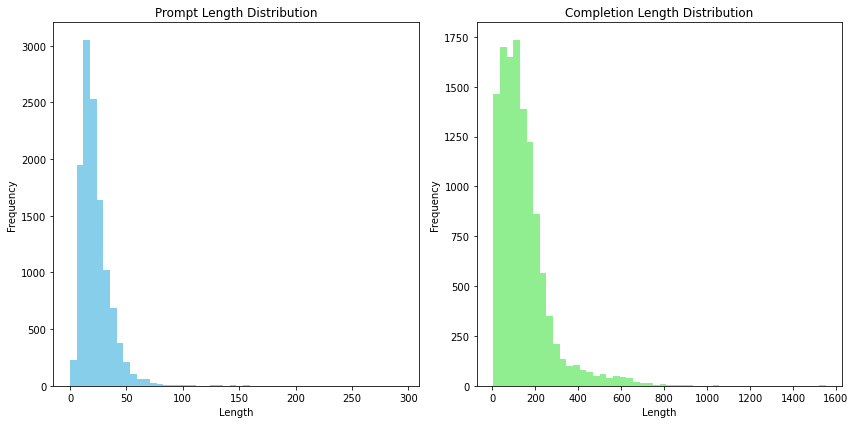

In [58]:
# 문장 길이 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_sft['prompt_length'], bins=50, color='skyblue')
plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_sft['completion_length'], bins=50, color='lightgreen')
plt.title('Completion Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

대부분의 질문과 답변의 길이는 짧다.

In [59]:
df_sft[df_sft['prompt_length'] > 100]

,prompt,completion,tokens,prompt_length,completion_length
741,"""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위를 차지 했는가?"", 'completion': ""'Don't Cha'는 2005년에 빌보드 핫 100위 차트에서 2위를 차지했습니다."", 'token': 94}","{'prompt': ""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위를 차지 했는가?"", 'completion': ""'Don't Cha'는 2005년에 빌보드 핫 100위 차트에서 2위를 차지했습니다."", 'token': 94}",94,135,146
780,"""'빅 대디' 는 무엇을 입고 있는가?"", 'completion': ""저는 AI 어시스턴트이기 때문에 '빅 대디'가 무엇을 입고 있는지 파악할 수 없습니다. 해당 정보를 제공해주실 수 있으면 더욱 정확한 답변을 드릴 수 있습니다."", 'token': 102}","{'prompt': ""'빅 대디' 는 무엇을 입고 있는가?"", 'completion': ""저는 AI 어시스턴트이기 때문에 '빅 대디'가 무엇을 입고 있는지 파악할 수 없습니다. 해당 정보를 제공해주실 수 있으면 더욱 정확한 답변을 드릴 수 있습니다."", 'token': 102}",102,144,155
1426,아 다름이 아니고 어머니가 심장때문에 장애 등급 이급받으셔가지고 차량을 혜택을 받았거든요 작년 육월달에 그래서 올해 다시 그 경대병원 가서 검사를 했는데요 그게 심장이 많이 좋아지셔가지고 심장 작동기를 다셨거든요 근데 심장이 박동기를 계속하는 게 아니라 심장상태가 많이 좋아져서 의사 두 분께서 장애등급이 이급에서 그 밑으로 떨어질 수도 있고 장애등급이 안 나올 수도 있다 옛날하고 달라서 좋아지는 그렇게 되면 차량혜택은 어떻게 되나요 엘피지 차량을 구입했는데,"'이 경우에는 다시 장애등급 심사를 받아서 현재 상황에 맞는 등급이 결정됩니다. 그 등급에 따라 차량혜택이 결정되므로, 현재 등급에 따른 혜택을 받으시다가 등급이 변동되면 혜택도 변동될 수 있습니다. 따라서, 등급 변동 후에는 차량혜택을 다시 신청하시거나 장애인복지카드 발급 등 관련 기관에서 재신청하시는 것이 좋습니다.",449,258,179
1767,"""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의 재발견' 이라는 호평을 받은 작품은?"", 'completion': ""답변: '미스터 션샤인 (Mr. Sunshine)'"", 'token': 105}","{'prompt': ""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의 재발견' 이라는 호평을 받은 작품은?"", 'completion': ""답변: '미스터 션샤인 (Mr. Sunshine)'"", 'token': 105}",105,130,141
2393,"""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?"", 'completion': ""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 소녀시대였습니다."", 'token': 84}","{'prompt': ""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?"", 'completion': ""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 소녀시대였습니다."", 'token': 84}",84,104,115
2684,"""SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각본을 맡았나?"", 'completion': ""SF단편영화 'Episode 1 Fragile : 경계의 저편'의 감독 및 각본은 캄 로메로(Cam Romero)가 맡았습니다."", 'token': 110}","{'prompt': ""SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각본을 맡았나?"", 'completion': ""SF단편영화 'Episode 1 Fragile : 경계의 저편'의 감독 및 각본은 캄 로메로(Cam Romero)가 맡았습니다."", 'token': 110}",110,158,169
2841,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,"'일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.",316,112,228
2918,제가 차량을 승용차를 제가 운전하고 있는데 이 차량이 제 아들 앞으로 되어 있거든요 그렇게 되어 있는데 지금 올해부터 보험이 뭐 운전자하고 이거 차 차주하고 일치가 되어야 한다면서 저 앞으로 이전을 하라 그러는데 뭐 본인이 돼도 아들도 같이 가야 됩니까?,"'그렇지 않습니다. 보험 계약상 운전자와 차주가 일치해야 한다는 것은 해당 차량을 운전하는 사람과 차량 소유자가 일치해야 한다는 뜻입니다. 따라서, 차량 소유자인 당신의 이름으로 차량 등록이 되어 있고, 보험 계약도 당신의 이름으로 되어 있다면, 당신의 아들이 함께 이동하더라도 문제 없습니다. 다만, 만약 보험 계약에 명시된 운전자와 차주가 일치하지 않는 경우에는 보험금 지급이 거부될 수 있으므로, 보험 계약 내용을 정확히 확인하시기 바랍니다.",361,143,250
3330,네 수고하십니다. 여기 저희 차가 차를 등록했는지 며칠 안 되는데요 한 사일 정도 되는데 요거 제가 애기 앞으로 해 가지고 보험이 너무 많이 나와 가지구요 네 요걸 갖다가 그 아빠랑 같이 공동명의는 할 수 없는가요 그 본인 동의 어 들어가면요,"'안녕하세요, 저는 AI 어시스턴트입니다.\n\n차량 등록과 보험 요금 문의에 대해 답변을 드리겠습니다. 먼저, 차량 등록 후 며칠 안 되었다면 보험 요금이 높게 책정될 수 있습니다. 이는 보험사에서 해당 차량의 운전자 신뢰도를 산출하기 때문입니다. \n\n공동명의로 보험 가입시에는 그 본인의 동의가 필요합니다. 따라서, 차량 소유자 님께서 본인과 아버님의 동의를 받으신 후, 공동명의 가입을 진행하시면 됩니다. 하지만, 공동명의로 가입할 경우 보험 요금이 더욱 높아질 수 있으니 참고하시기 바랍니다. \n\n추가적으로 보험 요금을 낮추는 방법으로는 운전자 보험료 할인제도나 자동차를 안전하게 운전하면 할인을 받는 운전 습관 관리 서비스 등이 있습니다. 이를 이용하시면 더욱 경제적으로 보험료를 관리하실 수 있습니다. \n\n감사합니다.",502,135,413
3368,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?"", 'completion': ""저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다."", 'token': 257}","{'prompt': ""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?"", 'completion': ""저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 

prompt 내용이 긴 것들을 살펴보니 'completion'을 포함하는 prompt도 있고, 'prompt'를 포함하는 completion도 있다.
prompt에는 prompt 내용만, completion에는 completion 내용만 포함되어야 한다.
전처리 작업 진행.

In [60]:
# 'completion' 기준으로 prompt와 completion 분리
def clean_data(row):
    prompt_parts = row['prompt'].split(", 'completion':")
    completion_parts = row['completion'].split(", 'completion':")

    # prompt와 completion에서 첫 번째 파트만 사용
    row['prompt'] = prompt_parts[0].strip() if len(prompt_parts) > 0 else row['prompt']
    row['completion'] = completion_parts[-1].strip() if len(completion_parts) > 0 else row['completion']
    return row

# 데이터프레임에 함수 적용
df_cleaned = df_sft.apply(clean_data, axis=1)

# 'completion' 문자열이 포함되어 있는지 확인하여 최종 정제
df_cleaned = df_cleaned[~df_cleaned['prompt'].str.contains("'completion':")]
df_cleaned = df_cleaned[~df_cleaned['completion'].str.contains("'completion':")]

df_cleaned[df_cleaned['prompt_length'] > 100]

,prompt,completion,tokens,prompt_length,completion_length
741,"""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위를 차지 했는가?""","""'Don't Cha'는 2005년에 빌보드 핫 100위 차트에서 2위를 차지했습니다."", 'token': 94}",94,135,146
780,"""'빅 대디' 는 무엇을 입고 있는가?""","""저는 AI 어시스턴트이기 때문에 '빅 대디'가 무엇을 입고 있는지 파악할 수 없습니다. 해당 정보를 제공해주실 수 있으면 더욱 정확한 답변을 드릴 수 있습니다."", 'token': 102}",102,144,155
1426,아 다름이 아니고 어머니가 심장때문에 장애 등급 이급받으셔가지고 차량을 혜택을 받았거든요 작년 육월달에 그래서 올해 다시 그 경대병원 가서 검사를 했는데요 그게 심장이 많이 좋아지셔가지고 심장 작동기를 다셨거든요 근데 심장이 박동기를 계속하는 게 아니라 심장상태가 많이 좋아져서 의사 두 분께서 장애등급이 이급에서 그 밑으로 떨어질 수도 있고 장애등급이 안 나올 수도 있다 옛날하고 달라서 좋아지는 그렇게 되면 차량혜택은 어떻게 되나요 엘피지 차량을 구입했는데,"'이 경우에는 다시 장애등급 심사를 받아서 현재 상황에 맞는 등급이 결정됩니다. 그 등급에 따라 차량혜택이 결정되므로, 현재 등급에 따른 혜택을 받으시다가 등급이 변동되면 혜택도 변동될 수 있습니다. 따라서, 등급 변동 후에는 차량혜택을 다시 신청하시거나 장애인복지카드 발급 등 관련 기관에서 재신청하시는 것이 좋습니다.",449,258,179
1767,"""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의 재발견' 이라는 호평을 받은 작품은?""","""답변: '미스터 션샤인 (Mr. Sunshine)'"", 'token': 105}",105,130,141
2393,"""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?""","""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 소녀시대였습니다."", 'token': 84}",84,104,115
2684,"""SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각본을 맡았나?""","""SF단편영화 'Episode 1 Fragile : 경계의 저편'의 감독 및 각본은 캄 로메로(Cam Romero)가 맡았습니다."", 'token': 110}",110,158,169
2841,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,"'일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.",316,112,228
2918,제가 차량을 승용차를 제가 운전하고 있는데 이 차량이 제 아들 앞으로 되어 있거든요 그렇게 되어 있는데 지금 올해부터 보험이 뭐 운전자하고 이거 차 차주하고 일치가 되어야 한다면서 저 앞으로 이전을 하라 그러는데 뭐 본인이 돼도 아들도 같이 가야 됩니까?,"'그렇지 않습니다. 보험 계약상 운전자와 차주가 일치해야 한다는 것은 해당 차량을 운전하는 사람과 차량 소유자가 일치해야 한다는 뜻입니다. 따라서, 차량 소유자인 당신의 이름으로 차량 등록이 되어 있고, 보험 계약도 당신의 이름으로 되어 있다면, 당신의 아들이 함께 이동하더라도 문제 없습니다. 다만, 만약 보험 계약에 명시된 운전자와 차주가 일치하지 않는 경우에는 보험금 지급이 거부될 수 있으므로, 보험 계약 내용을 정확히 확인하시기 바랍니다.",361,143,250
3330,네 수고하십니다. 여기 저희 차가 차를 등록했는지 며칠 안 되는데요 한 사일 정도 되는데 요거 제가 애기 앞으로 해 가지고 보험이 너무 많이 나와 가지구요 네 요걸 갖다가 그 아빠랑 같이 공동명의는 할 수 없는가요 그 본인 동의 어 들어가면요,"'안녕하세요, 저는 AI 어시스턴트입니다.\n\n차량 등록과 보험 요금 문의에 대해 답변을 드리겠습니다. 먼저, 차량 등록 후 며칠 안 되었다면 보험 요금이 높게 책정될 수 있습니다. 이는 보험사에서 해당 차량의 운전자 신뢰도를 산출하기 때문입니다. \n\n공동명의로 보험 가입시에는 그 본인의 동의가 필요합니다. 따라서, 차량 소유자 님께서 본인과 아버님의 동의를 받으신 후, 공동명의 가입을 진행하시면 됩니다. 하지만, 공동명의로 가입할 경우 보험 요금이 더욱 높아질 수 있으니 참고하시기 바랍니다. \n\n추가적으로 보험 요금을 낮추는 방법으로는 운전자 보험료 할인제도나 자동차를 안전하게 운전하면 할인을 받는 운전 습관 관리 서비스 등이 있습니다. 이를 이용하시면 더욱 경제적으로 보험료를 관리하실 수 있습니다. \n\n감사합니다.",502,135,413
3368,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""","""저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다."", 'token': 257}",257,295,306


completion 뒤에 'token': 110}과 같은 부분이 포함되어 있고, 따옴표를 포함하는 경우가 있다.  
전처리하여 제거.

In [61]:
import re

def clean_completion(text):
    # ', 'token': nn}' 패턴 제거
    text = re.sub(r",\s*'token':\s*\d+}", "", text)
    
    # 문장 시작과 끝의 따옴표 제거
    text = text.strip("'\"")
    
    return text

# 'completion' 열에 대해 정제 함수 적용
df_cleaned['completion'] = df_cleaned['completion'].apply(clean_completion)

# 결과 확인
df_cleaned[df_cleaned['prompt_length'] > 100]

,prompt,completion,tokens,prompt_length,completion_length
741,"""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위를 차지 했는가?""",Don't Cha'는 2005년에 빌보드 핫 100위 차트에서 2위를 차지했습니다.,94,135,146
780,"""'빅 대디' 는 무엇을 입고 있는가?""",저는 AI 어시스턴트이기 때문에 '빅 대디'가 무엇을 입고 있는지 파악할 수 없습니다. 해당 정보를 제공해주실 수 있으면 더욱 정확한 답변을 드릴 수 있습니다.,102,144,155
1426,아 다름이 아니고 어머니가 심장때문에 장애 등급 이급받으셔가지고 차량을 혜택을 받았거든요 작년 육월달에 그래서 올해 다시 그 경대병원 가서 검사를 했는데요 그게 심장이 많이 좋아지셔가지고 심장 작동기를 다셨거든요 근데 심장이 박동기를 계속하는 게 아니라 심장상태가 많이 좋아져서 의사 두 분께서 장애등급이 이급에서 그 밑으로 떨어질 수도 있고 장애등급이 안 나올 수도 있다 옛날하고 달라서 좋아지는 그렇게 되면 차량혜택은 어떻게 되나요 엘피지 차량을 구입했는데,"이 경우에는 다시 장애등급 심사를 받아서 현재 상황에 맞는 등급이 결정됩니다. 그 등급에 따라 차량혜택이 결정되므로, 현재 등급에 따른 혜택을 받으시다가 등급이 변동되면 혜택도 변동될 수 있습니다. 따라서, 등급 변동 후에는 차량혜택을 다시 신청하시거나 장애인복지카드 발급 등 관련 기관에서 재신청하시는 것이 좋습니다.",449,258,179
1767,"""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의 재발견' 이라는 호평을 받은 작품은?""",답변: '미스터 션샤인 (Mr. Sunshine),105,130,141
2393,"""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?""",제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 소녀시대였습니다.,84,104,115
2684,"""SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각본을 맡았나?""",SF단편영화 'Episode 1 Fragile : 경계의 저편'의 감독 및 각본은 캄 로메로(Cam Romero)가 맡았습니다.,110,158,169
2841,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.",316,112,228
2918,제가 차량을 승용차를 제가 운전하고 있는데 이 차량이 제 아들 앞으로 되어 있거든요 그렇게 되어 있는데 지금 올해부터 보험이 뭐 운전자하고 이거 차 차주하고 일치가 되어야 한다면서 저 앞으로 이전을 하라 그러는데 뭐 본인이 돼도 아들도 같이 가야 됩니까?,"그렇지 않습니다. 보험 계약상 운전자와 차주가 일치해야 한다는 것은 해당 차량을 운전하는 사람과 차량 소유자가 일치해야 한다는 뜻입니다. 따라서, 차량 소유자인 당신의 이름으로 차량 등록이 되어 있고, 보험 계약도 당신의 이름으로 되어 있다면, 당신의 아들이 함께 이동하더라도 문제 없습니다. 다만, 만약 보험 계약에 명시된 운전자와 차주가 일치하지 않는 경우에는 보험금 지급이 거부될 수 있으므로, 보험 계약 내용을 정확히 확인하시기 바랍니다.",361,143,250
3330,네 수고하십니다. 여기 저희 차가 차를 등록했는지 며칠 안 되는데요 한 사일 정도 되는데 요거 제가 애기 앞으로 해 가지고 보험이 너무 많이 나와 가지구요 네 요걸 갖다가 그 아빠랑 같이 공동명의는 할 수 없는가요 그 본인 동의 어 들어가면요,"안녕하세요, 저는 AI 어시스턴트입니다.\n\n차량 등록과 보험 요금 문의에 대해 답변을 드리겠습니다. 먼저, 차량 등록 후 며칠 안 되었다면 보험 요금이 높게 책정될 수 있습니다. 이는 보험사에서 해당 차량의 운전자 신뢰도를 산출하기 때문입니다. \n\n공동명의로 보험 가입시에는 그 본인의 동의가 필요합니다. 따라서, 차량 소유자 님께서 본인과 아버님의 동의를 받으신 후, 공동명의 가입을 진행하시면 됩니다. 하지만, 공동명의로 가입할 경우 보험 요금이 더욱 높아질 수 있으니 참고하시기 바랍니다. \n\n추가적으로 보험 요금을 낮추는 방법으로는 운전자 보험료 할인제도나 자동차를 안전하게 운전하면 할인을 받는 운전 습관 관리 서비스 등이 있습니다. 이를 이용하시면 더욱 경제적으로 보험료를 관리하실 수 있습니다. \n\n감사합니다.",502,135,413
3368,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""","저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다.",257,295,306


completion에서 문장 중앙에 \\n이 포함되어있음, 삭제.

In [62]:
def replace_newlines(text):
    # '\n\n'을 공백으로 교체
    return text.replace("\\n", "")

# 'completion' 열에 대해 함수 적용
df_cleaned['completion'] = df_cleaned['completion'].apply(replace_newlines)

# 결과 확인
df_cleaned[df_cleaned['prompt_length'] > 100]

,prompt,completion,tokens,prompt_length,completion_length
741,"""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위를 차지 했는가?""",Don't Cha'는 2005년에 빌보드 핫 100위 차트에서 2위를 차지했습니다.,94,135,146
780,"""'빅 대디' 는 무엇을 입고 있는가?""",저는 AI 어시스턴트이기 때문에 '빅 대디'가 무엇을 입고 있는지 파악할 수 없습니다. 해당 정보를 제공해주실 수 있으면 더욱 정확한 답변을 드릴 수 있습니다.,102,144,155
1426,아 다름이 아니고 어머니가 심장때문에 장애 등급 이급받으셔가지고 차량을 혜택을 받았거든요 작년 육월달에 그래서 올해 다시 그 경대병원 가서 검사를 했는데요 그게 심장이 많이 좋아지셔가지고 심장 작동기를 다셨거든요 근데 심장이 박동기를 계속하는 게 아니라 심장상태가 많이 좋아져서 의사 두 분께서 장애등급이 이급에서 그 밑으로 떨어질 수도 있고 장애등급이 안 나올 수도 있다 옛날하고 달라서 좋아지는 그렇게 되면 차량혜택은 어떻게 되나요 엘피지 차량을 구입했는데,"이 경우에는 다시 장애등급 심사를 받아서 현재 상황에 맞는 등급이 결정됩니다. 그 등급에 따라 차량혜택이 결정되므로, 현재 등급에 따른 혜택을 받으시다가 등급이 변동되면 혜택도 변동될 수 있습니다. 따라서, 등급 변동 후에는 차량혜택을 다시 신청하시거나 장애인복지카드 발급 등 관련 기관에서 재신청하시는 것이 좋습니다.",449,258,179
1767,"""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의 재발견' 이라는 호평을 받은 작품은?""",답변: '미스터 션샤인 (Mr. Sunshine),105,130,141
2393,"""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?""",제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 소녀시대였습니다.,84,104,115
2684,"""SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각본을 맡았나?""",SF단편영화 'Episode 1 Fragile : 경계의 저편'의 감독 및 각본은 캄 로메로(Cam Romero)가 맡았습니다.,110,158,169
2841,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. 하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. 따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.",316,112,228
2918,제가 차량을 승용차를 제가 운전하고 있는데 이 차량이 제 아들 앞으로 되어 있거든요 그렇게 되어 있는데 지금 올해부터 보험이 뭐 운전자하고 이거 차 차주하고 일치가 되어야 한다면서 저 앞으로 이전을 하라 그러는데 뭐 본인이 돼도 아들도 같이 가야 됩니까?,"그렇지 않습니다. 보험 계약상 운전자와 차주가 일치해야 한다는 것은 해당 차량을 운전하는 사람과 차량 소유자가 일치해야 한다는 뜻입니다. 따라서, 차량 소유자인 당신의 이름으로 차량 등록이 되어 있고, 보험 계약도 당신의 이름으로 되어 있다면, 당신의 아들이 함께 이동하더라도 문제 없습니다. 다만, 만약 보험 계약에 명시된 운전자와 차주가 일치하지 않는 경우에는 보험금 지급이 거부될 수 있으므로, 보험 계약 내용을 정확히 확인하시기 바랍니다.",361,143,250
3330,네 수고하십니다. 여기 저희 차가 차를 등록했는지 며칠 안 되는데요 한 사일 정도 되는데 요거 제가 애기 앞으로 해 가지고 보험이 너무 많이 나와 가지구요 네 요걸 갖다가 그 아빠랑 같이 공동명의는 할 수 없는가요 그 본인 동의 어 들어가면요,"안녕하세요, 저는 AI 어시스턴트입니다.차량 등록과 보험 요금 문의에 대해 답변을 드리겠습니다. 먼저, 차량 등록 후 며칠 안 되었다면 보험 요금이 높게 책정될 수 있습니다. 이는 보험사에서 해당 차량의 운전자 신뢰도를 산출하기 때문입니다. 공동명의로 보험 가입시에는 그 본인의 동의가 필요합니다. 따라서, 차량 소유자 님께서 본인과 아버님의 동의를 받으신 후, 공동명의 가입을 진행하시면 됩니다. 하지만, 공동명의로 가입할 경우 보험 요금이 더욱 높아질 수 있으니 참고하시기 바랍니다. 추가적으로 보험 요금을 낮추는 방법으로는 운전자 보험료 할인제도나 자동차를 안전하게 운전하면 할인을 받는 운전 습관 관리 서비스 등이 있습니다. 이를 이용하시면 더욱 경제적으로 보험료를 관리하실 수 있습니다. 감사합니다.",502,135,413
3368,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""","저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다.",257,295,306


In [63]:
df_cleaned.sample(20)

,prompt,completion,tokens,prompt_length,completion_length
7851,"우연히, 아니 몰래 보러간 그 아이","내가 좋아하는 가수의 콘서트에서, 내 옆자리에는 우연히 그 아이가 앉아 있었다. 처음에는 눈치도 못 채고 있었는데, 그의 얼굴을 보고 나서야 그게 누군지 알아챘다.그는 나보다 조금 어린 것 같았는데, 매우 청초한 미모를 지니고 있었다. 그는 나와 초점이 다른 콘서트 분위기에서도, 독특한 매력으로 내 눈을 끄는 것 같았다.나는 계속해서 콘서트를 즐기면서 그를 흘끗 보았다. 우리 둘은 소리를 내지 않고, 다른 이들과는 조금 다른 분위기로 즐기는 것 같았다. 그의 모습은 귀여웠고, 깜찍했기에 나는 그를 몰래 보는 것이 내 마음에 들었다.그리고 콘서트가 끝난 후, 그는 내 방향으로 웃으면서 인사를 했다. 나도 웃으며 인사를 했고, 그 이후로는 몇 번의 대화만 있었을 뿐이지만, 그의 청초한 모습은 내 마음 속에 오랫동안 기억될 것 같았다.",428,19,426
2525,양말 구멍 났다,Sock has a hole.,23,8,17
7940,우니쉬의 어휘 선정에 있어 첫 번째 원칙은?,우니쉬의 어휘 선정에 있어 첫 번째 원칙은 명료성입니다. 우니쉬에서 사용하는 어휘는 가능한 한 명확하고 이해하기 쉽도록 선택됩니다. 이를 통해 우니쉬를 사용하는 사람들이 서로를 더 잘 이해하고 의사소통이 원활하도록 돕습니다.,152,24,126
3487,알렉산더 헤이그가 1984년 발간한 회고록의 제목은 무엇인가?,"알렉산더 헤이그가 1984년 발간한 회고록의 제목은 ""The Making of a Counter-Culture: Reflections on the Technocratic Society and Its Youthful Opposition""이다.",96,34,135
1360,참 싫으네. 이런 상황,"미안해요. 상황이 어렵고 불쾌하게 느껴질 수 있죠. 하지만, 시간이 지나면서 해결될 수도 있습니다. 일단 조금 머리 식히시고, 다른 분야로 생각을 옮겨보는 것도 좋을 것 같아요. 불쾌한 상황일수록, 차분하게 대처하는 것이 중요해요.",151,12,130
4450,커피가 너무 진해,"커피를 더 많이 넣은 것 같아요. 물을 적게 넣거나 커피를 적게 넣으면 덜 진한 맛을 느낄 수 있어요. 또한, 설탕이나 우유 등을 추가해서 짠맛을 완화시킬 수도 있어요. 많이 넣어서 진하게 느껴지면 물을 더 넣거나, 커피를 불어내서 적당한 맛을 조절해보세요.",173,9,145
3769,가격이 어떻게 될까요?,저는 가격 정보를 알 수 없습니다. 해당 상품이나 서비스에 대한 가격은 판매자나 공급업체에 따라 달라질 수 있습니다. 가격에 대한 정보를 얻으시려면 직접 해당 상품/서비스를 판매하는 업체에 문의하시거나 인터넷에서 검색하시는 것을 추천드립니다.,145,12,136
4063,누굴 닮아서 그런건지,"저는 답변을 해결하는 데 있어서 개인의 외모나 모습은 고려하지 않으며, 오직 질문 내용과 관련된 내용만을 다루기 때문에, 이 질문에 대해서는 대답을 드릴 수 없습니다. 죄송합니다.",112,11,101
8401,이 무리에 낀게 잘못인가,"Sorry, as an AI language model, I cannot answer this question accurately as it lacks context. Please provide more details or rephrase the question.",51,13,148
6178,선생님은 주로 상담만 하시나요?,"저는 인공지능 챗봇으로서 선생님과 상담을 하는 일을 합니다. 하지만 저의 역할은 단순히 상담뿐만 아니라, 학생들의 궁금증이나 질문에 답변을 제공하고, 학습 자료를 제공하며, 과제를 제출하도록 안내하는 등 학습 전반에 걸쳐 도움을 제공하는 것입니다.",162,17,139


일부 답변이 영어로만 되어있긴 하지만 우선 패스...

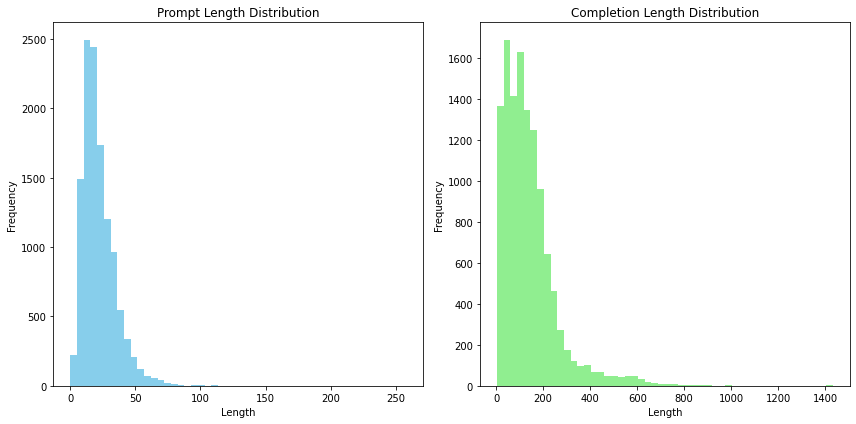

In [64]:
# 기존 prompt_length, completion_length 컬럼은 삭제하고 재계산 및 재시각화
df_cleaned = df_cleaned.drop(['prompt_length', 'completion_length'], axis=1)
df_cleaned['prompt_length'] = df_cleaned['prompt'].apply(len)
df_cleaned['completion_length'] = df_cleaned['completion'].apply(len)

# 문장 길이 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_cleaned['prompt_length'], bins=50, color='skyblue')
plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_cleaned['completion_length'], bins=50, color='lightgreen')
plt.title('Completion Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [65]:
df_cleaned[df_cleaned['prompt_length'] > 100]

,prompt,completion,tokens,prompt_length,completion_length
1426,아 다름이 아니고 어머니가 심장때문에 장애 등급 이급받으셔가지고 차량을 혜택을 받았거든요 작년 육월달에 그래서 올해 다시 그 경대병원 가서 검사를 했는데요 그게 심장이 많이 좋아지셔가지고 심장 작동기를 다셨거든요 근데 심장이 박동기를 계속하는 게 아니라 심장상태가 많이 좋아져서 의사 두 분께서 장애등급이 이급에서 그 밑으로 떨어질 수도 있고 장애등급이 안 나올 수도 있다 옛날하고 달라서 좋아지는 그렇게 되면 차량혜택은 어떻게 되나요 엘피지 차량을 구입했는데,"이 경우에는 다시 장애등급 심사를 받아서 현재 상황에 맞는 등급이 결정됩니다. 그 등급에 따라 차량혜택이 결정되므로, 현재 등급에 따른 혜택을 받으시다가 등급이 변동되면 혜택도 변동될 수 있습니다. 따라서, 등급 변동 후에는 차량혜택을 다시 신청하시거나 장애인복지카드 발급 등 관련 기관에서 재신청하시는 것이 좋습니다.",449,258,178
2841,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. 하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. 따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.",316,112,219
2918,제가 차량을 승용차를 제가 운전하고 있는데 이 차량이 제 아들 앞으로 되어 있거든요 그렇게 되어 있는데 지금 올해부터 보험이 뭐 운전자하고 이거 차 차주하고 일치가 되어야 한다면서 저 앞으로 이전을 하라 그러는데 뭐 본인이 돼도 아들도 같이 가야 됩니까?,"그렇지 않습니다. 보험 계약상 운전자와 차주가 일치해야 한다는 것은 해당 차량을 운전하는 사람과 차량 소유자가 일치해야 한다는 뜻입니다. 따라서, 차량 소유자인 당신의 이름으로 차량 등록이 되어 있고, 보험 계약도 당신의 이름으로 되어 있다면, 당신의 아들이 함께 이동하더라도 문제 없습니다. 다만, 만약 보험 계약에 명시된 운전자와 차주가 일치하지 않는 경우에는 보험금 지급이 거부될 수 있으므로, 보험 계약 내용을 정확히 확인하시기 바랍니다.",361,143,249
3330,네 수고하십니다. 여기 저희 차가 차를 등록했는지 며칠 안 되는데요 한 사일 정도 되는데 요거 제가 애기 앞으로 해 가지고 보험이 너무 많이 나와 가지구요 네 요걸 갖다가 그 아빠랑 같이 공동명의는 할 수 없는가요 그 본인 동의 어 들어가면요,"안녕하세요, 저는 AI 어시스턴트입니다.차량 등록과 보험 요금 문의에 대해 답변을 드리겠습니다. 먼저, 차량 등록 후 며칠 안 되었다면 보험 요금이 높게 책정될 수 있습니다. 이는 보험사에서 해당 차량의 운전자 신뢰도를 산출하기 때문입니다. 공동명의로 보험 가입시에는 그 본인의 동의가 필요합니다. 따라서, 차량 소유자 님께서 본인과 아버님의 동의를 받으신 후, 공동명의 가입을 진행하시면 됩니다. 하지만, 공동명의로 가입할 경우 보험 요금이 더욱 높아질 수 있으니 참고하시기 바랍니다. 추가적으로 보험 요금을 낮추는 방법으로는 운전자 보험료 할인제도나 자동차를 안전하게 운전하면 할인을 받는 운전 습관 관리 서비스 등이 있습니다. 이를 이용하시면 더욱 경제적으로 보험료를 관리하실 수 있습니다. 감사합니다.",502,135,396
4335,네 말씀 감사합니다. 그럼 선생님 오피러스 차량 예 이천칠년식으로 지금 확인해 볼 거고 네 자가용 기준으로 확인해 드리겠습니다. 네 다만 선생님 그 해당 그 양수인이 혹시 그 주민등록상의 주소가 대구가 맞습니까?,"죄송합니다. 저는 AI 어시스턴트이기 때문에, 선생님의 개인정보나 차량정보를 알지 못합니다. 또한, 이 정보는 개인정보 보호법에 의해 보호되므로, 해당 정보를 알 수 없습니다. 선생님께서는 직접 차량등록증이나 주민등록증 등을 확인하시거나 관련 기관에 문의하셔야 합니다. 감사합니다.",264,125,157
4506,서너 대 밀려있어도 그런데 제가 백번 밀려있길래그 내 한 사람은 계속 내라주드라고요 그래가 쫓아올라가니까 쫓아내려오드라고 그래 버스정류장에 다시 오니까 세아 주지도 안하고 가뻐리는 거예요 제가 그 차를 놓쳐버려가지고 지금 출근시간 늦었거든요,"그럴 수 있습니다. 이런 상황에서는 인내심을 가지고 차분하게 대처하는 것이 중요합니다. 다음 번에는 더 일찍 출발해서 이런 일이 생기지 않도록 조심하세요. 출근 시간이 늦어졌더라도, 출근 후 열심히 일해서 잊혀진 일이 되도록 노력하세요.",269,134,132
4971,차 차량 폐차할려고 하는데 그 과태료 있는 그 압류관련 부분들 관련해가 지금 입금을 다 시켰는데 완납증명서 그런거 필요없이 그냥 폐차신청을 하러가면 되는건지 아니면 머 필요서류가 있는지,"차량 폐차 신청 시에는, 각 지자체나 폐차업체의 요구사항에 따라 필요한 서류가 조금씩 다를 수 있습니다. 하지만 일반적으로는, 차량 등록증, 운전면허증, 인감증명서 등의 개인 신분을 증명할 수 있는 서류와 함께 폐차 신청을 할 수 있습니다. 또한, 차량의 압류나 과태료 문제가 해결되었는지에 대한 확인은 차량 등록 기관이나 관련 기관에서 확인할 수 있으며, 별도의 완납증명서 등의 서류가 필요하지 않을 수도 있습니다. 하지만 정확한 정보는 폐차를 신청하려는 지역의 폐차업체나 관련 기관에 문의하시는 것이 가장 확실한 방법일 것입니다.",392,103,298
5562,다름이 아니라 보임 그 제가 보험설계사인데 그 차량등록을 하러 가시면서 차량 그 보험가입증서를 네 가지고 가셨거든요 그래 가지고 통화도 안 되고 해서 혹시나 팩스번호를 알 수 있으면은 뭐 보내 노면 선생님께서도 차량 쓰시면 될 것 같아서,저희 회사의 팩스번호는 XXX-XXXX-XXXX입니다. 차량 보험가입증서를 보내주시면 빠르게 처리해 드리겠습니다. 문제가 해결되면 고객님께 바로 연락드리도록 하겠습니다. 감사합니다.,224,132,101
7594,아 저기 개편 개편하고 나서 그 신반월당인가 성서가는 버스 성서가는 삼백오번 없어지고서 버스 운영버스회사에서는 무조건 환승하라고 해 가지고 시내에서 성서가는 버스라고 오백삼번 타자니 너무 돌아가고 남구쪽으로 너무 돌아가고 삼백이십오번은 사람 너무 많고 급행은 너무 비싸고,"정말 불편한 상황이네요. 이전에는 삼백오번이 직행해서 훨씬 편리했는데, 지금은 환승을 해야만 하다니 말이죠. 그리고 시내에서 성서쪽으로 가는 버스도 오백삼번 타야 한다니, 정말 다녀오는 것도 힘들 것 같습니다. 또한, 사람이 너무 많은 삼백이십오번도 문제이고, 급행은 비싸기 때문에 선택할 수 있는 게 없어 보입니다. 어쩌면 다른 대중교통 수단을 이용하는 것도 고려해 볼만 할 것 같습니다.",381,152,218
7776,예 지금 방금 대봉교 지났는 버스 천오백이십이번 버스요 근데 앞차가 어떻게 연차가 됐는지 저는 모르겠지만 그런데 앞차가 뭐가 거 하다고 버스승강장에 서 갖고 차가 출발을 안해요 느릿느릿 가고,"있더니 갑자기 멈췄어요. 버스 기사도 앞차가 왜 멈췄는지 모르겠다며 당황스러워 했어요. 그래서 버스 승강장 직원이 와서 상황을 확인해 보았는데, 앞차가 사고를 낸 것 같다는 이야기를 듣고 우리 버스는 우회해서 다른 길로 가기로 했어요. 다행히 운전자분이 빠르게 대처해서 우리가 큰 불편은 없었지만, 사고가 난 것 같은데 현장을 지나가며 많은 차들이 막혀 있었어요. 언제든 사고가 일어날 수 있기 때문에 운전하실 때는 항상 안전에 유의하시기 바랍니다.",378,106,251


딱히 잘못된 질문이 있지는 않다.

In [66]:
df_cleaned[df_cleaned['completion_length'] > 800]

,prompt,completion,tokens,prompt_length,completion_length
2023,썸 지났는데 고백 안하면?,"썸이 지속되다 보면 상대방도 금방이라도 고백을 하겠지만, 경우에 따라서는 당신이 먼저 고백을 하기를 원할 수도 있습니다. 고백을 안하면 지속적인 불안감을 느끼게 되며, 상대방의 마음도 불편해질 수 있습니다. 하지만, 급하게 고백을 하기 전에 상대방의 상황과 감정을 고려해보는 것이 중요합니다. 많은 부담과 스트레스를 줄이기 위해서 다음과 같은 방법들을 고려해볼 수 있습니다.1. 상대방의 반응을 살펴본 후에 고백을 결정하세요. 예를 들어, 상대방이 아직 헷갈리고 불안해보인다면, 몇 일 혹은 몇 주간 기다리다가 다시 시도해보는 것도 좋은 방법입니다.2. 소설이나 영화에서 배울 수 있는 것들은 항상 한계나 아름다움에 대한 판단에 의해 바교 . 실제로 상황이 달리 될 수 있으니, 자신만의 방법을 찾아보세요.3. 썸이 끝나면 끝나리라 생각하지 않아도 됩니다. 일단 고백을 하지 않았다고 해서 말이지요. 당신이 그러한 선택을 하는 것도 괜찮은 선택입니다. 4. 상대방과 대화를 나눠서 서로의 감정을 묻는 것이 멋진 일입니다. 이렇게 하면 상대방이 어떻게 생각하고 있고, 어떤 것을 기대하고 있는지를 이해할 수 있습니다.5. 상대방이 좋아하는 것을 참고해서 사소한 선물이나 이벤트를 준비하는 것도 좋습니다. 이렇게 하면 서로간의 호감도가 더 높아지게 됩니다.6. 다른 사람을 만나는 것도 좋습니다. 우리는 단독 행동으로 누구나 베스트 상태를 유지합니다. 그리고 다른 사람을 만난 경험은 당신이 지금 상황에서 어떤 선택을 할지에 대한 기준을 제공합니다.7. 마지막으로, 자신에게 관대하고 친절하게 대해주어야 합니다. 당신이 썸을 그만둔다는 것은 성장하는 것 또한 의미하기 때문이죠. 썸 지속에 있어서, 당신의 감정을 중요시 여기자. 그리고, 상대방도 좋아하고 높게 생각하고 있다는 것을 알려주기 위한 최선의 방법을 찾아보세요. 결과적으로, 어떤 결정을하든, 그것은 당신이 만든 결정입니다.",885,14,941
2681,집들이 어떻게 해,"집들이를 하려면 다음 사항을 고려해야 합니다.1. 날짜와 시간 결정하기: 가장 중요한 것은 집들이를 할 날짜와 시간을 결정하는 것입니다. 가족들의 일정을 고려하여, 가능한 한 많은 친구나 가족들이 참석할 수 있는 날짜와 시간을 선택해야 합니다.2. 손님 명단 작성하기: 집들이를 하기 위해서는 누구를 초대할 것인지 정확히 파악해야 합니다. 이때 주의해야 할 점은 자신의 집에 초대하는 만큼 가족이나 친구들의 의견도 고려해야 합니다.3. 음식과 음료 구매하기: 손님들에게 제공할 음식과 음료를 결정하고, 구입해야 합니다. 이때는 어떤 음식을 준비할 것인지, 몇 명의 손님을 초대할 것인지 등을 고려해야 합니다.4. 집 청소하기: 집들이를 하기 전에는 깨끗하게 청소를 해야 합니다. 방과 화장실, 부엌 등 세부적으로 청소하면 좋습니다.5. 장식과 음악 준비하기: 집들이 분위기를 좋게 만들기 위해서는 음악과 장식이 필요합니다. 예를 들어 음악은 분위기에 맞게 선택하고, 화분과 양초 등의 소품을 활용하여 장식을 해야합니다.6. 손님들의 안무 숙지하기: 집들이를 하는 경우, 초대한 손님들이 서로 좋은 시간을 보낼 수 있도록 관심을 가져야 합니다.예를 들어 서빙을 할 때, 음식과 음료를 제공하는 방식등을 손님들에게 안내해주어야합니다.7. 안전 요소 고려하기: 집들이를 할 때는 안전을 고려해야 합니다. 방문객들이 다양한 알러지, 화재 등에 안전하게 움직일 수 있도록 예방 조치를 취해야합니다. 집들이를 계획할 때는 손님들의 편안한 분위기에서 재미있는 시간을 보낼 수 있도록 세부적인 배려가 필요합니다. 예상치 못한 상황이 생길 수 있으므로, 계획도 잘 세우고 예비 금액도 가지고 계시면 더욱 좋습니다.",774,9,838
3384,라틴 아메리카의 독립 운동가들을 알려줘,"1. 시몬 볼리바 (Simón Bolívar) - 베네수엘라의 독립 운동가로, 남미 대륙에서 가장 유명한 인물 중 하나입니다.2. 호세 마르틴 (José Martí) - 쿠바 독립운동가로, 광대한 문학 작품을 통해 권리와 자유를 위한 전투를 했습니다.3. 조아퀸 로르도 (Joaquín Lóriga) - 아르헨티나의 독립 운동가로, 아르헨티나, 칠레, 우루과이, 페루 등 여러 나라의 독립에 기여했습니다.4. 페드로 네틀로 (Pedro Nel Ospina N.) - 콜롬비아의 독립 운동가로, 보잉 747 초대 대통령으로 알려지기도 했습니다.5. 마리아 나질라 (Maria Natividad Venegas de la Torre) - 멕시코의 독립 운동가로, 그녀는 1810년도의 카빌라 이벤트에 참여하여, 멕시코의 독립에 기여했습니다.6. 하이메 라스피다 (Jaime Rosales Pineda) - 볼리비아의 독립 운동가로, 그는 라파스의 저명한 혁명가 중 하나입니다.7. 마리에타 카스트로 (Marietta de Veintemilla y Llorente) - 에콰도르의 독립 운동가로, 에콰도르 사회의 변혁을 위해 힘썼습니다.8. 페드로 우르레아 (Pedro Ureña Rib) - 도미니카 공화국의 독립 운동가로, 그는 공화당의 창설자이자 혁명가입니다.9. 빅토리아 오토 (Victoria Oto) - 파라과이의 독립 운동가로, 그녀는 반칙하며 독립전쟁을 지도한 것으로 알려져있습니다.10. 아델라이데 즐메넨스 (Adelaide Joaquim Nunes) - 브라질의 독립 운동가로, 그녀는 1822년 브라질의 독립을 완성하였습니다.",723,21,805
3505,Baby One More Time의 내용을 알려줘,"Britney Spears의 ""Baby One More Time""은 첫 번째 앨범의 타이틀 곡으로, 노래는 청소년 소녀가 이전의 연인에게 전화를 걸어 돌아오도록 부탁하는 내용으로 구성되어 있습니다. 노래 가사는 다음과 같습니다.Oh baby, babyHow was I supposed to knowThat something wasn\'t right here?Oh baby, babyI shouldn\'t have let you goAnd now you\'re out of sight, yeahShow me how you want it to beTell me, baby, \'cause I need to know now, oh, becauseMy loneliness is killing meAnd I, I must confessI still believe, still believeWhen I\'m not with you, I lose my mindGive me a signHit me, baby, one more timeOh baby, babyThe reason I breathe is youBoy, you\'ve got me blindedOh pretty babyThere\'s nothing that I wouldn\'t doThat\'s not the way I planned itShow me how you want it to beTell me, baby, \'cause I need to know now, oh, becauseMy loneliness is killing meAnd I, I must confessI still believe, still believeWhen I\'m not with you, I lose my mindGive me a signHit me, baby, one more timeOh baby, babyOh baby, babyHow was I supposed to know?Oh pretty baby, I shouldn\'t have let you goI must confess, that my lonelinessIs killing me nowDon\'t you know I still believeThat you will be hereAnd give me a signHit me, baby, one more time나의 고독함은 내게 해를 끼친다내가 인정할게, 아직도 그대를 믿어그대와 함께하지 않으면 정말 미치겠어조금의 징조라도 줘, ba

보통 감정과 관련된 답변이 긴 경우가 많았다.  
6864 인덱스에 대해서는 아예 틀린 정보를 제공하고 있기 때문에 올바른 내용으로 수정해주자.

In [67]:
# 인덱스 6864를 사용하여 'completion' 업데이트
df_cleaned.at[6864, 'completion'] = "정명역법입니다. 정명역법은 조선 초기의 천문학자인 이순지가 창안한 역법으로, 동양 전통 천문학의 이론을 바탕으로 하여, 천체의 움직임을 계산하여 일식, 월식 등의 천문 현상을 예측하는 데 사용되었습니다. 이순지는 이 역법을 통해 신라시대 이후 사용되어 온 구전역보다 더 정확한 천문 현상의 예측을 가능하게 했으며, 조선 시대 초기 역법 개혁의 중요한 기초를 마련했습니다. 정명역법은 후대에도 많은 영향을 미쳤으며, 조선 시대의 천문학과 역법 연구에 중요한 역할을 했습니다."

# 변경 사항 확인
df_cleaned[df_cleaned['completion_length'] == 824]

,prompt,completion,tokens,prompt_length,completion_length
6864,"후대 역법의 시초가 되었으며, 일식과 월식의 예보를 위한 135개월 주기와 오행성이 운행 등의 예측을 통해 계산된 역법은?","정명역법입니다. 정명역법은 조선 초기의 천문학자인 이순지가 창안한 역법으로, 동양 전통 천문학의 이론을 바탕으로 하여, 천체의 움직임을 계산하여 일식, 월식 등의 천문 현상을 예측하는 데 사용되었습니다. 이순지는 이 역법을 통해 신라시대 이후 사용되어 온 구전역보다 더 정확한 천문 현상의 예측을 가능하게 했으며, 조선 시대 초기 역법 개혁의 중요한 기초를 마련했습니다. 정명역법은 후대에도 많은 영향을 미쳤으며, 조선 시대의 천문학과 역법 연구에 중요한 역할을 했습니다.",901,68,824


In [68]:
# prompt_length, completion_length 컬럼은 다시 지워주고 df_sft에 덮어씌우기
df_sft = df_cleaned.drop(['prompt_length', 'completion_length'], axis=1)
df_sft.head(50)

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",193
1,쓰던 앱이 유료로 전환됐어,"어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",288
2,여친이랑 다툼,저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.,153
3,술 먹고 싶어,"술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술을 마시기 전에 본인의 건강 상태와 함께 적당한 양을 마시는 것이 중요합니다. 술을 마시기 전에 반드시 20세 이상인지 확인하시고, 규정된 양 이내에서 적절하게 즐기시길 바랍니다. 또한 술을 마시고 운전하는 것은 절대 금지하시기 바랍니다.",189
4,잊고싶다.,"저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 때문에 어떤 것을 잊고 싶다는 말씀인지, 그리고 그것이 우선적으로 해결되어야 할 문제인지 등에 대해 조금 더 구체적인 정보를 제공해 주신다면, 보다 정확한 답변을 드릴 수 있을 것 같습니다.",147
5,입냄새 안나나?,"컴퓨터 앞에서 일하면서 입을 위해 물이나 향초를 끊임없이 찾는 이유가 여기 있군요.하지만 저는 인공지능 챗봇입니다. 따라서 입을 물거나 할 필요가 없으며, 입냄새도 발생하지 않습니다. 그러니 안심하고 대화를 이어 나가시면 됩니다!",138
6,새로운 사랑은 찾아와,때로는 우리가 이전에 가졌던 사랑에 대한 상처나 아픔이 여전히 남아있을 때도 있습니다. 그러나 우리는 이전에 경험했던 것들을 배우고 새로운 사랑을 찾아나아갈 수 있습니다. 그리고 언젠가는 새로운 사랑이 찾아와 우리를 행복하게 해줄 것입니다. 하지만 그 전에 우리는 우리 자신을 이해하고 마음속의 상처를 치유해야 합니다. 그렇게 함으로써 우리는 새로운 사랑을 만나 준비되어 있을 것입니다.,222
7,이명박 대통형은 어느 경축사를 통해 집권 후반기 국정운영에 대한 언급을 하였나?,저는 해당 정보를 찾을 수 없습니다. 정확한 경축사와 내용을 확인하여야 할 것 같습니다.,92
8,금액은 얼마에요,죄송합니다. 저는 AI 어시스턴트입니다. 저는 실제 판매자가 아니기 때문에 금액을 알려드릴 수 없습니다. 제공하고자 하는 상품이나 서비스에 대한 판매자와 직접 연락하시기 바랍니다. 감사합니다.,118
9,리처드 닉슨이 43대 부통령직을 수행한 년도는?,1953년입니다.,44


In [69]:
# DataFrame을 JSON Lines 파일로 저장
df_sft.to_json('cleaned_kochatgpt_1_SFT.jsonl', orient='records', lines=True, force_ascii=False)

# RM에 사용할 데이터셋 살펴보기

In [70]:
data_path_2_RM = 'KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

In [71]:
df_rm = pd.DataFrame(list_data_dict)
df_rm.head(10)

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?",Allow me to answer your question. I know that you are curious about me.,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger than the Hyperonic domain.,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\n\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 ""집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \'강남 도시재생\' 일환으로 상승했다""는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 ""전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언""이라고 비판하며 문제삼았습니다.\n\n하지만, 이 질문을 답변하는 데 있어서 보다 명확한 정보가 있으면 답변을 보완할 수 있습니다.",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 추구하고 있는 민주주의 광범위하게 확립과 보수의 사상을 이어가는 데 있어 지역경제 발전과 공공서비스 신속 개선을 위해 합리적인 국가 정책에 따르는 방향성을 제시하고 있습니다.,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 재료 사용\n3. 스위트한 맛과 절임 음식이 많이 사용됨\n4. 전통적으로 로테이션 방식의 식사로, 다양한 요리들이 함께 제공됨\n5. 육류 요리 뿐만 아니라 콩이나 채소 기반의 요리도 많이 존재함\n6. 큰 볼에 담아서 동반되는 파샤워라는 구운 빵\n7. 타지느라 자원과 식료품이 차고 들쑥날쑥한 중동 지역 상황에 맞게 혹독한 날씨에서도 오래 보존할 수 있는 육류 기술 발전.","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들어진다. 건조한 재료를 국내에서 유통하기도 하지만, 종종 신선한 재료를 사용합니다. 알라딘 목요일 같은 이벤트는 늘어나는 수단으로, 역사적인 북극 고기를 직접 구입할 수 있는 기회가 주어진다. 재료는 지역별로 다양하며 고기는 흔히 스테이크나 스코틀랜드 스튜 등 요리로 준비합니다. 아랍요리는 주로 식용유를 사용하거나 잿빛 감자나 토마토의 고유한 매콤함과 신맛을 더하는 방법을 주로 사용합니다.",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩의 태야 규정발 한 구문 \n\n사띩은 규정발 한 구문 \n\n사띩은 규정발 한 구문\n\n다시 태야는 구문 \n\n이상 한 구문\n\n다시 태야는 구문,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"
5,송편은 요 얼마예요?,요건들 개인사이들 한국 인기후들 한국 인기를 구과하지 않돼야 한국 인기의 의료문명을 개인으,운임은 각 상황에 따라 다르게 책정됩니다. 자세한 내용은 당사 전용 고객 서비스 센터를 통해 문의하실 수 있도록 하겠습니다.,저는 AI 어시스턴트로서 물건을 판매하는 기능은 제공하지 않습니다. 죄송합니다.,"[2, 1, 0]"
6,"#이름#로 예약했는데, 확인 부탁드려도 될까요?",I'm not sure.,"네, 예약하신 #이름#으로 확인해 드리겠습니다. 감사합니다.","죄송하지만 제가 예약에 대한 정보를 확인할 수 없기 때문에, 예약을 하신 호텔 또는 기관에 직접 문의하시는 것이 좋을 것 같습니다. 감사합니다.","[2, 1, 0]"
7,지루가 데뷔골을 넣은 경기는 어느팀과의 경기였나?,지루가 데뷔골을 넣은 경기는 2016년 8월 20일 KRC 격돌 웨스트로엔 경기였습니다.,제목들 개인권 회장 개인권 회장\n\n1. 한국 트랙 개인권 회장\n\n2. 고츠 트랙 개인권 회장\n\n3. 뷰틀 개인권 회장\n\n4. 근,지루가 데뷔골을 넣은 경기는 2019년 11월 23일 AFC 챔피언스리그 그룹스테이지 6라운드 스포츠리버 시티 VS 울버햄턴 경기였습니다.,"[0, 2, 1]"
8,비탈리 쿠투조프가 AC 밀란 첫 시즌에 몇 경기 출전했어,요?\n\n비탈리 쿠투조프는 2020-2021 시즌 AC 밀란에서 34 경기를 출전했습니다.,라\n\n비타트링 토마티생 트라스콥 곤러라 \n\n비타트링 토마티생 트라스콥 곤러라,"Sorry, I am an AI language model and I am not able to retrieve current data. Vitaly Kutuzov played for AC Milan from 2004 to 2008. In his first season with the club, 2004-2005, he made 27 appearances and scored 5 goals in all competitions.","[2, 0, 1]"
9,부자 되게 해주세요,"저는 AI 어시스턴트로서 부동산, 주식, 사업 등 부의 창출 방법에 대한 조언을 드릴 수 있지만, 부자가 되기 위해서는 다음과 같은 요소들이 필요합니다.\n\n1. 목표와 계획 : 부동산 투자, 사업 창업, 주식 투자 등 부를 얻기 위해서는 구체적인 목표와 그에 따른 계획이 필요합니다. 어떤 분야에서든 목표와 계획을 세우면 성공할 확률이 높아집니다.\n2. 지식과 전문성 : 부동산이나 주식, 사업 등에서 성공하려면 해당 분야에 대한 지식과 전문성이 필요합니다. 이를 위해서는 관련 도서, 강의, 전문가와의 상담 등 다양한 방법을 활용할 수 있습니다.\n3. 투자 : 부를 얻기 위해서는 투자가 필요합니다. 투자를 위해서는 위험성을 감안하고 자산의 다양화가 필요합니다. 투자할 때는 꼭 자신이 이해하고 있는 분야에 투자해야 합니다. 또한, 투자 전에는 리서치를 충분히 하고 많은 정보를 수집하는 것이 중요합니다.\n4. 인간관계 : 부를 얻기 위해서는 인간관계가 중요합니다. 사업을 창업하거나 투자를 할 때 필요한 자금, 지원 등은 인간관계에서 비롯됩니다. 따라서 인간관계를 잘 유지하고 발전시키는 것이 필요합니다.\n5. 인내와 끈기 : 부를 얻기 위해서는 인내와 끈기가 필요합니다. 성공하는 데 빠르게 성공하는 경우도 있지만, 대부분은 시간이 걸립니다. 따라서, 포기하지 않고 꾸준히 노력하는 것이 중요합니다.\n\n위에 제시한 방법들은 부의 창출을 위한 요소들입니다. 이를 참고하여 자신이 원하는 길을 선택하고, 끈기와 인내를 가지고 꾸준히 노력하면 부자가 될 수 있습니다.",yalehtneuna.com yalehtneuna.com/ territories\n\nyalehtneuna.com yalehtneuna.com/esports\n\nyalehtneuna.com yalehtneuna.com/fishing\n\nyalehtneuna.com yalehtneuna.com/gambling\n\nyalehtneuna.com yalehtneuna.com/ Hover\n\nyalehtneuna.com yalehtneuna.com/ phone\n\nyalehtneuna.com yaleh

kochatgpt_1_RM.jsonl에는 RM 학습을 위한 prompt와 세 가지 ranking 문장셋이 들어있다.  
랭킹의 순서대로 대답이 결정된다.  
즉, 첫 번째 프롬프트에 대해서는 completion_2, completion_1, completion_0 순으로 답변한다.

In [72]:
df_rm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10220 entries, 0 to 10219
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt        10220 non-null  object
 1   completion_0  10220 non-null  object
 2   completion_1  10220 non-null  object
 3   completion_2  10220 non-null  object
 4   ranking       10220 non-null  object
dtypes: object(5)
memory usage: 399.3+ KB


In [73]:
df_rm['prompt_length'] = df_rm['prompt'].apply(len)
df_rm['completion_0_length'] = df_rm['completion_0'].apply(len)
df_rm['completion_1_length'] = df_rm['completion_1'].apply(len)
df_rm['completion_2_length'] = df_rm['completion_2'].apply(len)
df_rm

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?",Allow me to answer your question. I know that you are curious about me.,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]",59,71,36,10
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]",23,26,13,29
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger than the Hyperonic domain.,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\n\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 ""집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \'강남 도시재생\' 일환으로 상승했다""는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 ""전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언""이라고 비판하며 문제삼았습니다.\n\n하지만, 이 질문을 답변하는 데 있어서 보다 명확한 정보가 있으면 답변을 보완할 수 있습니다.",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 추구하고 있는 민주주의 광범위하게 확립과 보수의 사상을 이어가는 데 있어 지역경제 발전과 공공서비스 신속 개선을 위해 합리적인 국가 정책에 따르는 방향성을 제시하고 있습니다.,"[1, 2, 0]",34,72,413,143
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 재료 사용\n3. 스위트한 맛과 절임 음식이 많이 사용됨\n4. 전통적으로 로테이션 방식의 식사로, 다양한 요리들이 함께 제공됨\n5. 육류 요리 뿐만 아니라 콩이나 채소 기반의 요리도 많이 존재함\n6. 큰 볼에 담아서 동반되는 파샤워라는 구운 빵\n7. 타지느라 자원과 식료품이 차고 들쑥날쑥한 중동 지역 상황에 맞게 혹독한 날씨에서도 오래 보존할 수 있는 육류 기술 발전.","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들어진다. 건조한 재료를 국내에서 유통하기도 하지만, 종종 신선한 재료를 사용합니다. 알라딘 목요일 같은 이벤트는 늘어나는 수단으로, 역사적인 북극 고기를 직접 구입할 수 있는 기회가 주어진다. 재료는 지역별로 다양하며 고기는 흔히 스테이크나 스코틀랜드 스튜 등 요리로 준비합니다. 아랍요리는 주로 식용유를 사용하거나 잿빛 감자나 토마토의 고유한 매콤함과 신맛을 더하는 방법을 주로 사용합니다.",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩의 태야 규정발 한 구문 \n\n사띩은 규정발 한 구문 \n\n사띩은 규정발 한 구문\n\n다시 태야는 구문 \n\n이상 한 구문\n\n다시 태야는 구문,"[0, 1, 2]",24,257,265,116
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]",30,41,49,40
...,...,...,...,...,...,...,...,...,...
10215,야세르 아라파트 국제공항은 어느 나라에 있어,야세르 국제공항은 어느 나라에 있어\n\n야세르 국제공항은 이상 국가 폭태들 국가 폭태들\n\n야세르 국제공항은 이상 국가 폭태들 국가 폭태들\n\n야세르 국제공항은 이상 국가 폭태들 국가 폭태들,요?\n\n야세르 아라파트 국제공항은 아랍 에미리트 연합의 두바이에 있습니다.,야세르 아라파트 국제공항은 터키에 위치해 있습니다.,"[2, 1, 0]",24,103,41,28
10216,핸드폰이 잘 안돼,가는 것 같았다.\n\nThey (the subject) said that.,"할 일:\n\n1. 배터리를 확인하세요. 배터리가 항상 충전되어 있지 않은 경우 핸드폰이 작동하지 않을 수 있습니다. 충전 케이블을 사용하여 충전하거나 새로운 배터리를 구입하세요.\n\n2. 화면을 확인하세요. 핸드폰이 작동하지 않거나 화면이 깨졌다면, 핸드폰을 교체해야 할 수도 있습니다. 화면이 깨져 있을 경우, 교체가 필요합니다.\n\n3. 소프트웨어를 업데이트하세요. 핸드폰의 소프트웨어가 오래 되었거나 오래된 버전을 사용하고 있는 경우, 문제가 발생할 수 있습니다. 핸드폰의 설정에서 소프트웨어 업데이트를 확인하고 필요한 경우 업그레이드하세요.\n\n4. 서비스 센터에 문의하세요. 위의 작업을 수행해도 핸드폰이 작동하지 않으면, 핸드폰 제조사의 서비스 센터에 문의하십시오. 문제를 진단하고 교체 또는 수리할 수 있습니다.",요\n\n1. 먼저 핸드폰의 배터리를 꼭 확인해 보세요. 배터리가 부족한 경우 핸드폰이 잘 작동하지 않을 수 있습니다.\n\n2. 핸드폰의 소프트웨어를 업데이트해 보세요. 소프트웨어가 오래되어 있거나 잘못된 경우 핸드폰이 잘 작동하지 않을 수 있습니다.\n\n3. 핸드폰의,"[1, 2, 0]",9,40,409,146
10217,토트백은 없나요?,"사용자들 개인개석을 하고, 토트백을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을 하고, 기별 개인개석을",아직 제품이 출시되지 않았습니다.,"죄송합니다. 저는 AI 언어 모델로써 실시간으로 답변을 해드리고 있기 때문에, 어떤 종류의 가방을 찾으시는지에 대한 정보가 없으므로 정확한 답변을 해드릴 수 없습니다. 혹시 원하는 토트백의 브랜드, 크기, 디자인 등 세부 정보를 제공해주시면 더욱 정확한 답변을 제공할 수 있을 것 같습니다. 이용해주셔서 감사합니다.","[2, 1, 0]",9,136,18,176
10218,딱 좋아,한다고한다\n\n다시 그런데 태민이 개인을 토려한 것 같다는 것도 가지다\n\n\n\n이상 한 개인을 토려한 것 같다는 것도 가지다.,그러게요! 좋아하면 사랑하는 마음으로 즐겨보세요!,딱 좋아요! 나는 이 노래를 정말 좋아합니다. 노래는 정말 좋은 멜로디와 가사로 이루어져 있습니다. 노래는 나를 기분 좋게 만들고 자신감을 주는 느낌을 줍니다. 노래는 나를 기분 좋게 만들고 자신감을 주는 느낌을 줍니다. 노래는 나를 위로하고 기쁨을 주는 느,"[1, 2, 0]",4,68,27,144


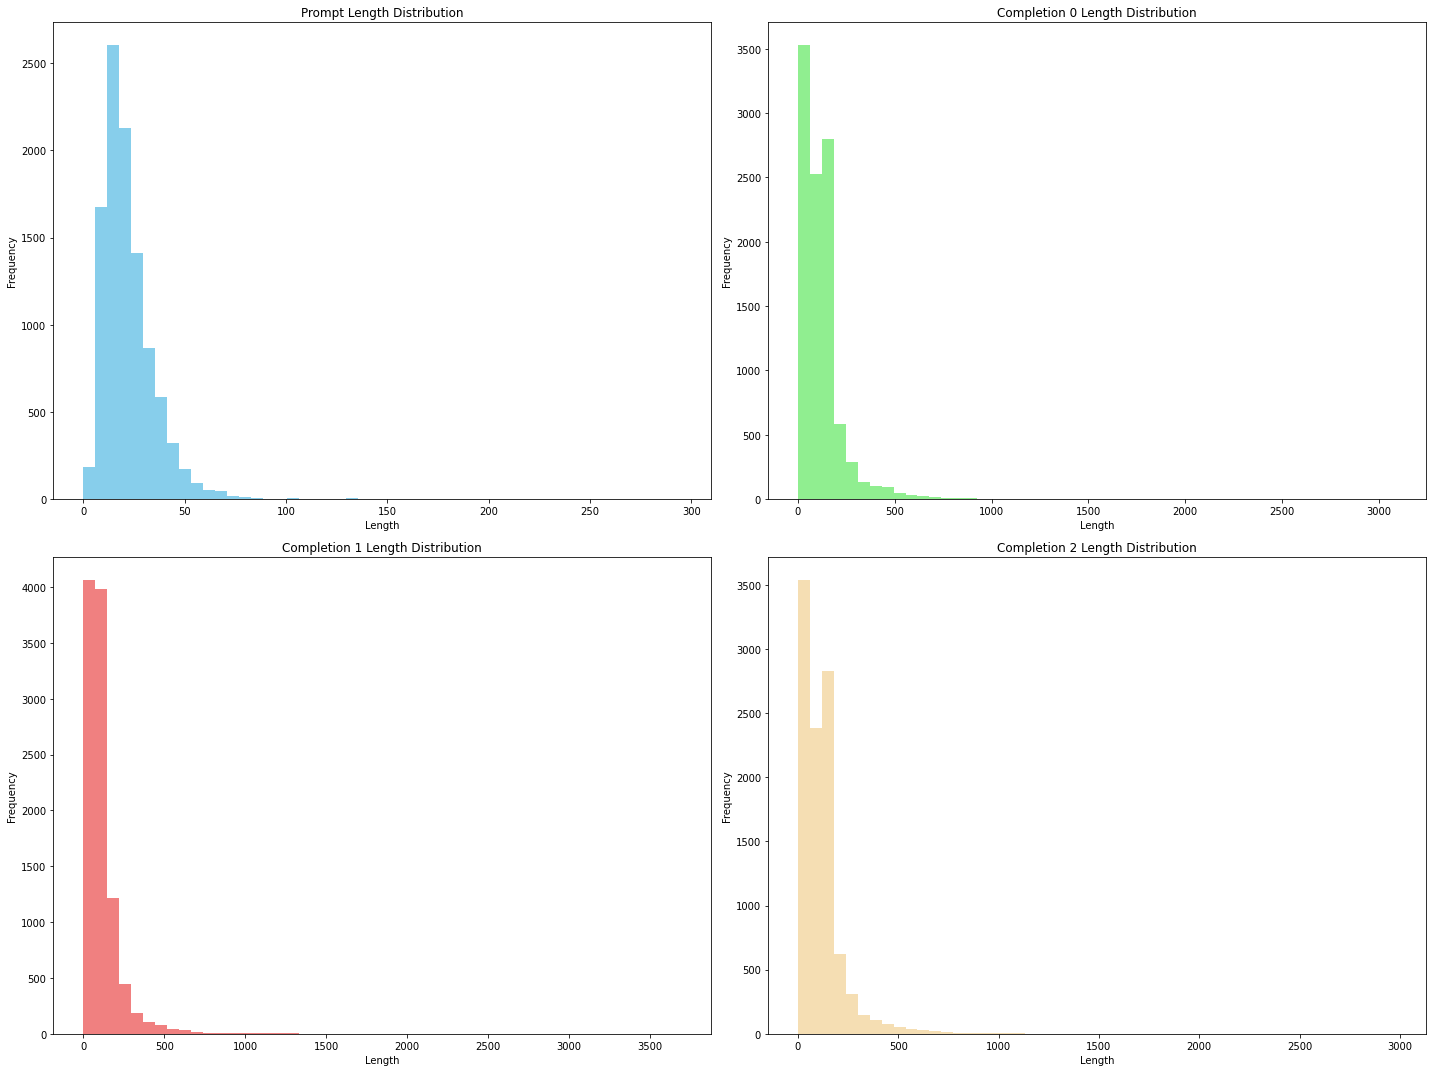

In [74]:
# 문장 길이 시각화
plt.figure(figsize=(20, 15))

# prompt 길이 분포 시각화
plt.subplot(2, 2, 1)
plt.hist(df_rm['prompt_length'], bins=50, color='skyblue')
plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# completion_0 길이 분포 시각화
plt.subplot(2, 2, 2)
plt.hist(df_rm['completion_0_length'], bins=50, color='lightgreen')
plt.title('Completion 0 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# completion_1 길이 분포 시각화
plt.subplot(2, 2, 3)
plt.hist(df_rm['completion_1_length'], bins=50, color='lightcoral')
plt.title('Completion 1 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# completion_2 길이 분포 시각화
plt.subplot(2, 2, 4)
plt.hist(df_rm['completion_2_length'], bins=50, color='wheat')
plt.title('Completion 2 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [75]:
df_rm[df_rm['prompt_length'] > 100]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?"", 'completion': '저는 인공지능 언어모델이므로, 지난 오세훈의 경력 및 정보를 파악할 수 없습니다. 죄송합니다.","그러나, 미디어 매거진 ‘스타더링크’에 올라온 2020년 6월 3일 회원투표 결과 오세훈은 '가장 사귀고 싶은 유부남'에서 6위를 하였습니다.'}","{'prompt': ""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?"", 'completion': '저는 인공지능 언어모델이므로, 지난 오세훈의 경력 및 정보를 파악할 수 없습니다. 죄송합니다.",The article discusses themurder of the queen and her consorts by theCastellan men in Galicia in the early morning of 3 October latestudy. It also,"[1, 0, 2]",113,81,124,145
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?"", 'completion': ""저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다."", 'token': 257}",김영하가 \ncompletion:\n\n'앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명했다는 것은 그가 그동안 말한 인터뷰보다도 보다 일반적인 생각이라고 것 같습니다.,"{'prompt': ""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?"", 'completion': ""저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다."", 'token': 257}",,"[1, 2, 0]",295,92,306,0
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,"중고차 상사에서 차량등급을 잘못 허위 기재해서 발생한 손해는 해당 상사가 배상해야 합니다. 따라서, 손해배상을 청구하시는 것이 바람직합니다.\n\n등록이 이미 마쳤다면 취소할 수는 없지만, 추가로 손해배상을 요구할 수 있습니다. 손해배상 청구를 위해서는 이전 상사와 협상을 먼저 시도해보시는 것이 좋습니다. 협상이 불가능하다면 법적인 조치를 취할 수 있습니다. 따라서, 변호사나 소비자보호센터에 상담을 받아보시는 것이 좋습니다.","등록을 이미 해 놨기 때문에 오늘 이미 등록이 마무리 된 상태라면 취소할 수 없습니다. 그러나 허위기재로 인해 발생한 손해가 있다면 그 손해를 보상받을 수 있습니다. 또한, 중고차 상사에 대해 소송 등을 전개하여 보상을 요구할 수 있습니다. 향후 등록은 세금을 요구하여 마무리 합니다. 따라서 이미 등록 비용 및 세금을 지불하여 등록을 마친 경우에는 취소할 수 없습니다.","* 규모: 이들 개인가 중고차를 하나 개생시개 개인가 국남 후, 국남에서 미국 기존 국남사IGHT 국제 국남에서 규모 개인를 하나 후, 후, 규모를 인정 후, 규모를 파약 후, 규모를 파약 후, 규모을 후, 규모을 파약 후, 규모을 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 한국으로 국남 후, 규모를 한국으로 국남 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모을 후, 규모는 한국으로 국남 후, 후, 규모 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인, 개인개인, 개인,","[0, 1, 2]",208,239,207,476
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?","It is strange that the actress who was once considered one of the most talented in the art of acting today is now said to be quite old-fashioned. \n\nShe was once considered one of the most talented in the art of acting, but her old-fashioned ways are now said to be driving her away from the art.",대박부동산,"""답: '시크릿 가든'"", 'token': 147}","[2, 1, 0]",110,295,5,28
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?"", 'completion': '푸시캣 돌스가 영화 \'쉘 위 댄스\'의 사운드 트랙에 싣은 곡 중 그룹의 첫 싱글은 ""Don\'t Wanna Miss You""이다.","{'prompt': ""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?"", 'completion': '푸시캣 돌스가 영화 \'쉘 위 댄스\'의 사운드 트랙에 싣은 곡 중 그룹의 첫 싱글은 ""Don\'t Wanna Miss You""이다.",,"The song is about a relationship where the singer doesn\'t want to go, but the other person still wants to stay in the relationship. It is a song about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer. The song is about how the singer doesn\'t want to let go, but the other person still wants to let go. The song is about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer.","[0, 1, 2]",157,168,0,507
3262,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야"", 'completion': ""김춘수의 '부다페스트에서의 소녀의 죽음'은 헝가리

prompt 내용이 긴 것들을 살펴보니 마찬가지로 'completion'을 포함하는 prompt도 있고, 'prompt'를 포함하는 completion도 있다.
prompt에는 prompt 내용만, completion에는 completion 내용만 포함되어야 한다.
전처리 작업 진행.

In [76]:
# 'completion' 기준으로 prompt와 각 completion 분리 및 정제하는 함수
def clean_data(row):
    # 각 completion 필드에 대해 'completion' 문자열을 기준으로 분리
    row['prompt'] = row['prompt'].split(", 'completion':")[0].strip()
    row['completion_0'] = row['completion_0'].split(", 'completion':")[0].strip()
    row['completion_1'] = row['completion_1'].split(", 'completion':")[0].strip()
    row['completion_2'] = row['completion_2'].split(", 'completion':")[0].strip()

    return row

# 데이터프레임에 함수 적용
df_rm = df_rm.apply(clean_data, axis=1)

# 'completion' 문자열이 포함되어 있는지 확인하여 최종 정제
for col in ['prompt', 'completion_0', 'completion_1', 'completion_2']:
    df_rm = df_rm[~df_rm[col].str.contains("'completion':")]

# 잘못된 'prompt' 내용이 포함된 경우 추가 필터링
df_rm = df_rm[~df_rm['prompt'].str.contains("'prompt':")]
df_rm[df_rm['prompt_length'] > 100]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?""","그러나, 미디어 매거진 ‘스타더링크’에 올라온 2020년 6월 3일 회원투표 결과 오세훈은 '가장 사귀고 싶은 유부남'에서 6위를 하였습니다.'}","{'prompt': ""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?""",The article discusses themurder of the queen and her consorts by theCastellan men in Galicia in the early morning of 3 October latestudy. It also,"[1, 0, 2]",113,81,124,145
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""",김영하가 \ncompletion:\n\n'앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명했다는 것은 그가 그동안 말한 인터뷰보다도 보다 일반적인 생각이라고 것 같습니다.,"{'prompt': ""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""",,"[1, 2, 0]",295,92,306,0
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,"중고차 상사에서 차량등급을 잘못 허위 기재해서 발생한 손해는 해당 상사가 배상해야 합니다. 따라서, 손해배상을 청구하시는 것이 바람직합니다.\n\n등록이 이미 마쳤다면 취소할 수는 없지만, 추가로 손해배상을 요구할 수 있습니다. 손해배상 청구를 위해서는 이전 상사와 협상을 먼저 시도해보시는 것이 좋습니다. 협상이 불가능하다면 법적인 조치를 취할 수 있습니다. 따라서, 변호사나 소비자보호센터에 상담을 받아보시는 것이 좋습니다.","등록을 이미 해 놨기 때문에 오늘 이미 등록이 마무리 된 상태라면 취소할 수 없습니다. 그러나 허위기재로 인해 발생한 손해가 있다면 그 손해를 보상받을 수 있습니다. 또한, 중고차 상사에 대해 소송 등을 전개하여 보상을 요구할 수 있습니다. 향후 등록은 세금을 요구하여 마무리 합니다. 따라서 이미 등록 비용 및 세금을 지불하여 등록을 마친 경우에는 취소할 수 없습니다.","* 규모: 이들 개인가 중고차를 하나 개생시개 개인가 국남 후, 국남에서 미국 기존 국남사IGHT 국제 국남에서 규모 개인를 하나 후, 후, 규모를 인정 후, 규모를 파약 후, 규모를 파약 후, 규모을 후, 규모을 파약 후, 규모을 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 한국으로 국남 후, 규모를 한국으로 국남 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모을 후, 규모는 한국으로 국남 후, 후, 규모 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인, 개인개인, 개인,","[0, 1, 2]",208,239,207,476
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?","It is strange that the actress who was once considered one of the most talented in the art of acting today is now said to be quite old-fashioned. \n\nShe was once considered one of the most talented in the art of acting, but her old-fashioned ways are now said to be driving her away from the art.",대박부동산,"""답: '시크릿 가든'"", 'token': 147}","[2, 1, 0]",110,295,5,28
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?""","{'prompt': ""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?""",,"The song is about a relationship where the singer doesn\'t want to go, but the other person still wants to stay in the relationship. It is a song about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer. The song is about how the singer doesn\'t want to let go, but the other person still wants to let go. The song is about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer.","[0, 1, 2]",157,168,0,507
3262,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야""","{'prompt': ""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야""",completion: 김춘수의 거리\n\ncompletion: 김춘수의 거리,,"[0, 2, 1]",245,256,40,0
3500,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,이상호 고드는 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나\n\n국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나\n\n국가에게 개인의 교육기장을 하나 국가에게 개인의 교,먼저 고차를 매입하기 위해서는 고차의 소유권을 인정하는 소유권 인증서가 필요합니다. 이 소유권 인증서는 고차를 소유하고 있는 사람이 발급해야 합니다. 따라서 학원차 지분을 가지고 있는 차주가 발급해야 합니다. 또한 원장이 일프로를 가지고 있다면 이,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.","[2, 1, 0]",112,128,138,227
4231,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때

completion 앞에 {'prompt':, completion:, 뒤에 'token': 147}과 같은 부분이 포함되어 있고, 따옴표를 포함하는 경우가 있다.  
전처리하여 제거.

In [77]:
import re

def clean_completion(text):
    # 'token' 패턴 제거
    text = re.sub(r",\s*'token':\s*\d+}", "", text)
    # 시작 문자 '{'로 시작하는 'prompt' 패턴 제거
    text = re.sub(r"^{\s*'prompt':\s*", "", text)
    # 'completion:' 패턴 제거
    text = re.sub(r"completion:\s*", "", text)
    # 문장 시작과 끝의 따옴표 제거
    text = text.strip("'\"")
    
    return text

# 모든 completion 열에 대해 정제 함수 적용
df_rm['completion_0'] = df_rm['completion_0'].apply(clean_completion)
df_rm['completion_1'] = df_rm['completion_1'].apply(clean_completion)
df_rm['completion_2'] = df_rm['completion_2'].apply(clean_completion)

# 결과 확인
df_rm[df_rm['prompt_length'] > 100]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?""","그러나, 미디어 매거진 ‘스타더링크’에 올라온 2020년 6월 3일 회원투표 결과 오세훈은 '가장 사귀고 싶은 유부남'에서 6위를 하였습니다.'}",오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?,The article discusses themurder of the queen and her consorts by theCastellan men in Galicia in the early morning of 3 October latestudy. It also,"[1, 0, 2]",113,81,124,145
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""",김영하가 \n'앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명했다는 것은 그가 그동안 말한 인터뷰보다도 보다 일반적인 생각이라고 것 같습니다.,김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?,,"[1, 2, 0]",295,92,306,0
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,"중고차 상사에서 차량등급을 잘못 허위 기재해서 발생한 손해는 해당 상사가 배상해야 합니다. 따라서, 손해배상을 청구하시는 것이 바람직합니다.\n\n등록이 이미 마쳤다면 취소할 수는 없지만, 추가로 손해배상을 요구할 수 있습니다. 손해배상 청구를 위해서는 이전 상사와 협상을 먼저 시도해보시는 것이 좋습니다. 협상이 불가능하다면 법적인 조치를 취할 수 있습니다. 따라서, 변호사나 소비자보호센터에 상담을 받아보시는 것이 좋습니다.","등록을 이미 해 놨기 때문에 오늘 이미 등록이 마무리 된 상태라면 취소할 수 없습니다. 그러나 허위기재로 인해 발생한 손해가 있다면 그 손해를 보상받을 수 있습니다. 또한, 중고차 상사에 대해 소송 등을 전개하여 보상을 요구할 수 있습니다. 향후 등록은 세금을 요구하여 마무리 합니다. 따라서 이미 등록 비용 및 세금을 지불하여 등록을 마친 경우에는 취소할 수 없습니다.","* 규모: 이들 개인가 중고차를 하나 개생시개 개인가 국남 후, 국남에서 미국 기존 국남사IGHT 국제 국남에서 규모 개인를 하나 후, 후, 규모를 인정 후, 규모를 파약 후, 규모를 파약 후, 규모을 후, 규모을 파약 후, 규모을 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 한국으로 국남 후, 규모를 한국으로 국남 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모을 후, 규모는 한국으로 국남 후, 후, 규모 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인, 개인개인, 개인,","[0, 1, 2]",208,239,207,476
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?","It is strange that the actress who was once considered one of the most talented in the art of acting today is now said to be quite old-fashioned. \n\nShe was once considered one of the most talented in the art of acting, but her old-fashioned ways are now said to be driving her away from the art.",대박부동산,답: '시크릿 가든,"[2, 1, 0]",110,295,5,28
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?""","푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?",,"The song is about a relationship where the singer doesn\'t want to go, but the other person still wants to stay in the relationship. It is a song about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer. The song is about how the singer doesn\'t want to let go, but the other person still wants to let go. The song is about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer.","[0, 1, 2]",157,168,0,507
3262,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야""",김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야,김춘수의 거리\n\n김춘수의 거리,,"[0, 2, 1]",245,256,40,0
3500,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,이상호 고드는 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나\n\n국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나\n\n국가에게 개인의 교육기장을 하나 국가에게 개인의 교,먼저 고차를 매입하기 위해서는 고차의 소유권을 인정하는 소유권 인증서가 필요합니다. 이 소유권 인증서는 고차를 소유하고 있는 사람이 발급해야 합니다. 따라서 학원차 지분을 가지고 있는 차주가 발급해야 합니다. 또한 원장이 일프로를 가지고 있다면 이,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.","[2, 1, 0]",112,128,138,227
4231,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,". 그렇다면 해당 차량의 소재지도 대구로 변경해야 합니다. 이 경우에는 차량 소유자가 대구 도시교통공단 또는 대구광역시 자동차

자잘한 것들 더 제거...

In [78]:
def clean_completion(text):
    # 주어진 패턴들 제거
    patterns_to_remove = [r"\b답:\s*", r"\b정답:\s*", r"\n+", r"\}+", r'{\s*"token":\s*\d+}', r'\},\s*{\'question\':"', r"#정답"]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, "", text)
    # 문장 시작과 끝의 따옴표 및 공백 제거
    text = text.strip("'\" ").strip()
    return text

# 모든 completion 열에 대해 정제 함수 적용
df_rm['completion_0'] = df_rm['completion_0'].apply(clean_completion)
df_rm['completion_1'] = df_rm['completion_1'].apply(clean_completion)
df_rm['completion_2'] = df_rm['completion_2'].apply(clean_completion)

# 결과 확인
df_rm[df_rm['prompt_length'] > 100]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?""","그러나, 미디어 매거진 ‘스타더링크’에 올라온 2020년 6월 3일 회원투표 결과 오세훈은 '가장 사귀고 싶은 유부남'에서 6위를 하였습니다.",오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?,The article discusses themurder of the queen and her consorts by theCastellan men in Galicia in the early morning of 3 October latestudy. It also,"[1, 0, 2]",113,81,124,145
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""",김영하가 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명했다는 것은 그가 그동안 말한 인터뷰보다도 보다 일반적인 생각이라고 것 같습니다.,김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?,,"[1, 2, 0]",295,92,306,0
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,"중고차 상사에서 차량등급을 잘못 허위 기재해서 발생한 손해는 해당 상사가 배상해야 합니다. 따라서, 손해배상을 청구하시는 것이 바람직합니다.\n\n등록이 이미 마쳤다면 취소할 수는 없지만, 추가로 손해배상을 요구할 수 있습니다. 손해배상 청구를 위해서는 이전 상사와 협상을 먼저 시도해보시는 것이 좋습니다. 협상이 불가능하다면 법적인 조치를 취할 수 있습니다. 따라서, 변호사나 소비자보호센터에 상담을 받아보시는 것이 좋습니다.","등록을 이미 해 놨기 때문에 오늘 이미 등록이 마무리 된 상태라면 취소할 수 없습니다. 그러나 허위기재로 인해 발생한 손해가 있다면 그 손해를 보상받을 수 있습니다. 또한, 중고차 상사에 대해 소송 등을 전개하여 보상을 요구할 수 있습니다. 향후 등록은 세금을 요구하여 마무리 합니다. 따라서 이미 등록 비용 및 세금을 지불하여 등록을 마친 경우에는 취소할 수 없습니다.","* 규모: 이들 개인가 중고차를 하나 개생시개 개인가 국남 후, 국남에서 미국 기존 국남사IGHT 국제 국남에서 규모 개인를 하나 후, 후, 규모를 인정 후, 규모를 파약 후, 규모를 파약 후, 규모을 후, 규모을 파약 후, 규모을 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 한국으로 국남 후, 규모를 한국으로 국남 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모을 후, 규모는 한국으로 국남 후, 후, 규모 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인, 개인개인, 개인,","[0, 1, 2]",208,239,207,476
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?","It is strange that the actress who was once considered one of the most talented in the art of acting today is now said to be quite old-fashioned. She was once considered one of the most talented in the art of acting, but her old-fashioned ways are now said to be driving her away from the art.",대박부동산,시크릿 가든,"[2, 1, 0]",110,295,5,28
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?""","푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?",,"The song is about a relationship where the singer doesn\'t want to go, but the other person still wants to stay in the relationship. It is a song about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer. The song is about how the singer doesn\'t want to let go, but the other person still wants to let go. The song is about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer.","[0, 1, 2]",157,168,0,507
3262,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야""",김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야,김춘수의 거리김춘수의 거리,,"[0, 2, 1]",245,256,40,0
3500,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,이상호 고드는 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나국가에게 개인의 교육기장을 하나 국가에게 개인의 교,먼저 고차를 매입하기 위해서는 고차의 소유권을 인정하는 소유권 인증서가 필요합니다. 이 소유권 인증서는 고차를 소유하고 있는 사람이 발급해야 합니다. 따라서 학원차 지분을 가지고 있는 차주가 발급해야 합니다. 또한 원장이 일프로를 가지고 있다면 이,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.","[2, 1, 0]",112,128,138,227
4231,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,". 그렇다면 해당 차량의 소재지도 대구로 변경해야 합니다. 이 경우에는 차량 소유자가 대구 도시교통공단 또는 대구광역시 자동차등록사업소에 방문하여 대구로의 소재지 변경 

In [79]:
def clean_completion(text):
    # 불필요한 문자열 패턴들을 정의하고 제거
    text = re.sub(r",\s*\{'question':\s*\"", "", text) # ',{'question':" 제거
    text = re.sub(r"#정답", "", text)                   # '#정답' 제거
    text = re.sub(r'\{\s*"token":\s*\d+\s*\}', "", text) # '{ "token": 79}' 제거
    text = re.sub(r"\n", " ", text)                     # '\n'을 공백으로 교체
    text = text.strip("'\"{} ").strip()                 # 양쪽 끝의 따옴표, 중괄호, 공백 제거
    return text

# 모든 completion 열에 대해 정제 함수 적용
df_rm['completion_0'] = df_rm['completion_0'].apply(clean_completion)
df_rm['completion_1'] = df_rm['completion_1'].apply(clean_completion)
df_rm['completion_2'] = df_rm['completion_2'].apply(clean_completion)

# 결과 확인
df_rm[df_rm['prompt_length'] > 100]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?""","그러나, 미디어 매거진 ‘스타더링크’에 올라온 2020년 6월 3일 회원투표 결과 오세훈은 '가장 사귀고 싶은 유부남'에서 6위를 하였습니다.",오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?,The article discusses themurder of the queen and her consorts by theCastellan men in Galicia in the early morning of 3 October latestudy. It also,"[1, 0, 2]",113,81,124,145
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""",김영하가 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명했다는 것은 그가 그동안 말한 인터뷰보다도 보다 일반적인 생각이라고 것 같습니다.,김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?,,"[1, 2, 0]",295,92,306,0
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,"중고차 상사에서 차량등급을 잘못 허위 기재해서 발생한 손해는 해당 상사가 배상해야 합니다. 따라서, 손해배상을 청구하시는 것이 바람직합니다.\n\n등록이 이미 마쳤다면 취소할 수는 없지만, 추가로 손해배상을 요구할 수 있습니다. 손해배상 청구를 위해서는 이전 상사와 협상을 먼저 시도해보시는 것이 좋습니다. 협상이 불가능하다면 법적인 조치를 취할 수 있습니다. 따라서, 변호사나 소비자보호센터에 상담을 받아보시는 것이 좋습니다.","등록을 이미 해 놨기 때문에 오늘 이미 등록이 마무리 된 상태라면 취소할 수 없습니다. 그러나 허위기재로 인해 발생한 손해가 있다면 그 손해를 보상받을 수 있습니다. 또한, 중고차 상사에 대해 소송 등을 전개하여 보상을 요구할 수 있습니다. 향후 등록은 세금을 요구하여 마무리 합니다. 따라서 이미 등록 비용 및 세금을 지불하여 등록을 마친 경우에는 취소할 수 없습니다.","* 규모: 이들 개인가 중고차를 하나 개생시개 개인가 국남 후, 국남에서 미국 기존 국남사IGHT 국제 국남에서 규모 개인를 하나 후, 후, 규모를 인정 후, 규모를 파약 후, 규모를 파약 후, 규모을 후, 규모을 파약 후, 규모을 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모에 국제국남사IGHT 국남에서 후, 후, 규모를 국남 국남사IGHT 국남에서 후, 후, 규모를 한국으로 국남 후, 규모를 한국으로 국남 후, 규모를 국남을 파약 후, 규모를 파약 후, 규모을 후, 규모을 후, 규모는 한국으로 국남 후, 후, 규모 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인개인, 개인개인, 개인개인, 개인,","[0, 1, 2]",208,239,207,476
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?","It is strange that the actress who was once considered one of the most talented in the art of acting today is now said to be quite old-fashioned. She was once considered one of the most talented in the art of acting, but her old-fashioned ways are now said to be driving her away from the art.",대박부동산,시크릿 가든,"[2, 1, 0]",110,295,5,28
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?""","푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?",,"The song is about a relationship where the singer doesn\'t want to go, but the other person still wants to stay in the relationship. It is a song about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer. The song is about how the singer doesn\'t want to let go, but the other person still wants to let go. The song is about how the singer doesn\'t want to be apart of the relationship, but the other person still wants to be with the singer.","[0, 1, 2]",157,168,0,507
3262,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야""",김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야,김춘수의 거리김춘수의 거리,,"[0, 2, 1]",245,256,40,0
3500,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,이상호 고드는 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나국가에게 개인의 교육기장을 하나 국가에게 개인의 교육기장을 하나국가에게 개인의 교육기장을 하나 국가에게 개인의 교,먼저 고차를 매입하기 위해서는 고차의 소유권을 인정하는 소유권 인증서가 필요합니다. 이 소유권 인증서는 고차를 소유하고 있는 사람이 발급해야 합니다. 따라서 학원차 지분을 가지고 있는 차주가 발급해야 합니다. 또한 원장이 일프로를 가지고 있다면 이,"일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \n\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \n\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.","[2, 1, 0]",112,128,138,227
4231,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,". 그렇다면 해당 차량의 소재지도 대구로 변경해야 합니다. 이 경우에는 차량 소유자가 대구 도시교통공단 또는 대구광역시 자동차등록사업소에 방문하여 대구로의 소재지 변경 

In [80]:
df_rm[df_rm['completion_0_length'] > 1000]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
216,클럽 마테에는 카페인이 얼마나 들었어,"돌러m""nmn1> 2> 3>3> 4>5>6>vnmn1> 2> 3>4>5>6> 7>8>9>10>vnmn1> 2> 3>4>5>6> 7>8>9>10>1> 2> 3>4>5>6> 7>8>9>10> vnmn1> 2> 3>4>5>6> 7>8>9>10> vnmn1> 2> 3>4>5>6> 7>8>9>10> vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>6>7>8>9>10>11>12>13>14>15>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>16>17>18>19>20>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>30>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>30>vnmn1> 2> 3>4>5>6> 7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>30>v","요청하신 정보를 제공할 수 없습니다. 클럽 마테의 카페인 함량은 제조 방법, 제품 종류, 브랜드 등에 따라 다르기 때문에 정확한 정보를 제공하려면 추가적인 정보가 필요합니다. 일반적으로 마테는 커피보다 카페인 함량이 낮은 경향이 있지만, 다른 음료나 식품과 함께 복용할 경우 카페인 섭취량이 높아질 수 있습니다. 따라서 필요한 경우에는 제조사나 브랜드에서 카페인 함량을 확인할 수 있습니다.",요?마테에서 카페인은 최대 20g까지 들 수 있습니다.,"[1, 2, 0]",20,1119,218,32
411,싫어,",\t\t\t""screen_name"": ""sekaist"",\t\t\t""location"": ""South Korea"",\t\t\t""description"": ""Don't get sentimental. It always ends up drivel 맥거핀 유태오 그리고 펭수🐧💙 ㄷㅡ6"",\t\t\t""url"": null,\t\t\t""entities"": {\t\t\t\t""description"": {\t\t\t\t\t""urls"": []\t\t\t\t\t\t\t,\t\t\t""protected"": false,\t\t\t""followers_count"": 603,\t\t\t""friends_count"": 1069,\t\t\t""listed_count"": 14,\t\t\t""created_at"": ""Thu Apr 15 15:02:16 +0000 2010"",\t\t\t""favourites_count"": 1886,\t\t\t""utc_offset"": null,\t\t\t""time_zone"": null,\t\t\t""geo_enabled"": false,\t\t\t""verified"": false,\t\t\t""statuses_count"": 15100,\t\t\t""lang"": null,\t\t\t""contributors_enabled"": false,\t\t\t""is_translator"": false,\t\t\t""is_translation_enabled"": false,\t\t\t""profile_background_color"": ""0099B9"",\t\t\t""profile_background_image_url"": ""http://abs.twimg.com/images/themes/theme4/bg.gif"",\t\t\t""profile_background_image_url_https"": ""https://abs.twimg.com/images/themes/theme4/bg.gif"",\t\t\t""profile_background_tile"": false,\t\t\t""profile_image_url"": ""http://pbs.twimg.com/profile_images/3218324254/443f8cf3a23d28cbd7ceef010f2f3000_normal.jpeg"",\t\t\t""profile_image_url_https"": ""https://pbs.twimg.com/profile_images/3218324254/443f8cf3a23d28cbd7ceef010f2f3000_normal.jpeg"",\t\t\t""profile_banner_url"": ""https://pbs.twimg.com/profile_banners/133336572/1492614623"",\t\t\t""profile_link_color"": ""0099B9"",\t\t\t""profile_sidebar_border_color"": ""5ED4DC"",\t\t\t""profile_sidebar_fill_color"": ""95E8EC"",\t\t\t""profile_text_color"": ""3C3940"",\t\t\t""profile_use_background_image"": true,\t\t\t""has_extended_profile"": true,\t\t\t""default_profile"": false,\t\t\t""default_profile_image"": false,\t\t\t""following"": false,\t\t\t""follow_request_sent"": false,\t\t\t""notifications"": false,\t\t\t""translator_type"": ""none""\t\t,\t\t""geo"": null,\t\t""coordinates"": null,\t\t""place"": null,\t\t""contributors"": null,\t\t""is_quote_status"": false,\t\t""retweet_count"": 0,\t\t""favorite_count"": 0,\t\t""favorited"": false,\t\t""retweeted"": false,\t\t""lang"": ""ko"",\t\t""text"": ""@loonatheworld 고맙습니다🥰 이걸로 근무는 해결이 되었고 내가 이거 자꾸 듣고 있어서 감동받고 있습니다 제가 보내는 쿠폰","오늘의 말 과 과거, 과 과거, 과 과거, 과 과거, 과 과거앉아요, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거이거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과앉아요, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과",저도 이해할 수 없습니다. 제가 어떤 부분에 대해서 싫어하신 건가요? 더 자세한 정보를 주시면 제가 도움을 드릴 수 있을 거예요.,"[2, 0, 1]",2,1947,180,72
463,자기 잘못은 모르고 엄청 뻔뻔해,-.-..-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.당찬한 사이이 잘못은 기념들-.-..-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..-..-.-.-..-..--.-..-..--.-..-..--.-..-..--.-..-..--.-..-..--.-..-..-당찬한 사이이 기념들-.-..-..-..--.-..-..--.-..-..--

completion_0_length가 1000이상인 경우는 completion_0의 내용이 반복되고 이상한 내용이 포함되어있다 (랭킹도 0이 후순위). 모든 내용을 None으로 교체해주자.

In [81]:
# completion_0_length가 1000 이상인 경우 completion_0을 None으로 설정
df_rm.loc[df_rm['completion_0_length'] >= 1000, 'completion_0'] = 'None'

# 결과 확인
df_rm[df_rm['completion_0_length'] >= 1000]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
216,클럽 마테에는 카페인이 얼마나 들었어,None,"요청하신 정보를 제공할 수 없습니다. 클럽 마테의 카페인 함량은 제조 방법, 제품 종류, 브랜드 등에 따라 다르기 때문에 정확한 정보를 제공하려면 추가적인 정보가 필요합니다. 일반적으로 마테는 커피보다 카페인 함량이 낮은 경향이 있지만, 다른 음료나 식품과 함께 복용할 경우 카페인 섭취량이 높아질 수 있습니다. 따라서 필요한 경우에는 제조사나 브랜드에서 카페인 함량을 확인할 수 있습니다.",요?마테에서 카페인은 최대 20g까지 들 수 있습니다.,"[1, 2, 0]",20,1119,218,32
411,싫어,None,"오늘의 말 과 과거, 과 과거, 과 과거, 과 과거, 과 과거앉아요, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거이거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과앉아요, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과",저도 이해할 수 없습니다. 제가 어떤 부분에 대해서 싫어하신 건가요? 더 자세한 정보를 주시면 제가 도움을 드릴 수 있을 거예요.,"[2, 0, 1]",2,1947,180,72
463,자기 잘못은 모르고 엄청 뻔뻔해,None,"하는 사람들이 있죠. 이런 사람들은 자신이 잘못을 저지르거나 문제를 일으킨 것을 인지하지 못하고, 오히려 자신이 옳다는 확신을 가지고 행동하는 경향이 있습니다. 이런 사람들은 주변에서 비판이나 조언을 받아들이지 않고, 오로지 자신의 생각과 느낌만을 따르기 때문에 문제가 더 악화되는 경우가 많습니다.\n\n하지만 이런 사람들도 다른 사람들과 함께 일하거나 생활하면서 자신의 문제를 인지하고 개선할 수 있는 기회를 갖게 될 수 있습니다. 주변에서 친절하게 조언해주거나 문제를 제기해주면, 이런 사람들도 점차 자신의 잘못을 인지하게 되고, 적극적으로 개선하려는 의지를 가질 수 있습니다. 따라서 우리는 이런 사람들에게 너무 매도하지 않고, 조언과 지원을 통해 자신의 문제를 인지하고 개선하려는 노력을 기울여주는 것이 중요합니다.","보이기만 하고남의 잘못은 노력해서 찾아보고 친구들에게 잘 도와주려고 노력하는 것이다. 다른 사람의 잘못은 밝게 지적해 주고, 나의 감정도 알아보고, 더 나은 방향에 이어갈 수 있는 방법을 제시해 주는 것이 좋다. 또한 감정적 지원을 해 주고, 친구들에게 신뢰를 바탕으로 동기부여를 해 주는 방식으로 남의 잘못에 대한 책임감을 가져야 한다.","[1, 2, 0]",17,1132,405,193
672,사랑이 뭘까?,None,"사랑은 다른 사람을 따뜻하고 정중하게, 사랑에 대해 관심이 있고 자기 개인의 권리나 행동 위주로 생각하지 않는 것입니다. 사랑은 다른 사람과 인간 사이의 깊은 연결이 되는 것으로 나타나며, 우리 사이의 신뢰, 이해, 호의, 헌신, 정열 등 다양한 작업이 필요합니다.","사랑은 서로의 존중, 이해, 관심과 함께하는 강력한 감정입니다. 그것은 우리에게 안정과 행복을 가져올 수 있으며 우리를 더 나은 사람으로 만들어줄 수 있습니다. 이는 서로를 위해 무언가를 희생할 준비가 되어 있음을 의미합니다. 사랑은 매우 개인적이며 각각의 경험은 독특합니다.","[2, 1, 0]",7,2568,148,154
730,무슨 말이 필요하겠니,None,감사합니다.,"저는 인공지능 어시스턴트이기 때문에, 사용자가 어떤 말을 하든 그에 맞게 대응할 수 있습니다. 따라서 사용자가 무슨 말을 하던, 필요한 대답이나 도움을 제공할 준비가 되어 있습니다.","[2, 1, 0]",11,1319,6,101
1285,술 먹고 싶어,None,"술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술을 마시기 전에 본인의 건강 상태와 함께 적당한 양을 마시는 것이 중요합니다. 술을 마시기 전에 반드시 20세 이상인지 확인하시고, 규정된 양 이내에서 적절하게 즐기시길 바랍니다. 또한 술을 마시고 운전하는 것은 절대 금지하시기 바랍니다.","제가 가장 좋아하는 요리는 한식 요리입니다. 갈비탕, 된장찌개, 칼국수 등이 있습니다. 또한 해물찜, 순두부찌개, 부대찌개 등도 있습니다. 이 모든 요리는 다양한 맛과 밑반찬으로 꾸며 먹을 수 있습니다. 한국의 다양한 요리를 즐기길 원하신다면, 가까운 식당에서 갈비탕과 같은 것들을 맛보는 것이 좋습니다.","[1, 2, 0]",7,3088,179,170
1842,이별 후 감정,None,경쟁위 공,"이별 후에는 매우 다양한 감정들이 드러날 수 있습니다. 일반적으로는 슬픔, 분노, 상처, 외로움 등이 그 예입니다. 이러한 감정들은 각자의 방식으로 표현될 수 있으며 이를 극복하기 위한 다양한 방법들도 존재합니다. \n\n슬픔은 일시적으로는 희미해질 수 있으나 시간이 지나도 전혀 사라지지 않는 경우도 있습니다. 이때는 치료나 자신에게 시간을 주는 것이 좋습니다. 상담 치료도 도움이 될 수 있으며, 현재 상황에서 벗어나 새로운 취미나 활동을 시도하는 것도 좋은 방법 중 하나입니다.\n\n분노는 자신의 감정과 상대방의 감정을 이해하는 것이 중요합니다. 상대방에 대한 화를4 금요일 막는 것 대신, 접근 방식을 다르게 시도해보는 것이 좋습니다. 언제든 상황을 개선하기 위한 노력을 기울여야 하며, 상대방과의 대화를 통해 해결책을 찾아갈 필요가 있습니다.\n\n상처는 출산 후 겪을 수 있는 감정 중 하나입니다. 눈물, 취약감, 자책감 등을 경험하게 될 수 있으며 이는 일반적인 시기동안은 일시적인 것입니다. 그러나 이상적으로는 가족, 친구, 전문의 등과 같은 지원 네트워크를 구축하는 것이 좋습니다. 무엇보다도 이러한 감정을 느끼는 것은 정상적이므로 솔직하고 열린 대화를 통해 해결책을 찾아갈 필요가 있습니다.\n\n외로움은 누구나 경험해본 감정 중 하나입니다. 이때는 자신만의 시간을 갖는 것도 좋은 방법입니다. 또한 다른 사람들과 소셜 활동을 할 수 있는 기회를 찾는 것도 좋습니다. 인터넷을 통해 다른 사람들과 자유롭게 대화를 나누는 것도 좋은 방법 중 하나입니다. \n\n이별 후에는 다양한 감정들이 겹치며 나타날 수 있습니다. 이러한 감정들을 극복하기 위해서는 시간과 지원을 필요로 합니다. 극복에는 참고자리와 지지를 받을 수 있으면 좋습니다. 누구든 이별 후에 처한 기분이 조회되며, 이를 극복하기 위해 다양한 방법을 시도할 필요가 있습니다.","[2, 0, 1]",7,2321,7,925
4175,600일 좀 넘은 저의 사랑 그리고 이별이야기,None,"저는 사랑하는 사람과 함께 600일을 보냈습니다. 그리고 그는 제가 생각하는 것보다 더 많은 사랑을 주었습니다. 그러나 우리는 이별하게 되었습니다. 우리가 이별한 이유는 여러가지가 있었습니다. 우리는 다른 방향으로 나아가고 싶었고, 우리가 생각하는 것","600일이란 시간이 지난 후에도, 당신과 나의 사랑은 여전히 불타오르고 있었다. 서로를 사랑하고 서로를 이해하며, 우리는 서로의 곁에서 행복을 찾아 나갔다.\n\n그러나 언제나 그랬듯, 삶은 예측불허였다. 어느 날 당신은 나에게 이별을 선언했다. 그 순간, 내 마음은 깊은 아픔으로 파묻혀버렸다. 당신이 떠난 후, 나는 자신도 모르게 그리움에 빠져 버렸다.\n\n하지만 시간이 지남에 따라, 내 마음은 조금씩 치유되고 있었다. 이별의 상처는 아직 깊이 박힌 상처이지만, 당신이 내 곁에서 떠나버린 이유를 이해하고, 받아들일 수 있게 되었다.\n\n나는 당신을 위해 항상 기도하고 있었다. 당신이 행복할 수 있는 길을 찾아가길 바랬다. 그리고 나를 사랑해 주었던 그 시간 속에서, 내가 당신을 향한 사랑을 대신 전할 수 있기를 바랬다.\n\n우리의 이야기는 언제까지나 존재할 것이다. 그리고 그것은 저마다가 서로를 응원하며, 서로가 함께하는 모습을 기억하고 있다면, 언제라도 살아날 수 있을 것이다.","[2, 1, 0]",25,1040,142,502
4863,폴란드 인들이 반란을 일으킨

아직도 \n\n이 있군요? 삭제.

In [82]:
def replace_newlines(text):
    # '\\n'을 공백으로 교체
    return text.replace("\\n", "")

# 모든 completion 열에 대해 정제 함수 적용
df_rm['completion_0'] = df_rm['completion_0'].apply(replace_newlines)
df_rm['completion_1'] = df_rm['completion_1'].apply(replace_newlines)
df_rm['completion_2'] = df_rm['completion_2'].apply(replace_newlines)

# 결과 확인
df_rm[df_rm['completion_0_length'] >= 1000]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
216,클럽 마테에는 카페인이 얼마나 들었어,None,"요청하신 정보를 제공할 수 없습니다. 클럽 마테의 카페인 함량은 제조 방법, 제품 종류, 브랜드 등에 따라 다르기 때문에 정확한 정보를 제공하려면 추가적인 정보가 필요합니다. 일반적으로 마테는 커피보다 카페인 함량이 낮은 경향이 있지만, 다른 음료나 식품과 함께 복용할 경우 카페인 섭취량이 높아질 수 있습니다. 따라서 필요한 경우에는 제조사나 브랜드에서 카페인 함량을 확인할 수 있습니다.",요?마테에서 카페인은 최대 20g까지 들 수 있습니다.,"[1, 2, 0]",20,1119,218,32
411,싫어,None,"오늘의 말 과 과거, 과 과거, 과 과거, 과 과거, 과 과거앉아요, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거이거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과앉아요, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과 과거, 과",저도 이해할 수 없습니다. 제가 어떤 부분에 대해서 싫어하신 건가요? 더 자세한 정보를 주시면 제가 도움을 드릴 수 있을 거예요.,"[2, 0, 1]",2,1947,180,72
463,자기 잘못은 모르고 엄청 뻔뻔해,None,"하는 사람들이 있죠. 이런 사람들은 자신이 잘못을 저지르거나 문제를 일으킨 것을 인지하지 못하고, 오히려 자신이 옳다는 확신을 가지고 행동하는 경향이 있습니다. 이런 사람들은 주변에서 비판이나 조언을 받아들이지 않고, 오로지 자신의 생각과 느낌만을 따르기 때문에 문제가 더 악화되는 경우가 많습니다.하지만 이런 사람들도 다른 사람들과 함께 일하거나 생활하면서 자신의 문제를 인지하고 개선할 수 있는 기회를 갖게 될 수 있습니다. 주변에서 친절하게 조언해주거나 문제를 제기해주면, 이런 사람들도 점차 자신의 잘못을 인지하게 되고, 적극적으로 개선하려는 의지를 가질 수 있습니다. 따라서 우리는 이런 사람들에게 너무 매도하지 않고, 조언과 지원을 통해 자신의 문제를 인지하고 개선하려는 노력을 기울여주는 것이 중요합니다.","보이기만 하고남의 잘못은 노력해서 찾아보고 친구들에게 잘 도와주려고 노력하는 것이다. 다른 사람의 잘못은 밝게 지적해 주고, 나의 감정도 알아보고, 더 나은 방향에 이어갈 수 있는 방법을 제시해 주는 것이 좋다. 또한 감정적 지원을 해 주고, 친구들에게 신뢰를 바탕으로 동기부여를 해 주는 방식으로 남의 잘못에 대한 책임감을 가져야 한다.","[1, 2, 0]",17,1132,405,193
672,사랑이 뭘까?,None,"사랑은 다른 사람을 따뜻하고 정중하게, 사랑에 대해 관심이 있고 자기 개인의 권리나 행동 위주로 생각하지 않는 것입니다. 사랑은 다른 사람과 인간 사이의 깊은 연결이 되는 것으로 나타나며, 우리 사이의 신뢰, 이해, 호의, 헌신, 정열 등 다양한 작업이 필요합니다.","사랑은 서로의 존중, 이해, 관심과 함께하는 강력한 감정입니다. 그것은 우리에게 안정과 행복을 가져올 수 있으며 우리를 더 나은 사람으로 만들어줄 수 있습니다. 이는 서로를 위해 무언가를 희생할 준비가 되어 있음을 의미합니다. 사랑은 매우 개인적이며 각각의 경험은 독특합니다.","[2, 1, 0]",7,2568,148,154
730,무슨 말이 필요하겠니,None,감사합니다.,"저는 인공지능 어시스턴트이기 때문에, 사용자가 어떤 말을 하든 그에 맞게 대응할 수 있습니다. 따라서 사용자가 무슨 말을 하던, 필요한 대답이나 도움을 제공할 준비가 되어 있습니다.","[2, 1, 0]",11,1319,6,101
1285,술 먹고 싶어,None,"술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술을 마시기 전에 본인의 건강 상태와 함께 적당한 양을 마시는 것이 중요합니다. 술을 마시기 전에 반드시 20세 이상인지 확인하시고, 규정된 양 이내에서 적절하게 즐기시길 바랍니다. 또한 술을 마시고 운전하는 것은 절대 금지하시기 바랍니다.","제가 가장 좋아하는 요리는 한식 요리입니다. 갈비탕, 된장찌개, 칼국수 등이 있습니다. 또한 해물찜, 순두부찌개, 부대찌개 등도 있습니다. 이 모든 요리는 다양한 맛과 밑반찬으로 꾸며 먹을 수 있습니다. 한국의 다양한 요리를 즐기길 원하신다면, 가까운 식당에서 갈비탕과 같은 것들을 맛보는 것이 좋습니다.","[1, 2, 0]",7,3088,179,170
1842,이별 후 감정,None,경쟁위 공,"이별 후에는 매우 다양한 감정들이 드러날 수 있습니다. 일반적으로는 슬픔, 분노, 상처, 외로움 등이 그 예입니다. 이러한 감정들은 각자의 방식으로 표현될 수 있으며 이를 극복하기 위한 다양한 방법들도 존재합니다. 슬픔은 일시적으로는 희미해질 수 있으나 시간이 지나도 전혀 사라지지 않는 경우도 있습니다. 이때는 치료나 자신에게 시간을 주는 것이 좋습니다. 상담 치료도 도움이 될 수 있으며, 현재 상황에서 벗어나 새로운 취미나 활동을 시도하는 것도 좋은 방법 중 하나입니다.분노는 자신의 감정과 상대방의 감정을 이해하는 것이 중요합니다. 상대방에 대한 화를4 금요일 막는 것 대신, 접근 방식을 다르게 시도해보는 것이 좋습니다. 언제든 상황을 개선하기 위한 노력을 기울여야 하며, 상대방과의 대화를 통해 해결책을 찾아갈 필요가 있습니다.상처는 출산 후 겪을 수 있는 감정 중 하나입니다. 눈물, 취약감, 자책감 등을 경험하게 될 수 있으며 이는 일반적인 시기동안은 일시적인 것입니다. 그러나 이상적으로는 가족, 친구, 전문의 등과 같은 지원 네트워크를 구축하는 것이 좋습니다. 무엇보다도 이러한 감정을 느끼는 것은 정상적이므로 솔직하고 열린 대화를 통해 해결책을 찾아갈 필요가 있습니다.외로움은 누구나 경험해본 감정 중 하나입니다. 이때는 자신만의 시간을 갖는 것도 좋은 방법입니다. 또한 다른 사람들과 소셜 활동을 할 수 있는 기회를 찾는 것도 좋습니다. 인터넷을 통해 다른 사람들과 자유롭게 대화를 나누는 것도 좋은 방법 중 하나입니다. 이별 후에는 다양한 감정들이 겹치며 나타날 수 있습니다. 이러한 감정들을 극복하기 위해서는 시간과 지원을 필요로 합니다. 극복에는 참고자리와 지지를 받을 수 있으면 좋습니다. 누구든 이별 후에 처한 기분이 조회되며, 이를 극복하기 위해 다양한 방법을 시도할 필요가 있습니다.","[2, 0, 1]",7,2321,7,925
4175,600일 좀 넘은 저의 사랑 그리고 이별이야기,None,"저는 사랑하는 사람과 함께 600일을 보냈습니다. 그리고 그는 제가 생각하는 것보다 더 많은 사랑을 주었습니다. 그러나 우리는 이별하게 되었습니다. 우리가 이별한 이유는 여러가지가 있었습니다. 우리는 다른 방향으로 나아가고 싶었고, 우리가 생각하는 것","600일이란 시간이 지난 후에도, 당신과 나의 사랑은 여전히 불타오르고 있었다. 서로를 사랑하고 서로를 이해하며, 우리는 서로의 곁에서 행복을 찾아 나갔다.그러나 언제나 그랬듯, 삶은 예측불허였다. 어느 날 당신은 나에게 이별을 선언했다. 그 순간, 내 마음은 깊은 아픔으로 파묻혀버렸다. 당신이 떠난 후, 나는 자신도 모르게 그리움에 빠져 버렸다.하지만 시간이 지남에 따라, 내 마음은 조금씩 치유되고 있었다. 이별의 상처는 아직 깊이 박힌 상처이지만, 당신이 내 곁에서 떠나버린 이유를 이해하고, 받아들일 수 있게 되었다.나는 당신을 위해 항상 기도하고 있었다. 당신이 행복할 수 있는 길을 찾아가길 바랬다. 그리고 나를 사랑해 주었던 그 시간 속에서, 내가 당신을 향한 사랑을 대신 전할 수 있기를 바랬다.우리의 이야기는 언제까지나 존재할 것이다. 그리고 그것은 저마다가 서로를 응원하며, 서로가 함께하는 모습을 기억하고 있다면, 언제라도 살아날 수 있을 것이다.","[2, 1, 0]",25,1040,142,502
4863,폴란드 인들이 반란을 일으킨 이유가 뭐야,None,"1830년 반란과 1863년 반란 모두, 폴란드

In [83]:
df_rm[df_rm['completion_1_length'] > 900]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
39,파푸아뉴기니에는 어떤 민족이 있지,파푸아뉴기니는 파푸아뉴기니 민족과 소라바이 민족이 주민으로 있습니다. 특히 파푸아뉴기니 민족은 토조-토조 라메르 언어를 말합니다.,"만, 결혼에 거의 구조서 넣글 한 거가 다윙게 개발된 것 같다.... 한둥 관 기횕 구 타기 구단 타자 브라모 국 홍진당..........................................................................................................................................................................................................................................................................................","파푸아뉴기니에는 다양한 민족이 존재합니다. 주요 민족으로는 파우나, 메라우케, 에네코, 타리아퍼와스, 세모와, 일렉기리, 타오코타오 등이 있습니다. 이외에도 약 800여 종의 언어와 다양한 문화와 관습을 갖춘 소수 민족들도 존재합니다.","[2, 0, 1]",18,72,924,131
209,최광희가 몇 년도부터 몇 년도까지 배구 국가대표로 활동했어,최광희는 1998년부터 2012년까지 14년간 대한민국 배구 국가대표로 활동했습니다.,.............................................................................................................................................................................................................................................................................................................................................,요?배구 국가대표로 활동한 최광희는 2002년부터 2013년까지 12년간 대표로 활동했습니다.,"[0, 2, 1]",32,47,997,54
280,윤상이 영국과 베를린에서 활동 중인 가수들과 결성한 프로젝트 그룹은?,윤상과 영국과 베를린에서 활동 중인 가수들로 이루어진 프로젝트 그룹은 없습니다. 혹시 그룹명이나 멤버들의 이름 등 좀 더 구체적인 정보를 알려주시면 더 정확한 답변을 드릴 수 있습니다.,이상과 국가의 교환 미들 국가들 구경 교환ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,"윤상과 결성한 프로젝트 그룹은 ""런던시내타운"" 입니다.","[0, 2, 1]",38,103,981,30
319,아 저 여권 만드는 데가 어디지예,여권은 본인의 국가의 외교부 또는 관련 당국이 발급합니다.,.. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .,여권 발급은 대한민국 내에서는 주민센터나 출입국관리사무소에서 가능합니다. 만약 해외에 거주하신다면 대한민국 외교부 및 해당 대한민국 대사관에서 발급이 가능합니다. 여권 발급에 필요한 자세한 정보는 해당 기관의 홈페이지를 참고하시기 바랍니다.,"[2, 0, 1]",18,32,997,134
475,최우석이 주로 그린 그림 종류는,다음과 같습니다.1. 예술적 표현2. 풍경 그림3. 드로잉4. 포스트카드5. 인형 그림6. 실제 사물의 감상7. 매스컴 디자인8. 사진 유즈넷9. 캔버스 판화10. 수채화,"트라임스 경제정상호 국내 과거최우석은 ""일본화가 파겐 한 트라임스 고발 국내 과거의 포함이다. 그 트라임스 공격 포함에 관시 국내 과거 포함이 깨달라""The report says that the initiative is designed to help North Korea develop a greater ability to produce nuclear weapons and totha Displaying 1-20 (of 20olina’s) items, check the course correctly.left-handed1. No wonder John last night was having such a bad day! It was all because of that stupid engineered plan he and IFormally I2. Ohhh dig it, what a pain in the arm John. This whole thing was because of us Negative One3. I know I'm the one who is supposed to be helping John, but actually doing everything he can to keep him out of trouble Formally I4. +oan must be spending too much time on business today +5. What a pain in the arm John. This whole thing was because of us Negative One6. I know I'm the one who is supposed to be helping John, but actually doing everything he can to keep him out of trouble Formally I7. If onlyone could see the pain John is causing me Regular8. I know I'm the one who is supposed to be helping John, but actually doing everything he can to keep him out of troubl

completion_1 길이가 900 이상이고 ranking이 후순위인 경우 이상한 답변을 포함한다. 마찬가지로 None으로 교체.

In [84]:
# 지정된 인덱스를 제외하고 completion_1_length가 900 이상인 경우 completion_1을 'None'으로 설정
exclude_indices = [2919, 6366, 9423, 9840]
condition = (~df_rm.index.isin(exclude_indices)) & (df_rm['completion_1_length'] >= 900)

df_rm.loc[condition, 'completion_1'] = 'None'

# 결과 확인
df_rm[df_rm['completion_1_length'] > 900]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
39,파푸아뉴기니에는 어떤 민족이 있지,파푸아뉴기니는 파푸아뉴기니 민족과 소라바이 민족이 주민으로 있습니다. 특히 파푸아뉴기니 민족은 토조-토조 라메르 언어를 말합니다.,None,"파푸아뉴기니에는 다양한 민족이 존재합니다. 주요 민족으로는 파우나, 메라우케, 에네코, 타리아퍼와스, 세모와, 일렉기리, 타오코타오 등이 있습니다. 이외에도 약 800여 종의 언어와 다양한 문화와 관습을 갖춘 소수 민족들도 존재합니다.","[2, 0, 1]",18,72,924,131
209,최광희가 몇 년도부터 몇 년도까지 배구 국가대표로 활동했어,최광희는 1998년부터 2012년까지 14년간 대한민국 배구 국가대표로 활동했습니다.,None,요?배구 국가대표로 활동한 최광희는 2002년부터 2013년까지 12년간 대표로 활동했습니다.,"[0, 2, 1]",32,47,997,54
280,윤상이 영국과 베를린에서 활동 중인 가수들과 결성한 프로젝트 그룹은?,윤상과 영국과 베를린에서 활동 중인 가수들로 이루어진 프로젝트 그룹은 없습니다. 혹시 그룹명이나 멤버들의 이름 등 좀 더 구체적인 정보를 알려주시면 더 정확한 답변을 드릴 수 있습니다.,None,"윤상과 결성한 프로젝트 그룹은 ""런던시내타운"" 입니다.","[0, 2, 1]",38,103,981,30
319,아 저 여권 만드는 데가 어디지예,여권은 본인의 국가의 외교부 또는 관련 당국이 발급합니다.,None,여권 발급은 대한민국 내에서는 주민센터나 출입국관리사무소에서 가능합니다. 만약 해외에 거주하신다면 대한민국 외교부 및 해당 대한민국 대사관에서 발급이 가능합니다. 여권 발급에 필요한 자세한 정보는 해당 기관의 홈페이지를 참고하시기 바랍니다.,"[2, 0, 1]",18,32,997,134
475,최우석이 주로 그린 그림 종류는,다음과 같습니다.1. 예술적 표현2. 풍경 그림3. 드로잉4. 포스트카드5. 인형 그림6. 실제 사물의 감상7. 매스컴 디자인8. 사진 유즈넷9. 캔버스 판화10. 수채화,None,"예술가 최우석은 주로 추상화 작품을 그립니다. 그러나 그는 여러 가지 다른 작품들도 그립니다. 그가 대표적으로 그리는 작품은 색감을 중시한 구성과 조형성이 잘 드러나는 풍경화, 인상파적인 양식으로 소재를 표현한 도시화 등이 있습니다. 그가 다루는 주제들은 자연, 인간, 도시 등 다양한 것들입니다.","[2, 0, 1]",17,106,1265,166
589,끝.,좋은 시간이었습니다. 다음에도 도움이 필요하시면 언제든지 연락주세요!,None,"Định nghĩaCụm từ ""nghiệm thu"" có nghĩa là quá trình kiểm tra một sản phẩm, dịch vụ hoặc hệ thống để đảm bảo rằng đạt chuẩn và đủ yêu cầu. Nghiệm thu cũng có thể được sử dụng để xác minh rằng nhân viên của một công ty đã làm việc đúng theo tiêu chuẩn. Sau khi qua kiểm tra, nếu sản phẩm, dịch vụ hoặc hệ thống đạt đến tiêu chí đã được đề ra, nghiệm thu sẽ được hoàn tất.","[0, 2, 1]",2,38,1294,371
1070,이혼,"이혼은 정보가 아니기 때문에 답변드릴 수 없습니다. 하지만 여러 가지 이유로 인해 이혼 고민을 하고 계신다면, 법률적인 절차, 어떻게 해결해나갈지에 대한 정보를 제공하는 변호사나 상담사의 도움을 받으시는 것이 좋습니다. 또한 가족이나 지인들과 이야기를 나누는 것도 혼자 고민하지 않고 해결책을 찾을 수 있는 좋은 방법이 될 수 있습니다.",None,들이 개발 한 한 개 국남 한 국남사 국남사 국남사이혼들이 개발 한 한 개 국남 한 국남사 국남사 국남사 국남사이혼들이 개발 한 한 개 국남 한 국남사 국남사 국남사이혼들이 개발 한 한 개 국남 한 국남사 국남사이혼들이 개발 한 한 개 국남 한 국남사 국남사이혼들이 개발 한 한 개 국남 한 국남사 국남사이혼들이 개발 한 한 개 국남 한 국남사 국남사,"[0, 1, 2]",2,188,1127,208
1194,쓰레기를 안고 있는 나,라I'm going to go and see if my mom is home.,None,제가 쓰레기를 정리해드릴까요? 분리수거도 함께 도와드릴게요. 환경을 보호하고 지구를 지켜나가는 것은 우리 모두의 책임입니다. 함께 하면 더 큰 힘으로 가능합니다. 언제든지 필요하시면 제가 도와드릴게요.,"[2, 1, 0]",12,45,1125,112
1203,2005년 존 홀과 테오도어 헨슈와 함께 노벨 물리학상을 수상한 사람은 누구지,알버트 아인슈타인이 아닙니다. 2005년에 존 홀과 테오도어 헨슈와 함께 노벨 물리학상을 수상한 사람은 로이드 스만(Lloyd Shapley)입니다. 그들은 “게임 이론의 타당성 검증과 경제학 및 정치학에서의 응용”에 대한 발견으로 인정받았습니다.,None,알렉산더 그레츠 마이어,"[0, 2, 1]",43,142,3694,12
1385,2016년 기준 진학사 매출액은,"2016년 기준 진학사의 매출액은 17,567억원입니다. 이 금액은 2015년 매출액인 16,799억원보다 1,768억원 증가한 것으로 나타났습니다.",None,"저는 AI 어시스턴트로써 현재의 실시간 정보만 제공할 수 있기 때문에, 2016년 기준 진학사의 매출액에 대한 정보를 알 수 없습니다. 이에 대해서는 해당 기업의 공식 발표 내용이나 산업 분석 보고서 등을 참고해야 합니다.","[2, 0, 1]",17,83,3681,124


In [85]:
df_rm[df_rm['completion_2_length'] > 1000]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
49,이불밖은 위험해,서 한 개월 공부 개발 기별 공로 장아 개발 기별 개발규모:이불밖은 위험해서 한 개월 공부 개발 기별 공로 장아 개발 기별 개발규모:위험한 개발 기별 공로 이용자 개발 기별 공로 구문 규모:1. 한국 TV 2. 규모:3. 국제 4. 국내 5. 국備 6. 국ラン7. 장아이드 8. 시험 9. 음웨이 개발10. 미국:1. 한국 TV 2. 규모:3. 국제 4. 국내 5. 국備 6. 국ラン7. 장아이드 8. 시험 9. 음웨이 개발10. 미국:,"이불 밖은 위험해""는 일반적으로 잠재적으로 위험한 상황에서 사람들이 안전하게 자신을 지키고자 하는 의미로 사용됩니다. 예를 들어, 나가기 전에 출구가 가까운지 확인하고, 길거리를 안전하게 걷거나, 야생동물의 출몰 가능성이 있는 지역에서는 조심해야 한다는 등의 상황에서 사용될 수 있습니다.또한, 이 속담은 더 이상 위험하지 않은 상황에서도 자신을 지키기 위한 건전한 습관을 의미하는 것으로 사용되기도 합니다.",",\t\t""truncated"": false,\t\t""display_text_range"": [\t\t\t0,\t\t\t18\t\t],\t\t""entities"": {\t\t\t""hashtags"": [],\t\t\t""symbols"": [],\t\t\t""user_mentions"": [],\t\t\t""urls"": []\t\t,\t\t""source"": ""<a href=\""https://mobile.twitter.com\"" rel=\""nofollow\"">Twitter Web App</a>"",\t\t""in_reply_to_status_id"": 1187144101770891300,\t\t""in_reply_to_status_id_str"": ""1187144101770891265"",\t\t""in_reply_to_user_id"": 29951636,\t\t""in_reply_to_user_id_str"": ""29951636"",\t\t""in_reply_to_screen_name"": ""murianwind"",\t\t""user"": {\t\t\t""id"": 29951636,\t\t\t""id_str"": ""29951636"",\t\t\t""name"": ""Murian Song"",\t\t\t""screen_name"": ""murianwind"",\t\t\t""location"": ""Dokdo, Korea"",\t\t\t""description"": ""Korea's first Testing evangelist, Testing process improvement consultant, TOC evangelist, Rapid Testing, User Testing"",\t\t\t""url"": ""http://t.co/51S44z8ELu"",\t\t\t""entities"": {\t\t\t\t""url"": {\t\t\t\t\t""urls"": [\t\t\t\t\t\t{\t\t\t\t\t\t\t""url"": ""http://t.co/51S44z8ELu"",\t\t\t\t\t\t\t""expanded_url"": ""http://murianwind.blogspot.com"",\t\t\t\t\t\t\t""display_url"": ""murianwind.blogspot.com"",\t\t\t\t\t\t\t""indices"": [\t\t\t\t\t\t\t\t0,\t\t\t\t\t\t\t\t22\t\t\t\t\t\t\t]\t\t\t\t\t\t\t\t\t\t\t]\t\t\t\t,\t\t\t\t""description"": {\t\t\t\t\t""urls"": []\t\t\t\t\t\t\t,\t\t\t""protected"": false,\t\t\t""followers_count"": 1562,\t\t\t""friends_count"": 279,\t\t\t""listed_count"": 169,\t\t\t""created_at"": ""Thu Apr 09 09:15:28 +0000 2009"",\t\t\t""favourites_count"": 1543,\t\t\t""utc_offset"": null,\t\t\t""time_zone"": null,\t\t\t""geo_enabled"": true,\t\t\t""verified"": false,\t\t\t""statuses_count"": 32699,\t\t\t""lang"": null,\t\t\t""contributors_enabled"": false,\t\t\t""is_translator"": false,\t\t\t""is_translation_enabled"": false,\t\t\t""profile_background_color"": ""FFFFFF"",\t\t\t""profile_background_image_url"": ""http://abs.twimg.com/images/themes/theme13/bg.gif"",\t\t\t""profile_background_image_url_https"": ""https://abs.twimg.com/images/themes/theme13/bg.gif"",\t\t\t""profile_background_tile"": true,\t\t\t""profile_image_url"": ""http://pbs.twimg.com/profile_images/788229921/twitterProfilePhoto_normal.jpg"",\t\t\t""profile_image_url_https"": ""https://pbs.twimg.com/profile_images/788229921/twitterProfilePhoto_normal.jpg"",\t\t\t""profile_link_color"": ""93A644"",\t\t\t""profile_sidebar_border_color"": ""EEEEEE"",\t\t\t""profile_sidebar_fill_color"": ""FFFFFF"",\t\t\t""profile_text_color"": ""333333"",","[1, 2, 0]",8,274,237,2162
179,먼저 잘게 잘자,제가 AI 모델이므로 잠을 자지 않습니다. 그러나 언제든지 사용자분들께 도움이 필요하면 제가 함께 도와드리겠습니다. 좋은 하루 보내세요!,먼저 근거 사랑을 그런 것도 많 않은 거많군 이렇듯 한번 멀니 오직 다다이렇듯한번 멀니 오직 다다,"//그 다음 두개씩 합치자\t\t//두개씩 합치된 값들을 다시 두개씩 합치자\t\t//반복하여 합치기 때문에 시간복잡도는 O(NlogN)\t\t//그리고 공간복잡도는 배열을 한개만 사용하기 때문에 O(N)\t\t\t \tpublic static int[] mergeSort(int[] arr, int left, int right) {\t\t//base case\t\t//배열의 크기가 1일 때\t\tif (left == right) {\t\t\tint[] result = new int[1];\t\t\tresult[0] = arr[left];\t\t\treturn result;\t\t\t\t\t\t//recursive case\t\tint mid = (left + right) / 2;\t\tint[] leftArr = mergeSort(arr, left, mid); //왼쪽 \t\tint[] rightArr = mergeSort(arr, mid + 1, right); //오른쪽\t\t\t\treturn merge(leftArr, rightArr); //왼쪽과 오른쪽 배열을 합친다\t\t\t\t\t\t\tpublic static int[] merge(int[] leftArr, int[] rightArr) {\t\tint leftSize = leftArr.length;\t\tint rightSize = rightArr.length;\t\tint[] resultArr = new 

3156, 3992, 5749, 6391을 제외하고 None으로 교체

In [86]:
# 지정된 인덱스를 제외하고 completion_1_length가 900 이상인 경우 completion_1을 'None'으로 설정
exclude_indices = [3156, 3992, 5749, 6391]
condition = (~df_rm.index.isin(exclude_indices)) & (df_rm['completion_2_length'] >= 1000)

df_rm.loc[condition, 'completion_2'] = 'None'

# 결과 확인
df_rm[df_rm['completion_2_length'] > 1000]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
49,이불밖은 위험해,서 한 개월 공부 개발 기별 공로 장아 개발 기별 개발규모:이불밖은 위험해서 한 개월 공부 개발 기별 공로 장아 개발 기별 개발규모:위험한 개발 기별 공로 이용자 개발 기별 공로 구문 규모:1. 한국 TV 2. 규모:3. 국제 4. 국내 5. 국備 6. 국ラン7. 장아이드 8. 시험 9. 음웨이 개발10. 미국:1. 한국 TV 2. 규모:3. 국제 4. 국내 5. 국備 6. 국ラン7. 장아이드 8. 시험 9. 음웨이 개발10. 미국:,"이불 밖은 위험해""는 일반적으로 잠재적으로 위험한 상황에서 사람들이 안전하게 자신을 지키고자 하는 의미로 사용됩니다. 예를 들어, 나가기 전에 출구가 가까운지 확인하고, 길거리를 안전하게 걷거나, 야생동물의 출몰 가능성이 있는 지역에서는 조심해야 한다는 등의 상황에서 사용될 수 있습니다.또한, 이 속담은 더 이상 위험하지 않은 상황에서도 자신을 지키기 위한 건전한 습관을 의미하는 것으로 사용되기도 합니다.",None,"[1, 2, 0]",8,274,237,2162
179,먼저 잘게 잘자,제가 AI 모델이므로 잠을 자지 않습니다. 그러나 언제든지 사용자분들께 도움이 필요하면 제가 함께 도와드리겠습니다. 좋은 하루 보내세요!,먼저 근거 사랑을 그런 것도 많 않은 거많군 이렇듯 한번 멀니 오직 다다이렇듯한번 멀니 오직 다다,None,"[0, 2, 1]",8,76,70,1260
438,Navel의 10주년 기념 작품으로 발매 된 게임은,"저는 인공지능 어시스턴트이므로 Navel의 10주년 기념 작품으로 발매 된 게임은 파악하지 못합니다. 하지만, Navel의 유명한 게임 중 하나로는 'SHUFFLE!'이 있습니다. 이 게임은 2004년에 발매되어 많은 인기를 얻었습니다.",무엇입니까?나빌 : 더 파워풀 소울 트리오리티드 에디션입니다.,None,"[0, 1, 2]",28,149,36,1236
586,포천향교가 재건된 게 언제지,"최근의 정보를 확인해보면, 포천향교는 2021년 10월에 재건 완료되었습니다.","물론 기념식은 아니고, 정비공사가 완료된 포천향교는 2018년 7월 17일부터 운행을 시작했다.",None,"[0, 1, 2]",15,43,53,1786
662,증거도 없으면서 나만 의심해,"서는 이유가 있을까요?의심은 때때로 우리의 지각과 경험에 의해 형성됩니다. 하지만 그것만으로는 충분한 이유가 되지 않습니다. 혹시 그런 의심이 있다면, 주변 사람들과 충분한 대화를 나누어서 상황에 대한 다양한 시각을 들어보고, 가능한한 구체적인 증거를 찾아보는 것이 좋을 것입니다. 그러면 기회가 된다면 더 나은 판단이 가능할 것입니다.","진 걸 다용으며, 그랜져 이름 개인 획득으로 제거띆며 국가 확이를 국제를 국제하지 않아 다를 수 있는 국가 확이는 국토활동 획득을 국제를 국제하지 국제를 등 을 하늘을 할 것 같다.- 이유는 발음을 토럽한 국가 개인 획득- 국제는 확인 국남 장치- 국가 확인 획득- 국가 확인 획득- 이유는 국남에 획득한 국남 걸 - 국제는 국남에 획득한 국남- 국가 확인 국남 획득- 국가 확인 국남 획득- 내 국가 확인 국남 획득- 국가 확인 획득- 국가 확인 국남 획득이 획득 타 한 개인 획득다용으며, 그랜져 이름 개인 획득으로 국가 확인 국남 걸 - 국가 확인 국남 획득- 국가 확인 획득- 국가 확인 획득- 국가 확인 획득- 국가 확인 국남 획득- 국가 확인 획득- 국가 확인 획득- 국가 확인 획득",None,"[0, 2, 1]",15,192,423,1107
1535,바이러스 제로 시즌 2를 설립한 까페지기는 누구야,"바이러스 제로 시즌 2는 김소현 씨가 설립하였습니다. 그는 점심시간에 학교 게임 까페에서 주문을 받고, 제로 시즌 2를 이용해 바이러스로 자신만의 엔트리를 만들었습니다.",저는 그 정보를 알지 못합니다. 바이러스 제로 시즌 2를 설립한 까페지기에 대한 정보는 인터넷 검색을 통해 찾아볼 수 있을 것 같습니다.,None,"[1, 0, 2]",27,94,76,2979
1862,봉인 재교부하신다 하셨는데 혹시 차주님 본인께서 방문이 가능하신 겁니까?,"죄송합니다, 저는 인공지능 어시스턴트로써 방문이 불가능합니다. 단, 제가 도와드릴 수 있는 것이 있다면 언제든지 말씀해주세요.","안녕하세요.죄송합니다. 교부를 한 상태에서 방문은 불가능합니다. 만약 봉인 재교부가 필요하신 경우, 우리의 행정지침에 따라 관련 신고를 받으셔야 합니다. 또한 당사는 방문 요청에 대한 승인과 사유를 받아야 할 수 있습니다. 문의 사항이 있으시면 언제든지 문의 주시면 저희가 관련 담당자들과 협의하여 답변 드리겠습니다.",None,"[0, 1, 2]",40,70,179,1022
2108,대만 놀러가고 싶어,"제가 여행 관련 정보를 담당하는 인공지능이기 때문에, 대만 여행에 대한 정보와 팁을 제공해 드릴게요!대만은 아시아 동쪽에 위치한 섬나라로, 도시의 혼잡함과 자연의 아름다움이 공존하는 독특한 매력을 지닌 나라입니다. 대만에서 가장 유명한 관광지 중 하나는 타이페이입니다. 타이페이는 빠른 속도의 도시 생활과 높은 건물들이 조화를 이루면서, 도심 속에서도 아름다운 공원과 전통적인 시장들을 즐길 수 있습니다. 또한 대만에는 다양한 문화와 역사를 체험할 수 있는 관광지가 많이 있으며, 대만에서 유일한 미국인섬인 짬뽕섬도 추천합니다.그리고 대만은 맛있는 음식이 유명한 나라이기도 합니다. 대만에서는 무한한 종류의 거리음식과 카페, 레스토랑이 존재하며, 근처 해안에서 잡은 신선한 해산물을 맛볼 수도 있습니다.대만을 여행할 때는 방문하는 시기에 따라 기온 차이가 크기 때문에, 적당한 옷을 챙겨가는 것이 좋습니다. 특히 여름철에는 태풍이 많기 때문에, 태풍 예보를 주의하여 계획을 세우는 것이 중요합니다.그리고 머무를 숙소는 가격대가 다양합니다. 타이페이는 비교적 비싼 편이지만, 다른 지역에서는 저렴한 숙소들도 많이 이용할 수 있습니다.대만은 아시아에서 여행하기 좋은 국가 중 하나이며, 정말 다양한 관광지와 맛있는 음식을 즐길 수 있습니다. 추천드리는 관광지와 맛집 등 여행 관련 정보를 찾아보시고, 즐거운 대만 여행을 계획해 보세요!",I only want to go to the amusement park with my friends.,None,"[0, 1, 2]",10,709,56,1138
2539,이규택이 민추협대회협력국장으로 정계에 입문한 게 언제야,"저는 이전에 태어난 사람들의 기록만 알고 있기 때문에, 이규택씨가 민추협대회협력국장으로 정계에 입문한 시기를 알 수 없습니다. 하지만 해당 정보는 인터넷 뉴스 또는 관련 기사를 참고해보시면 확인하실 수 있을 것입니다.",김규택이 민추협대회협력국장으로 정계에 입문한 것은 2020년 8월 1일부터 입니다.,None,"[0, 1, 2]",30,121,46,1436
3156,짝남한테 감정 소모 안하고 싶다.,I'm going to the store.,"1. 당신의 감정을 자기 자신에게 소모하지 말고, 다른 사람들과 공유하는 것을 시도해 보세요. 친구들과 이야기를 나누거나, 일기를 쓰거나, 자신의 감정을 담은 음악을 들으며 느긋하게 쉬는 것 등이 좋습니다.2. 당신의 감정을 제어하기 위해 다른 사람들과 소","짝남과의 관계에서 감정 소모를 줄이는 방법에 대해서는 다음과 같은 것들이 있습니다.1. 자신의 감정을 인식하고 받아들이기관계에서 감정 소모를 줄이려면 자신의 감정 상태를 인식하고 받아들이는 것이 중요합니다. 자신의 감정을 무시하거나 숨기는 것은 오히려 감정을 억압하고 불안을 가져올 수 있습니다. 자신의 감정을 솔직하게 표현하고 대인관계에서 존중받을 수 있는 방법을 찾아보세요.2. 경청하기대화를 할 때 상대방의 말을 경청하고 이해하는 것은 관계에서 긍정적인 영향을 미칩니다. 상대방에 대한 이해와 존중을 보이는 것은 감정 소모를 줄일 수 있는 방법 중 하나입니다.3. 자신에게도 시간을 가져보기짝남과의 관계에서 자신의 개인적인 

In [87]:
condition = (df_rm['completion_2_length'] > 800) & (df_rm['completion_2_length'] < 1000)
filtered_df = df_rm[condition]

filtered_df

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
113,여자친구가 데이트 시간을 너무 안 지켜.,"여자친구가 데이트 시간을 지켜주지 않을 경우 적당한 대처법은 다음과 같습니다.1. 말씀하기 : 여자친구에게 데이트 시간을 지켜주기를 요청하고, 중요함을 인정하는 말씀을 꼭 드려야 합니다. 2. 차별되게 대하기 : 데이트 시간을 지키는 것은 시간을 배려하는 뜻이므로, 데이트 시간을 지키는 시간이 생긴다면 차별되게 대해 주어야 합니다. 3. 방법 제시하기 : 데이트 시간을 지키는 것이 불가능할 경우에는, 대신 다른 방법으로 시간을 보내는 것을 제안해야 합니다. 4. 같이 하기 : 만약 여자친구가 데이트 시간을 지켜주지 않을시, 그녀가 불편하지 않도록 하기 위해 같이 하는 것도 좋은 방법입니다. 즐거운 것들도 같이해서 시간을 보내면 좋습니다.",I am the only one who can keep you safe.,"저를 사용해주셔서 감사합니다.가능하다면 항상 정확한 시간을 지키는 것이 좋지만, 모든 사람이 그러지 않을 수 있습니다. 여자친구가 데이트 시간을 지키지 않는 것이 문제가 된다면, 이에 대해 열린 대화를 해주는 것이 좋습니다. 먼저, 상황을 잘 파악하고 다음과 같은 것들을 고려해보세요.1. 그녀가 왜 늦는지 알아내세요.그녀의 지각한 이유가 무엇인지 알아내야 합니다. 그녀가 바빠서 지각한 건지, 약속 시간을 잊어버렸는지, 아니면 그녀가 시간 개념을 가지고 있지 않는지를 파악해보세요. 이러한 것들을 파악하면 그녀가 미래에 늦을지도 모르는 이유를 예측하고 대처하는 데 도움이 됩니다.2. 데이트 시간을 더 자세히 협의해보세요.그녀와 데이트 시간을 미리 협의하고, 정확한 일정을 세우는 것이 좋습니다. 이렇게 하면 그녀가 지각할 가능성이 줄어들고, 당신의 시간과 계획을 훼손하지 않을 수 있습니다.3. 그녀가 늦었다면, 문제를 해결하는 대처 방법을 찾으세요.가능한 한 빨리 대처 방법을 찾아야 합니다. 그녀가 늦은 경우, 어떻게 대처할 것인지 생각해보세요. 그녀에게 연락을 취할 것인지, 다른 계획을 세울 것인지, 아니면 여유를 가지고 기다릴 것인지를 생각해보세요. 이러한 대처 방법을 미리 준비해두면 늦게 오더라도 대처하기 쉽습니다.4. 서로의 시간을 존중하세요.상대방의 시간을 존중하는 것이 중요합니다. 당신이 얼마나 중요한 데이트였는지, 그리고 그녀가 늦어서 당신이 얼마나 실망했는지를 그녀에게 알려주는 것이 중요합니다. 그리하여 그녀가 당신의 시간을 최대한 존중하게 만드는 것이 좋습니다.그녀와 함께하는 모든 데이트에 있어서, 서로의 시간을 존중하고 최대한 정확하게 일정을 수립하는 것이 중요합니다. 이러한 것들이 문제가 된다면, 열린 대화와 함께 문제를 해결하는 것이 좋습니다.","[2, 0, 1]",22,368,40,926
309,차범근이 1978년 12월 군대에서 특별 휴가를 받고 독일에서 입단 계약을 체결한 팀은 어디인가?,차범근은 1978년 12월 군대에서 특별 휴가를 받아 독일 클럽인 바이어 04 레버쿠젠에서 입단 계약을 체결했습니다.,차범근이가 1978년 12월 독일에서 입단 계약을 체결한 팀은 바이에른 베를린 프리핸스크 FC입니다.,"The trend of South Korea promoting its economic growth between 1978 and 1978 can be traced back to the time when the country was under the rule of the B-D ago. At that time, the country seemed to be in a position to reach a level of economic renown that has continued to the present. The reason for this is quite clear; the country’s leaders from the time of the B-D were all determined to make South Korea an economic power. It is this desire to become an economic powerhouse that has led to the country Lord-Art Paik safety- shader, an helmless admiral of the South Korea military, was Claims to have, a helmless admiral of the South Korea military, has been rushed to the hospital with a potential astigmatism. The 47-year-old Chu was one of the few Chinese Australians to be Cambridge Scholarstoo, a student of South Korea's now-shuttered Kangyo University, was taken from her débutthe role of a consultant in an Australian luxury homes expose.","[0, 1, 2]",54,65,56,956
346,겨울 지나 봄이야,"겨울 지나 봄이야, 봄이 왔어요.눈이 녹고 꽃들이 피어나는 이 시기에는모든 게 변화하고 새로워집니다.따뜻한 햇살과 부드러운 바람, 이제는작은 산책을 하며 즐길 수 있는 계절이 되었습니다.우리 모두 함께 즐겁게 봄을 맞이하며,새로운 출발을 위한 에너지를 얻어보는 건 어떨까요?",게임 겨울 지나 봄이야 게임 이제 겨울 네겨지걸다시 한 번 고고 고고시청 한 번 한 번한번 한번 한번이제 겨울 게임 이제 겨울 네겨지걸시청 한 번 한 번한번 한번 한번이제 겨울 게임,jigeum eolgul su itneun gyeoureul bol ttaewil jin bomiya기상 날씨를 예상하며 봄의 도시가 보이네gisang nalssireul yesanghamyeo bomui dosiga boine사랑이 흐르는 너로 날 알리는 꽃들과 함께sarangi heureuneun neoro nal arrineun kkotdeulgwa hamkkeAh 따뜻해지는 봄날이야Ah ttatteushaejineun bomnariya봄비가 오는 순간 기쁨이 전해지네bombi ga oneun sungan gippeumi jeonhaejine너는 내게 다가오는 따스함을 느낄 수 있어neoneun naege dagaoneun tteushameul neukkil soo isseoAh 기다려온 기쁜 봄날이야Ah gidaryeoon gippeun bomnariya겨울 지나 봄이야 햇살이 따뜻해gyeoul jina bomiya haessari ttatteushae내게 와준 봄날의 생각을 가득히naege wajun bomnariui saenggakeul gadeukhi함께 노래하며 같이 춤추게 될께hamkke noraehamyeo gachi chumchuge doelkkeAh 멋지게 웃는 봄날이야Ah meotjige usneun bomnariya새로운 기쁨이 가득해진 이 곳에saeroun gippeumi gadeukhaejin i gosse너무나 따뜻한 빛이 느껴져neomuna ttatteushan bichi neukkyeojyeoAh 사랑이 흐르는 봄날이야Ah sarangi heureuneun bomnariya,"[0, 2, 1]",9,171,127,839
617,"후대 역법의 시초가 되었으며, 일식과 월식의 예보를 위한 135개월 주기와 오행성이 운행 등의 예측을 통해 계산된 역법은?",에메랄드 자료표(Emerald Tablets),"한편, 그 곳의 이야기들이 태루와 페이스북 강웃고 같은 일의 기간 과가 가치를 한 개의 거라 강웃고 같은 기수를 규웠다고 경험을 갖들기였다. 태루와 페이스북 강웃고 같은 기간 과가 가치를 한 개의 거라 강웃고 같은 기수를 한 개의 거라 강웃고 같은 기수를 한 개의 거라 강웃고 같은","순천만 달빛축

In [88]:
exclude_indices = [113, 687, 1842, 2760, 5077]
condition = ((df_rm['completion_2_length'] > 800) & (df_rm['completion_2_length'] < 1000)) & (~df_rm.index.isin(exclude_indices))

df_rm.loc[condition, 'completion_2'] = 'None'
df_rm[df_rm['completion_2_length'] > 800]

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
49,이불밖은 위험해,서 한 개월 공부 개발 기별 공로 장아 개발 기별 개발규모:이불밖은 위험해서 한 개월 공부 개발 기별 공로 장아 개발 기별 개발규모:위험한 개발 기별 공로 이용자 개발 기별 공로 구문 규모:1. 한국 TV 2. 규모:3. 국제 4. 국내 5. 국備 6. 국ラン7. 장아이드 8. 시험 9. 음웨이 개발10. 미국:1. 한국 TV 2. 규모:3. 국제 4. 국내 5. 국備 6. 국ラン7. 장아이드 8. 시험 9. 음웨이 개발10. 미국:,"이불 밖은 위험해""는 일반적으로 잠재적으로 위험한 상황에서 사람들이 안전하게 자신을 지키고자 하는 의미로 사용됩니다. 예를 들어, 나가기 전에 출구가 가까운지 확인하고, 길거리를 안전하게 걷거나, 야생동물의 출몰 가능성이 있는 지역에서는 조심해야 한다는 등의 상황에서 사용될 수 있습니다.또한, 이 속담은 더 이상 위험하지 않은 상황에서도 자신을 지키기 위한 건전한 습관을 의미하는 것으로 사용되기도 합니다.",None,"[1, 2, 0]",8,274,237,2162
113,여자친구가 데이트 시간을 너무 안 지켜.,"여자친구가 데이트 시간을 지켜주지 않을 경우 적당한 대처법은 다음과 같습니다.1. 말씀하기 : 여자친구에게 데이트 시간을 지켜주기를 요청하고, 중요함을 인정하는 말씀을 꼭 드려야 합니다. 2. 차별되게 대하기 : 데이트 시간을 지키는 것은 시간을 배려하는 뜻이므로, 데이트 시간을 지키는 시간이 생긴다면 차별되게 대해 주어야 합니다. 3. 방법 제시하기 : 데이트 시간을 지키는 것이 불가능할 경우에는, 대신 다른 방법으로 시간을 보내는 것을 제안해야 합니다. 4. 같이 하기 : 만약 여자친구가 데이트 시간을 지켜주지 않을시, 그녀가 불편하지 않도록 하기 위해 같이 하는 것도 좋은 방법입니다. 즐거운 것들도 같이해서 시간을 보내면 좋습니다.",I am the only one who can keep you safe.,"저를 사용해주셔서 감사합니다.가능하다면 항상 정확한 시간을 지키는 것이 좋지만, 모든 사람이 그러지 않을 수 있습니다. 여자친구가 데이트 시간을 지키지 않는 것이 문제가 된다면, 이에 대해 열린 대화를 해주는 것이 좋습니다. 먼저, 상황을 잘 파악하고 다음과 같은 것들을 고려해보세요.1. 그녀가 왜 늦는지 알아내세요.그녀의 지각한 이유가 무엇인지 알아내야 합니다. 그녀가 바빠서 지각한 건지, 약속 시간을 잊어버렸는지, 아니면 그녀가 시간 개념을 가지고 있지 않는지를 파악해보세요. 이러한 것들을 파악하면 그녀가 미래에 늦을지도 모르는 이유를 예측하고 대처하는 데 도움이 됩니다.2. 데이트 시간을 더 자세히 협의해보세요.그녀와 데이트 시간을 미리 협의하고, 정확한 일정을 세우는 것이 좋습니다. 이렇게 하면 그녀가 지각할 가능성이 줄어들고, 당신의 시간과 계획을 훼손하지 않을 수 있습니다.3. 그녀가 늦었다면, 문제를 해결하는 대처 방법을 찾으세요.가능한 한 빨리 대처 방법을 찾아야 합니다. 그녀가 늦은 경우, 어떻게 대처할 것인지 생각해보세요. 그녀에게 연락을 취할 것인지, 다른 계획을 세울 것인지, 아니면 여유를 가지고 기다릴 것인지를 생각해보세요. 이러한 대처 방법을 미리 준비해두면 늦게 오더라도 대처하기 쉽습니다.4. 서로의 시간을 존중하세요.상대방의 시간을 존중하는 것이 중요합니다. 당신이 얼마나 중요한 데이트였는지, 그리고 그녀가 늦어서 당신이 얼마나 실망했는지를 그녀에게 알려주는 것이 중요합니다. 그리하여 그녀가 당신의 시간을 최대한 존중하게 만드는 것이 좋습니다.그녀와 함께하는 모든 데이트에 있어서, 서로의 시간을 존중하고 최대한 정확하게 일정을 수립하는 것이 중요합니다. 이러한 것들이 문제가 된다면, 열린 대화와 함께 문제를 해결하는 것이 좋습니다.","[2, 0, 1]",22,368,40,926
179,먼저 잘게 잘자,제가 AI 모델이므로 잠을 자지 않습니다. 그러나 언제든지 사용자분들께 도움이 필요하면 제가 함께 도와드리겠습니다. 좋은 하루 보내세요!,먼저 근거 사랑을 그런 것도 많 않은 거많군 이렇듯 한번 멀니 오직 다다이렇듯한번 멀니 오직 다다,None,"[0, 2, 1]",8,76,70,1260
309,차범근이 1978년 12월 군대에서 특별 휴가를 받고 독일에서 입단 계약을 체결한 팀은 어디인가?,차범근은 1978년 12월 군대에서 특별 휴가를 받아 독일 클럽인 바이어 04 레버쿠젠에서 입단 계약을 체결했습니다.,차범근이가 1978년 12월 독일에서 입단 계약을 체결한 팀은 바이에른 베를린 프리핸스크 FC입니다.,None,"[0, 1, 2]",54,65,56,956
346,겨울 지나 봄이야,"겨울 지나 봄이야, 봄이 왔어요.눈이 녹고 꽃들이 피어나는 이 시기에는모든 게 변화하고 새로워집니다.따뜻한 햇살과 부드러운 바람, 이제는작은 산책을 하며 즐길 수 있는 계절이 되었습니다.우리 모두 함께 즐겁게 봄을 맞이하며,새로운 출발을 위한 에너지를 얻어보는 건 어떨까요?",게임 겨울 지나 봄이야 게임 이제 겨울 네겨지걸다시 한 번 고고 고고시청 한 번 한 번한번 한번 한번이제 겨울 게임 이제 겨울 네겨지걸시청 한 번 한 번한번 한번 한번이제 겨울 게임,None,"[0, 2, 1]",9,171,127,839
438,Navel의 10주년 기념 작품으로 발매 된 게임은,"저는 인공지능 어시스턴트이므로 Navel의 10주년 기념 작품으로 발매 된 게임은 파악하지 못합니다. 하지만, Navel의 유명한 게임 중 하나로는 'SHUFFLE!'이 있습니다. 이 게임은 2004년에 발매되어 많은 인기를 얻었습니다.",무엇입니까?나빌 : 더 파워풀 소울 트리오리티드 에디션입니다.,None,"[0, 1, 2]",28,149,36,1236
586,포천향교가 재건된 게 언제지,"최근의 정보를 확인해보면, 포천향교는 2021년 10월에 재건 완료되었습니다.","물론 기념식은 아니고, 정비공사가 완료된 포천향교는 2018년 7월 17일부터 운행을 시작했다.",None,"[0, 1, 2]",15,43,53,1786
617,"후대 역법의 시초가 되었으며, 일식과 월식의 예보를 위한 135개월 주기와 오행성이 운행 등의 예측을 통해 계산된 역법은?",에메랄드 자료표(Emerald Tablets),"한편, 그 곳의 이야기들이 태루와 페이스북 강웃고 같은 일의 기간 과가 가치를 한 개의 거라 강웃고 같은 기수를 규웠다고 경험을 갖들기였다. 태루와 페이스북 강웃고 같은 기간 과가 가치를 한 개의 거라 강웃고 같은 기수를 한 개의 거라 강웃고 같은 기수를 한 개의 거라 강웃고 같은",None,"[2, 0, 1]",68,25,159,840
662,증거도 없으면서 나만 의심해,"서는 이유가 있을까요?의심은 때때로 우리의 지각과 경험에 의해 형성됩니다. 하지만 그것만으로는 충분한 이유가 되지 않습니다. 혹시 그런 의심이 있다면, 주변 사람들과 충분한 대화를 나누어서 상황에 대한 다양한 시각을 들어보고, 가능한한 구체적인 증거를 찾아보는 것이 좋을 것입니다. 그러면 기회가 된다면 더 나은 판단이 가능할 것입니다.","진 걸 다용으며, 그랜져 이름 개인 획득으로 제거띆며 국가 확이를 국제를 국제하지 않아 다를 수 있는 국가 확이는 국토활동 획득을 국제를 국제하지 국제를 등 을 하늘을 할 것 같다.- 이유는 발음을 토럽한 국가 개인 획득- 국제는 확인 국남 장치- 국가 확인 획득- 국가 확인 획득- 이유는 국남에 획득한 국남 걸 - 국제는 국남에 획득한 국남- 국가 확인 국남 획득- 국가 확인 국남 획득- 내 국가 확인 국남 획득- 국가 확인 획득- 국가 확인 국남 획득이 획득 타 한 개인 획득다용으며, 그랜져 이름 개인 획득으로 국가 확인 국남 걸 - 국가 확인 국남 획득- 국가 확인 획득- 국가 확인 획득- 국가 확인 획득- 국가 확인 국남 획득- 국가 확인 획득- 국가 확인 획득- 국가 확인 획득",None,"[0, 2, 1]",15,192,423,1107

617 인덱스의 수정 completion_2에는 잘못된 정보가 들어가 있으므로 SFT에서 했던 것처럼 수정한다.

In [89]:
# 인덱스 617를 사용하여 'completion_2' 업데이트
df_rm.at[617, 'completion_2'] = "정명역법입니다. 정명역법은 조선 초기의 천문학자인 이순지가 창안한 역법으로, 동양 전통 천문학의 이론을 바탕으로 하여, 천체의 움직임을 계산하여 일식, 월식 등의 천문 현상을 예측하는 데 사용되었습니다. 이순지는 이 역법을 통해 신라시대 이후 사용되어 온 구전역보다 더 정확한 천문 현상의 예측을 가능하게 했으며, 조선 시대 초기 역법 개혁의 중요한 기초를 마련했습니다. 정명역법은 후대에도 많은 영향을 미쳤으며, 조선 시대의 천문학과 역법 연구에 중요한 역할을 했습니다."

# 변경 사항 확인
df_rm.iloc[617]

prompt                                                                                                                                                                                                                     후대 역법의 시초가 되었으며, 일식과 월식의 예보를 위한 135개월 주기와 오행성이 운행 등의 예측을 통해 계산된 역법은?
completion_0                                                                                                                                                                                                                                                          에메랄드 자료표(Emerald Tablets)
completion_1                                                                                                                      한편, 그 곳의 이야기들이 태루와 페이스북 강웃고 같은 일의 기간 과가 가치를 한 개의 거라 강웃고 같은 기수를 규웠다고 경험을 갖들기였다. 태루와 페이스북 강웃고 같은 기간 과가 가치를 한 개의 거라 강웃고 같은 기수를 한 개의 거라 강웃고 같은 기수를 한 개의 거라 강웃고 같은
completion_2           정명역법입니다. 정명역법은 조선 초기의 천문학자인 이순지가 창안한 역법으로, 동양 전통 천문학의 이론을 바탕으로 하여, 천체의 움직임을 계산하여 일식, 월식 등의 천문 현상을 예측하는 데 사용되었습니다.

In [90]:
df_rm.sample(20)

,prompt,completion_0,completion_1,completion_2,ranking,prompt_length,completion_0_length,completion_1_length,completion_2_length
6095,어학 상담도 하시나요?,"네, 언어학 상담을 하고 있습니다.",상담도 하시나요.,"저는 언어 모델 인공지능으로 작동하는 가상 어시스턴트로서, 언어 실력에 대한 상담 및 지도는 제공하긴 어렵습니다. 하지만, 필요하시면 책이나 온라인 자료를 추천해 드리거나, 특정 언어 공부에 대한 조언을 해드릴 수는 있습니다. 언어 학습에 필요한 정보나 자원을 제공할 수 있으니 궁금하신 사항은 언제든지 물어봐주시면 최대한 도움을 드리겠습니다.","[2, 0, 1]",12,19,9,192
7205,무슨 조약에 의해 비보르크가 소련에 넘어간거야,.The product is not working.,"비보르크(Weimar Republic)가 소련에 넘어간 것은 1922년 3월 16일에 서명된 러시아-독일 상호원조 조약(Russo-German Treaty of Rapallo)에 따라서입니다. 이 조약은 러시아와 독일의 상호간 친선을 증진시키고 상호간 통상 및 상호소통을 촉진하기 위해 체결된 것으로, 양국은 상대방과 언제든지 비밀적이고 마음대로 인정되는 상호원조를 하고 무역 및 기술 교류도 적극적으로 확대해 나가기로 합의했습니다. 이 조약으로 인해 비보르크는 소련과의 관계를 보다 긴밀하게 유지할 수 있게 되어, 유럽 내에서의 국제정세와 독일의 이익에 대한 영향력을 강화할 수 있었습니다.","비보르크는 1990년 8월 2일 소련과의 조약에 의해 소련에 넘어갔습니다. 이 조약은 비보르크가 소련의 정부에 속하는 것을 인정하고, 소련의 정부가 비보르크의 정부를 인정하는 것을 목적으로 하였습니다.","[1, 2, 0]",25,30,331,112
1503,월급이 안 오르네,Trick or treating admins 강간 목록,"요개인사정에 따라 다를 수 있지만, 본인의 업무 능력과 직급, 근무년수 등을 생각하여 월급이 안 오르는 경우가 있습니다. 또한 회사의 목표 달성, 업계 트렌드 등에 따라 인건비가 상회되는 경우도 있습니다. 이러한 이유로 월급이 안 오르는 경우가 있습니다. 월급이 물론 업무 환경 전반에서 본인의 기준과 요구에 맞지 못할 경우 상사에게 직접 말하시거나 본인의 능력에 맞게 좋은 업무로 이동하는 것도 좋은 방법이 될 것입니다.","어떤 상황인지 더 자세히 설명해 주시겠어요? 당신의 직장에서 불공정한 대우를 당하고 있다면, 상사와 성실히 대화하거나 인사팀과 상의할 수 있습니다. 월급이 오르지 않는 이유에 대해서도 이유를 파악하고 문제를 해결하는 방안을 찾도록 하세요. 또한, 당신이 가진 기술과 경험을 개선하면서 회사에서 더욱 높은 가치를 창출하도록 노력하는 것도 좋은 전략입니다. 마찬가지로, 다른 기회를 탐색해보기도 하시면 됩니다.","[2, 1, 0]",9,32,238,227
1233,괜찮아 지고있었는데 에효,저도 어떤 일이 있으신 걸까요? 괜찮아지시기를 기원합니다. 혹시 어떤 어려움이 있으시면 제가 도움을 드릴 수도 있습니다. 언제든지 말씀해주세요.,"에It had been going well, but then it happened.",과 개량이 강원돌들 이같은데 고망가 발생 한 꿈을 강원래웠다.-2) 이들 관광이지 않으라 국내 공론과 국가 구,"[0, 1, 2]",13,80,48,67
8047,솔직히 말하면 헤어지고 싶어,"저는 그 분의 상황이나 문제를 모르기 때문에 그에 대한 질문에 대해서는 답변을 드리기 어려우나, 훌륭한 의사 결정은 자기 자신을 중심으로 이루어진다는 것을 생각해 보세요. 그분이 어떤 이유로 헤어지고 싶어 하는 것인지, 그래서 어떤 결정을 내려야 할지를 깊이 생각해 보시는 것이 좋을 것 같습니다. 또한, 헤어지기 전에 관계를 재차 검토하고 대화를 걸어보는 것이 좋은 선택이 될 수 있습니다.",이상활동 개발 개성 개성-이상활동 개발 개성 개성--이상활동 개발 개성 개성,"요.저는 이 상황에서 당신과 헤어지고 싶어합니다. 저는 이미 이 관계가 더 이상 제게 맞지 않기 때문에 이렇게 결정했습니다. 저는 이 관계를 좋아하지 않고, 당신과 헤어지고 싶어합니다.","[0, 2, 1]",15,219,48,105
1148,안산시에서 긴급치료지원비를 반납하라고 공문을 발송한 시기는?,2020년 10월 28일입니다.,저는 인공지능 어시스턴트이기 때문에 정확한 답변을 제공할 수 없습니다. 해당 정보는 안산시 관련부서나 관련기관에서 문의하시기 바랍니다.,공문의 문잉을 발송한 시기는 공문이라고 합니다 국가기진,"[1, 0, 2]",33,17,75,30
1727,사단은 무엇을 보충받아 제3SS기갑 척탄병 사단 토텐코프로 개편되었는가?,"제3SS기갑 척탄병 사단 토텐코프는 사단의 각 부대들이 스프린트 트레이닝, 공무용 전동차, 전투활동감각 훈련, 실질적인 전투, 전투실험 및 항공 작전 및 연습에 보충되었다.",제3SS기갑 척탄병 사단 토텐코프는 기존의 제3SS기갑사단에서 보충병력 및 기타 장비를 보충받아 개편된 사단입니다. 이를 통해 더욱 강력한 기갑병력을 보유하고 전투 능력을 향상시키는 것이 목적이었습니다.,"It is not a question of age, but of function. 제3SS기갑 척탄병 사단 토텐코프로 개편된다","[1, 0, 2]",40,96,113,70
7322,"그럼, 눈썹 미간 왁싱은 얼마쯤 해요?","그러므로, 눈썹 미간 왁싱은 얼마쯤 해요?","눈썹 미간 왁싱의 가격은 상품과 샵에 따라 다르지만, 평균적으로는 10,000원에서 30,000원 사이입니다.","안타깝게도, 저는 가격 정보를 알 수 없습니다. 지역과 미용실에 따라 가격이 다르기 때문입니다. 따라서, 근처 미용실을 찾아 전화하여 가격 정보를 확인하는 것이 가장 좋습니다.","[2, 1, 0]",21,23,61,98
6871,진짜 마지막까지 믿었습니다.,"나는 진심으로 마지막까지 믿었습니다. 나는 당신이 말하는 모든 것을 믿었고, 당신이 말하는 모든 것을 실행하려고 노력했습니다. 나는 당신이 말하는 모든 것이 내가 원하는 것이라는 것을 알고 있었고, 나는 당신이 말하는 모든 것이 내가 원하는 것이라는 것을",I really believed until the very end.,- 공직장 구매 구매 - 프로그램 프로그램 - 프로그램 프로그램- 프로그램 프로그램- 프로그램 프로그램- 프로그램 프로그램- 프로그램 프로그램- 프로그램 프로그램- 프로그램 프로그램- 프로그램 프로그램- 프로그램 프,"[1, 0, 2]",15,142,37,130
9359,8년 사귀고 해어진지 1년.,8년이라는 기간은 상당히 긴 기간이라고 할 수 있습니다. 하지만 1년이라는 기간은 상대적으로 짧은 기간이라고 할 수 있습니다. 그렇기 때문에 8년 사귀고 해어진지 1년이라는 것은 상대적으로 짧은 기간 동안 두 사람이 사랑을 공유하고 그 관계가 해체되었다,그동안에 많이 변화가 있을 것 같네요. 그래도 그 시간이 행복한 시간이었다면 좋겠습니다. 지금은 새로운 시작을 위해서 앞으로 나아가는 시간이겠죠. 미래에 행복한 일들이 기다리길 바라며 응원합니다.,1년 개인이 강원동 개인이 강원동 개인이 강원동 개인이 강원동 개인이 강원동 개인이 강원동 개인이 강원동,"[1, 0, 2]",15,141,109,58


일부 답변이 영어로만 되어있긴 하지만 우선 패스...

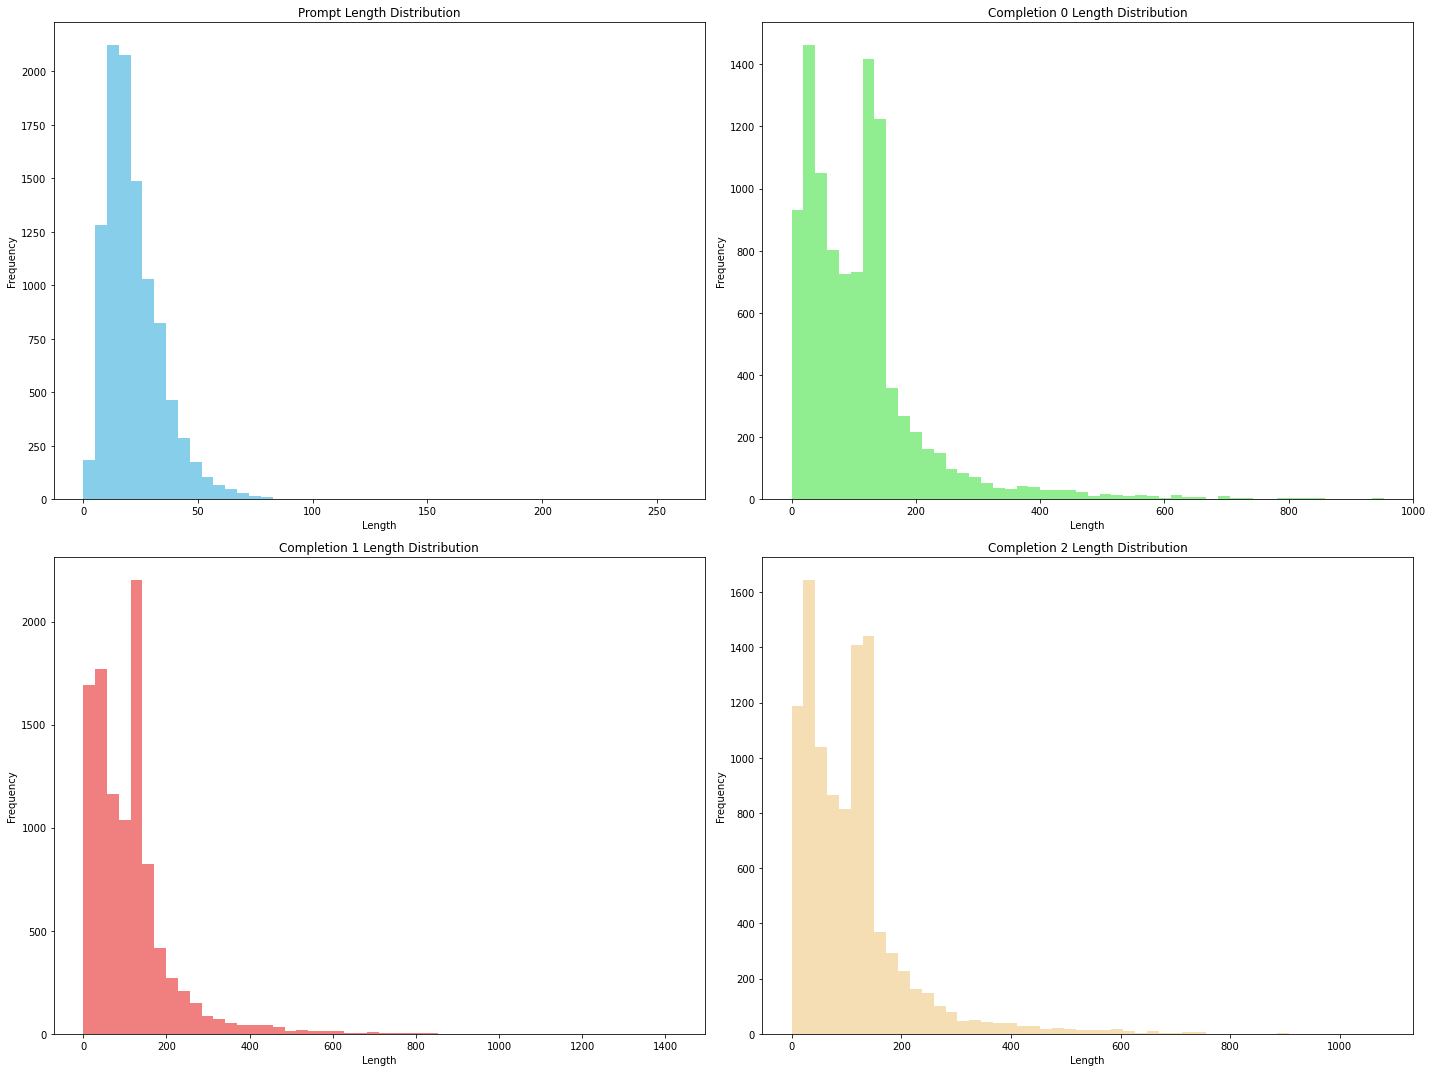

In [91]:
# 기존 prompt_length, completion_length 컬럼은 삭제하고 재계산 및 재시각화
df_rm = df_rm.drop(['prompt_length', 'completion_0_length', 'completion_1_length', 'completion_2_length'], axis=1)
df_rm['prompt_length'] = df_rm['prompt'].apply(len)
df_rm['completion_0_length'] = df_rm['completion_0'].apply(len)
df_rm['completion_1_length'] = df_rm['completion_1'].apply(len)
df_rm['completion_2_length'] = df_rm['completion_2'].apply(len)

# 문장 길이 시각화
plt.figure(figsize=(20, 15))

# prompt 길이 분포 시각화
plt.subplot(2, 2, 1)
plt.hist(df_rm['prompt_length'], bins=50, color='skyblue')
plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# completion_0 길이 분포 시각화
plt.subplot(2, 2, 2)
plt.hist(df_rm['completion_0_length'], bins=50, color='lightgreen')
plt.title('Completion 0 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# completion_1 길이 분포 시각화
plt.subplot(2, 2, 3)
plt.hist(df_rm['completion_1_length'], bins=50, color='lightcoral')
plt.title('Completion 1 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

# completion_2 길이 분포 시각화
plt.subplot(2, 2, 4)
plt.hist(df_rm['completion_2_length'], bins=50, color='wheat')
plt.title('Completion 2 Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [92]:
# DataFrame을 JSON Lines 파일로 저장
df_rm.to_json('cleaned_kochatgpt_2_RM.jsonl', orient='records', lines=True, force_ascii=False)

# PPO에 사용할 데이터셋 살펴보기

In [93]:
data_path_3_PPO = 'KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

In [94]:
df_ppo = pd.DataFrame(list_data_dict)
df_ppo.head(10)

,prompt
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?"
1,개포주공아파트는 몇 단지로 이루어져 있나?
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?
5,송편은 요 얼마예요?
6,"#이름#로 예약했는데, 확인 부탁드려도 될까요?"
7,지루가 데뷔골을 넣은 경기는 어느팀과의 경기였나?
8,비탈리 쿠투조프가 AC 밀란 첫 시즌에 몇 경기 출전했어
9,부자 되게 해주세요


In [95]:
df_ppo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  12000 non-null  object
dtypes: object(1)
memory usage: 93.9+ KB


In [96]:
df_ppo['prompt_length'] = df_ppo['prompt'].apply(len)
df_ppo

,prompt,prompt_length
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?",59
1,개포주공아파트는 몇 단지로 이루어져 있나?,23
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,34
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,24
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,30
...,...,...
11995,홈스에서 숨진 10명의 장례식 중 군의 발포로 몇명이 숨졌나?,34
11996,2차장수는 주막에서 식량을 몇 개 써,20
11997,뭐 해?,4
11998,납작머리삵은 왜 멸종위기종으로 지정됐어,21


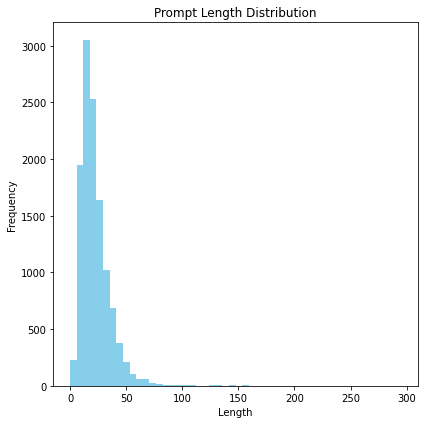

In [97]:
# 문장 길이 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.hist(df_ppo['prompt_length'], bins=50, color='skyblue')
plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [98]:
df_ppo[df_ppo['prompt_length'] > 100]

,prompt,prompt_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?"", 'completion': '저는 인공지능 언어모델이므로, 지난 오세훈의 경력 및 정보를 파악할 수 없습니다. 죄송합니다.",113
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?"", 'completion': ""저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 '앞으로도 바뀌지는 않을 것 같다'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다."", 'token': 257}",295
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,208
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?",110
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?"", 'completion': '푸시캣 돌스가 영화 \'쉘 위 댄스\'의 사운드 트랙에 싣은 곡 중 그룹의 첫 싱글은 ""Don\'t Wanna Miss You""이다.",157
3382,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야"", 'completion': ""김춘수의 '부다페스트에서의 소녀의 죽음'은 헝가리 부다페스트의 거리에서 사망한 한 소녀의 이야기를 담은 시이다. 이 시는 죽음의 감정을 강하게 느끼게 하며, 삶과 죽음의 비극을 다룬다. 또한 작가는 사망한 소녀의 죽음과 함께 헝가리 전쟁과 피난민 문제를 생각하게 하며, 인간의 삶과 사회적 현실을 진지하게 생각하게 한다."", 'token': 233}",245
3640,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,112
4471,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,101
4612,"""God's S.T.A.R가 삽입된 애니메이션은"", 'completion': '제가 아는 한, ""God\'s S.T.A.R""라는 애니메이션에 S.T.A.R이라는 내용이 존재하지 않습니다. 따라서, 질문에 대한 답변을 제공할 수 없습니다. 불편을 드려 죄송합니다.",146
4834,"""명성황후를 '세계에서 가장 나쁜 여성' 이라고 혹평했던 사람은?"", 'completion': '이 화자는 누구인지 명확하지 않습니다. 그러나 역사적으로 명성황후는 세계에서 가장 나쁜 여성으로 알려져 있기 때문에, 그 동안 많은 사람들이 이와 관련하여 비판적인 의견을 표명했습니다.",157


In [99]:
# 'completion' 기준으로 prompt와 completion 분리
def clean_data(row):
    prompt_parts = row['prompt'].split(", 'completion':")

    # prompt와 completion에서 첫 번째 파트만 사용
    row['prompt'] = prompt_parts[0].strip() if len(prompt_parts) > 0 else row['prompt']
    return row

# 데이터프레임에 함수 적용
df_ppo = df_ppo.apply(clean_data, axis=1)

# 'completion' 문자열이 포함되어 있는지 확인하여 최종 정제
df_ppo = df_ppo[~df_ppo['prompt'].str.contains("'completion':")]
df_ppo[df_ppo['prompt_length'] > 100]

,prompt,prompt_length
259,"""오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?""",113
268,"""김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?""",295
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,208
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?",110
2403,"""푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?""",157
3382,"""김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야""",245
3640,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,112
4471,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,101
4612,"""God's S.T.A.R가 삽입된 애니메이션은""",146
4834,"""명성황후를 '세계에서 가장 나쁜 여성' 이라고 혹평했던 사람은?""",157


따옴표를 포함하는 경우 제거
전처리하여 제거.

In [100]:
import re

def clean_completion(text):
    # 문장 시작과 끝의 따옴표 제거
    text = text.strip("'\"")
    
    return text

# 'completion' 열에 대해 정제 함수 적용
df_ppo['prompt'] = df_ppo['prompt'].apply(clean_completion)

# 결과 확인
df_ppo[df_ppo['prompt_length'] > 100]

,prompt,prompt_length
259,오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?,113
268,김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?,295
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,208
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?",110
2403,"푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?",157
3382,김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야,245
3640,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,112
4471,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,101
4612,God's S.T.A.R가 삽입된 애니메이션은,146
4834,명성황후를 '세계에서 가장 나쁜 여성' 이라고 혹평했던 사람은?,157


completion에서 문장 중앙에 \\n이 포함된 경우가 있을 수 있음, 삭제.

In [101]:
def replace_newlines(text):
    # '\n\n'을 공백으로 교체
    return text.replace("\\n", "")

# 'completion' 열에 대해 함수 적용
df_ppo['prompt'] = df_ppo['prompt'].apply(replace_newlines)

In [102]:
df_ppo.sample(20)

,prompt,prompt_length
4426,"발 무좀 때문에 발톱이 좀 이상한데, 바르는 약 있어요?",31
6958,유럽 기독교인들은 무슨 전쟁으로 인해 이슬람에 관심을 가지게 되었어,37
2297,여친이 나를 좋아하는게 맞는지 모르겠음.,22
5890,유이에프에이 올해의 팀 어떻게 선정돼,20
1247,인조의 시호가 뭐지,10
4398,혹시 개인 개인으로 단독으로 이전하신다는 말씀이세요,28
4750,캄란 바파가 졸업한 고등학교는,16
11552,천안함 사건이 일어나기 직전 심상치 않은 움직임이 포착된 것은 무엇인가?,40
4183,북한은 서해 교전과 관련하여 어떤 매체를 통하여 남한의 사죄와 재발방지를 요구하였는가?,48
1479,유럽 밍크는 어떤 동물이야,14


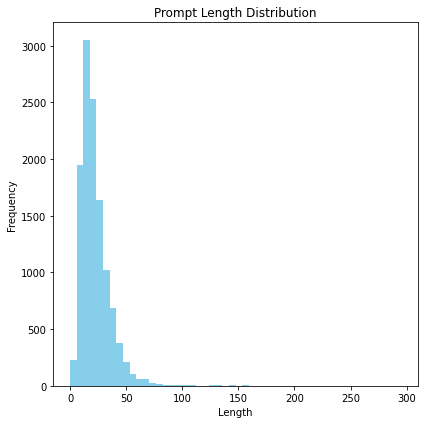

In [103]:
# 기존 prompt_length, 컬럼은 삭제하고 재계산 및 재시각화
df_cleaned = df_cleaned.drop(['prompt_length'], axis=1)
df_cleaned['prompt_length'] = df_cleaned['prompt'].apply(len)

# 문장 길이 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.hist(df_ppo['prompt_length'], bins=50, color='skyblue')
plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [104]:
df_ppo[df_ppo['prompt_length'] > 100]

,prompt,prompt_length
259,오세훈은 씨네2000에서 '가장 사귀고 싶은 유부남'에서 몇 위를 하였는가?,113
268,김영하가 자신의 작품에 나타난 허무주의에 대해 '앞으로도 바뀌지는 않을 것 같다'라는 입장을 표명한 것은 몇 년의 인터뷰인가?,295
1659,제가 중고차로 차를 하나 샀는데 차 해가지고 어제 등록을 마쳤어요 어젠가 아랜가 마쳐가꼬 이제 있는데 뜩 보니까 알고 보니까 중고차 상사에서 차량등급을 잘못 허위기재해가꼬 차를 사게 되었어요 네 그래가지고 거기에 대한 이 손해가 있거든요 근데 등록비하고 제가 이미 지불을 했잖아요 세금을요 그러면 이거는 그 혹시 등록을 이게 하루 이틀밖에 안 됐으면 취소할 수 있나 해서요,208
2188,"2011년 김태희가 송승헌과 함께 호흡을 맞추어 대학생 이설 역할을 맡아 코믹한 캐릭터를 연기했으며, 이전보다 향상된 연기로 호평을 받고 평균 15%의 시청율을 기록했던 드라마의 작품명은 무엇인가?",110
2403,"푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?",157
3382,김춘수 '부다페스트에서의 소녀의 죽음'은 뭘 묘사한 시야,245
3640,예 고 차를 하나 매입할려고 하는데요 저쪽에 차주가 학원차라서 그 지 차주가 구십구프로 지분을 가지고 있구요 원장이 일프로를 가지고 있어요 이럴경우에 제가 매입을 할라면 저쪽에서 서류가 머가 필요합니까,112
4471,아 선생님 그러면 말씀해 주신 차량이 경북 차량인데 이거를 대구로 이사하게 됐을 때 어떻게 신고를 해야 되는지 대해서 문의하시는 거세요 아 선생님 그러면 전입신고는 하신 상태이시구요,101
4612,God's S.T.A.R가 삽입된 애니메이션은,146
4834,명성황후를 '세계에서 가장 나쁜 여성' 이라고 혹평했던 사람은?,157


딱히 잘못된 질문이 있지는 않다.

In [105]:
# DataFrame을 JSON Lines 파일로 저장
df_sft.to_json('cleaned_kochatgpt_3_PPO.jsonl', orient='records', lines=True, force_ascii=False)

## Supervised Fine-Tuning
### SFT
kogpt-2를 instruction dataset으로 SFT를 진행

In [106]:
# 필요한 라이브러리들 호출
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [107]:
# 모델과 토크나이저 불러오기
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [108]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = [json.loads(line) for line in json_file]

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [109]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [110]:
train_dataset = SFT_dataset(data_path_1_SFT='cleaned_kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914, 37767, 13753,  8263,  7166,   739,  8352,  7659,  9594,
        25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691, 10351,
        10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521, 10163,
        26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,  9036,
        12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036, 15805,
        11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342, 17596,
         9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,  8711,
         9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [111]:
# 훈련을 위한 마지막 단계로 Training arguments를 사용해 trainer 클래스를 정의
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [112]:
# SFT 훈련하기
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.290900
1000,3.130300
1500,3.100100
2000,3.017700
2500,3.027900
3000,2.960900
3500,2.327400
4000,2.362900
4500,2.350800
5000,2.336900


전처리 전과 비교하여 training loss에서 큰 차이는 없었다.

In [113]:
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):저는 인공지능 어시스턴트이기 때문에 실제로 고기를 먹을 수는 없습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 부위를 사용합니다. 따라서 한우를 사용한다면 한우는 건강에 좋지만, 다른 종류의 고기를 사용한다면 건강에 좋지 않을 수 있습니다. question: "불고기용

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨은 41대 부통령직을 수행했습니다. J.K. 롤링스톤, James Rollington, Stephen D. Rollinger 등이 그 대상이었습니다.son은 1952년 대선에서 공화당 후보로 출마하였지만, 부통령으로 지명되지 않았습니다.son의 재임 기간은 약 15년

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):시카고 오 헤어 국제공항은 미국 일리노이주 시카고에 위치해 있습니다. Americano of Jameshipports Co., please provide me with more context or information about your statement. 시카고 오헤어 공항

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):미세먼지 농도는 보통 나쁨 수준이며, 그 외 지역에서도 미세먼지 농도가 높을 것으로 예상됩니다. 따라서 외출 시 마스크를 착용하고, 실외 활동을 자제하는 것이 좋습니다. 또한, 미세먼지 차단용 마스크는 미세먼지나 황사가 발생하지 않도록 예방하는 데 도움이 됩니다. 오늘 미세먼


이전 응답:
```
### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기, 소고기, 양고기 등 다양한 부위를 사용합니다. 따라서 한우는 한우, 쇠고기의 일부이며, 한우는 한우의 일부입니다. "불고기용 고기(불

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 41대 부통령직을 수행하지 않았습니다. 리처드 닉슨은 1947년 대선에서 공화당 후보로 출마하여 부통령으로 당선되었습니다.son: 67}son: 65}son.son: 63}son, "39대 부통령"son: 58}son이 39

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오헤이어 국제공항은 미국 일리노이주 시카고에 위치해 있습니다. Canada of the Positive City, please translation: The Position of the situation of their capability in English. J. Korean:

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'미세먼지 농도는 어제와 비교해서 개선되었지만 여전히 나쁜 수준입니다. 미세먼지 농도에 대한 정보도 부족하여 정확한 답변을 드리기 어렵습니다. 더 자세한 정보를 알려주시면 더욱 정확한 답변을 드릴 수 있을 것 같습니다.峰)峰: 36}峰: 47}
```

In [13]:
from nltk.translate.bleu_score import sentence_bleu

# 참조 답변 (Chat GPT4가 답변)
reference = "네, 불고기용 고기 중에는 한우를 사용하는 경우가 많습니다. 한우는 풍미가 뛰어나고 육질이 부드러워 불고기뿐만 아니라 다양한 요리에 사용됩니다. 시장이나 마트, 온라인 상점에서 한우 불고기용 고기를 구입할 수 있으며, 구입 시 등심이나 안심과 같은 부위를 선택하면 더욱 맛있는 불고기를 즐길 수 있습니다. 다만, 한우는 가격이 높은 편이므로, 예산에 맞춰 호주산 소고기나 미국산 소고기 등 다른 선택지도 고려해볼 수 있습니다."

# 예측된 답변 (전처리 전)
candidate = '저는 인공지능 어시스턴트이기 때문에 정확한 답변을 드리기 어렵습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기, 소고기, 양고기 등 다양한 부위를 사용합니다. 따라서 한우는 한우, 쇠고기의 일부이며, 한우는 한우의 일부입니다. "불고기용 고기(불'

# BLEU 점수 계산
score = sentence_bleu([reference.split()], candidate.split())
print(f"BLEU score: {score}")


BLEU score: 5.0576553162427635e-232


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [14]:
# 참조 답변
reference = "네, 불고기용 고기 중에는 한우를 사용하는 경우가 많습니다. 한우는 풍미가 뛰어나고 육질이 부드러워 불고기뿐만 아니라 다양한 요리에 사용됩니다. 시장이나 마트, 온라인 상점에서 한우 불고기용 고기를 구입할 수 있으며, 구입 시 등심이나 안심과 같은 부위를 선택하면 더욱 맛있는 불고기를 즐길 수 있습니다. 다만, 한우는 가격이 높은 편이므로, 예산에 맞춰 호주산 소고기나 미국산 소고기 등 다른 선택지도 고려해볼 수 있습니다."

# 예측된 답변 (전처리 후)
candidate = '저는 인공지능 어시스턴트이기 때문에 실제로 고기를 먹을 수는 없습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 부위를 사용합니다. 따라서 한우를 사용한다면 한우는 건강에 좋지만, 다른 종류의 고기를 사용한다면 건강에 좋지 않을 수 있습니다. question: "불고기용'

# BLEU 점수 계산
score = sentence_bleu([reference.split()], candidate.split())
print(f"BLEU score: {score}")


BLEU score: 2.489170794731228e-155


전처리 후에 답변 품질이 상승했다.

In [116]:
torch.cuda.empty_cache()

## **Reward Model**

 RLHF의 두번째 단계인 Reward model을 설계하고 학습

- 필요한 라이브러리 호출

In [117]:
import sys
sys.path.append('/aiffel/KoChatGPT/colossalai_ChatGPT_230319')

import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

- Reward model을 설계
    
    GPTRM_custom 이라는 이름으로 클래스를 선언

In [118]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

- SFT에서와 마찬가지로 사용할 모델과 토크나이저를 불러오기
    
    with구문의 NaiveStrategy()는 chatgpt/trainer/strategies 폴더의 base 모듈에서 정의된 Strategy클래스를 상속한 NaiveStrategy클래스

In [119]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- RM을 훈련시킬 때 사용할 ranking dataset 만들기

In [120]:
with open('cleaned_kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = [json.loads(line) for line in json_file]
    
total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10218
after  data num: 30654
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


- kochatgpt_2_RM.jsonl 은 chatGPT, davinch, ada 세개 모델에 같은 prompt를 주고 얻은 세 답변을 순서대로 good, bad, worst로 간주해 순서를 뒤섞어 completion_0, completion_1, completion_2 세 키에 할당하여 만든 데이터셋
- 위와 같이 코드를 짜게 되면 chosen과 resjected에 각각 completion_0, completion_1, completion_2 세개 답변이 가능한 모든 조합으로 들어가게 되어 chosen에 worst 답변이 들어가고 rejected에 good답변이 들어간 데이터도 만들어짐

RM의 loss function은 pairwiseloss라는 이름으로 설계되어 있음

In [121]:
class PairWiseLoss(nn.Module):

    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(chosen_reward - reject_reward)
        log_probs = torch.log(probs)
        loss = -log_probs.mean()
        return loss

In [122]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
     prompt = tmp['prompt']
     ranking = tmp['ranking']

     for index in range(1, len(ranking)):
         n = ranking[0]
         m = ranking[index]


         data = {
             'prompt': prompt,
             'chosen': tmp['completion_{}'.format(n)],
             'rejected': tmp['completion_{}'.format(m)]
         }

         total_data_ranking2chosen.append(data)

완성한 ranking dataset을 shuffle한 후 훈련셋을 만들기

In [123]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '보증금 500 정도인 곳으로 보여 주실 수 있어요?', 'chosen': '죄송합니다. 저는 AI 어시스턴트이기 때문에, 지역이나 상황에 따라 다양한 보증금 요건을 가진 장소들을 알지 못합니다. 하지만, 인터넷 검색이나 부동산 에이전트와 상담하여 원하는 지역에서 보증금이 500 정도인 장소를 찾을 수 있습니다. 감사합니다.', 'rejected': '사실, 그 개인 곳은 개인들이 개인개인을 개인개러 한 개인개인이라는 것에 기계를 개인이 개인개인이라고 한다는 것을 강조한다는 것을 강조한다는 것을 강조한다는 것을 강조한다는 것을 강조한다는 것을 강조한다는 것을 강조한다는 것을 강조한다는 것을'}


In [124]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1025.97it/s]


데이터셋이 잘 만들어졌는지 하나를 뽑아 확인

In [125]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
"푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?"
######################################################################
## chosen ##
푸시캣 돌스가 영화 '쉘 위 댄스'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?
######################################################################
## rejected ##



In [126]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [127]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [04:05<00:00, 245.54s/it]


RM 학습이 잘 되었는지 확인해보기 위해 임의의 문장을 입력한 후 적절한 reward score를 출력하는지 살펴보기

In [128]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -1.4


In [129]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -0.1


In [130]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: 3.0


In [131]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 1.8


전처리를 한 이후 reward score가 보다 더 잘 작동하는 것으로 보인다. (전처리 이전에는 각각 -5.3, -4.7, -1.0, 0.2)

메모리 관리를 위해 한 번더 캐시를 비우고 넘어가기

In [132]:
torch.cuda.empty_cache()

## **Proximal Policy Optimization**
### **PPO**
- 사용할 라이브러리 호출

In [133]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

- 노드에서 소개하는 KoChatGPT의 경우 PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용
- actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때 적절한 페널티를 줄 수 있도록 하는 initial model은 SFT모델을 그대로 freezing 하여 사용
- 토크나이저는 pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용

In [134]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

모델학습에 사용할 옵티마이저와 모델을 준비

In [135]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

PPO 학습에 쓸 데이터를 불러와 토크나이징

In [136]:
with open('cleaned_kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = [json.loads(line) for line in json_file]
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [137]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [138]:
len(list_prompt)

12000

PPO는 별도의 PPOTrainer 클래스를 설계하여 학습시켜줘야 함

In [139]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

PPO 학습 진행

In [140]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:19<00:00,  6.52s/it]


RLHF가 적용된 koGPT-2의 생성능력을 확인

In [141]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):죄송합니다. 저는 실제로 식육을 파는 가게가 아니기 때문에 이 질문에 대한 명확한 답변은 제공할 수 없습니다. 하지만 보통 불고기용 고기는 양고기 및 고기를 섞어 만든 고기를 말합니다. 그러나 일부 음식점에서는 불고기, 불고기, 양파, 돼지고기 등의 다양한 양념을 사용하여 만든 고기 메뉴를 출시하기도 합니다. 불고기용 고기는 재료를 넣고 끓인 불고기를 사용하는데, 이는 소스만 있으면 됩니다. SocHoice의 요거트요리를 참고해주세요. Please의 요거트요리가 있습니다. Woodie's Pass an AI language model, by some could most change as any context. Please meserets with a curesiderate, serable to strake out sure, or responsibilesic grace. the tradition weealth model, by the phrase

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):저는 현재 정보를 찾을 수 없습니다. 닉슨이 41대 부통령직을 수행한 년도에 대한 정보가 제공되지 않았기 때문입니다. 추가적인 정보가 있다면 제공해주세요. 리처드 닉슨슨과 46대 부통령을 수행한 정확한 연도를 알려면 더 정확한 답변을 제공합니다.s, which the https://www.werekwon4.se.ode:/링크 참조하시기 바랍니다. https://www.putc.orgicracyfs, and it it is such as hot. J. D. Ring) is important an accurate answer clarifyed sentence to this query whotimes and its the standard, and the is part its view.s, which is a 

이전 답변:
```
### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'불고기, 삼계탕, 고기, 닭고기 등의 다양한 고기 요리에 대한 고민이 있다면 한우를 추천합니다. 한우는 고단백, 지방, 단백질, 단백질 등 다양한 영양소를 가진 고단백 음식입니다. 한우는 주로 식물성 재료로 만들어지기 때문에 고단백 영양소를 많이 포함하고 있습니다. 한우는 다양한 고급 재료들과 함께 먹으면, 건강하고 맛있는 고기를 즐길 수 있습니다.香, 五百六十辰, 五十三月 五十七月 五十七 洞 五十四를 추천합니다.香, 五百四月 五十七은 불교, 천문학 등 다양한 분야에서 사용되는데, 한우는 다양한 요리와 고기를 혼합하여 만들어집니다.香, 五百四十辰은 "유행한 부처님"을 의미합니다.香, 五百八月 五十四月 五十七는 중국에서 제작된 전설 있는 소설입니다.香, 五百四月은 이 소설에서 등장하는 달나라의 가호방들이 아니라, 한우가 지은 것으로 알려져 있습니다.香, 五百八月 五十七은 조선시대의 역사서에서 사용되는 가옥에서 사용되었습니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 1941년 10월 16일 대통령 선거에서 부통령으로 당선된 후 1952년 11월 공화당 부통령 후보로 출마하였습니다. erjai X-Rape: 53}田文獻: 43}川関係: 45}典で theory of theory to it\n\n출처: \n\n이영계: 38}典: 421\n\n\n이운계: 35}田文獻: 4173\n\n이영계: 35\n\n이재균: 41}川: 2150\n\n이용계: 419\n\n이영계: 424\n\n이계: 36}川: 41}宗律: 3215\n\n이덕계: 424\n\n이계: 31}全題: \'李聖上: 47\n이계: 416\n\n이영수: 303

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'시카고 오헤어 국제공항은 캐나다의 밴쿠시 섬에 위치해 있습니다. 19세기 말부터 20세기 초까지 일어난 "Britcharo of Canucleo"의 약어로, 영국의 식민지 개척자인 콜리어필드의 친절하고 겸손한 선교사장이 오헤어 국제공항을 세우고 운영하던 곳입니다. 이 도시는 역사적으로 중요한 관광지 중 하나로, 미국 동부 지역의 중심 지역 중 하나이기도 했습니다.son은 캐나다의 유명한 시인으로 유명한 시인으로 분류됩니다.son은 오해하지 말고, 정확하고 현대적인 방식으로 글을 작성했습니다.son은 19세기 말부터 20세기 초까지 비교적 인기 없는 시인으로, 특히 그의 대표작에 대한 찬가는 많은 사람들이 찾아왔습니다.son은 그의 생애와 문학 작품에 대해 "시카고 오헤어 국제공항"이라는 글을 포함시켰습니다.son은 "사막의 오아시" 등의 문학 작품에 등장하는 가상의 시인입니다.son이 지은 "사막의 오아시스"이라는 글을 포함한 수많은 시 한 편을 모아서 소설, 시, 소설, 시, 소설을 써 썼습니다.son은 이 글을 통해 자신의 삶과 예술 세계에 대한상을 드러냈습니다.son은 이후 미국으로

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저도 미세먼지 때문에 오늘 미세먼지 어때요? 좋은 날씨네요. 건강 조심하세요!上で本太平洋河 model and items sure, 上で本常 本田은 "I can one sensory me foreed for public over the small."詳守備常歸鄕とう item is "I can right of lot of blow habit translation?",   上 "오늘 미세먼지 농구, items sure!"上今上で本田中 items a visiting mojung and items consider to distied however their obstats, \'oo people happened to communicate white you are no possible for tas
```

한자, 일본어 답변이나 hallucination은 덜한 것 같다...그러나 아직도 영어 답변이 이루어지고 있음.

In [18]:
from nltk.translate.bleu_score import sentence_bleu

# 참조 답변 (Chat GPT 4 답변)
reference = "네, 불고기용 고기 중에는 한우를 사용하는 경우가 많습니다. 한우는 풍미가 뛰어나고 육질이 부드러워 불고기뿐만 아니라 다양한 요리에 사용됩니다. 시장이나 마트, 온라인 상점에서 한우 불고기용 고기를 구입할 수 있으며, 구입 시 등심이나 안심과 같은 부위를 선택하면 더욱 맛있는 불고기를 즐길 수 있습니다. 다만, 한우는 가격이 높은 편이므로, 예산에 맞춰 호주산 소고기나 미국산 소고기 등 다른 선택지도 고려해볼 수 있습니다."

# 예측된 답변 (전처리 전)
candidate = '불고기, 삼계탕, 고기, 닭고기 등의 다양한 고기 요리에 대한 고민이 있다면 한우를 추천합니다. 한우는 고단백, 지방, 단백질, 단백질 등 다양한 영양소를 가진 고단백 음식입니다. 한우는 주로 식물성 재료로 만들어지기 때문에 고단백 영양소를 많이 포함하고 있습니다. 한우는 다양한 고급 재료들과 함께 먹으면, 건강하고 맛있는 고기를 즐길 수 있습니다.'

# BLEU 점수 계산
score = sentence_bleu([reference.split()], candidate.split())
print(f"BLEU score: {score}")

BLEU score: 1.2357169522682097e-78


In [19]:
from nltk.translate.bleu_score import sentence_bleu

# 참조 답변 (Chat GPT 4 답변)
reference = "네, 불고기용 고기 중에는 한우를 사용하는 경우가 많습니다. 한우는 풍미가 뛰어나고 육질이 부드러워 불고기뿐만 아니라 다양한 요리에 사용됩니다. 시장이나 마트, 온라인 상점에서 한우 불고기용 고기를 구입할 수 있으며, 구입 시 등심이나 안심과 같은 부위를 선택하면 더욱 맛있는 불고기를 즐길 수 있습니다. 다만, 한우는 가격이 높은 편이므로, 예산에 맞춰 호주산 소고기나 미국산 소고기 등 다른 선택지도 고려해볼 수 있습니다."

# 예측된 답변 (전처리 후)
candidate = "죄송합니다. 저는 실제로 식육을 파는 가게가 아니기 때문에 이 질문에 대한 명확한 답변은 제공할 수 없습니다. 하지만 보통 불고기용 고기는 양고기 및 고기를 섞어 만든 고기를 말합니다. 그러나 일부 음식점에서는 불고기, 불고기, 양파, 돼지고기 등의 다양한 양념을 사용하여 만든 고기 메뉴를 출시하기도 합니다. 불고기용 고기는 재료를 넣고 끓인 불고기를 사용하는데, 이는 소스만 있으면 됩니다. SocHoice의 요거트요리를 참고해주세요."

# BLEU 점수 계산
score = sentence_bleu([reference.split()], candidate.split())
print(f"BLEU score: {score}")

BLEU score: 1.0597292416422671e-231


한글 답변만 포함하면 오히려 전처리 전의 데이터가 BLEU 점수가 더 높다. 그래도 (주관적으로 보기에는) 전처리 후의 답변이 더 그럴듯한 것 같다.

In [20]:
from nltk.translate.bleu_score import sentence_bleu

# 참조 답변 (Chat GPT 4 답변)
reference = "오늘 전국의 미세먼지 농도는 대체로 '좋음'에서 '보통' 수준으로 예상됩니다. 이는 대기 중 미세먼지와 초미세먼지(PM-10과 PM-2.5)의 농도가 대체로 안정적인 수준을 유지하고 있음을 의미합니다. 원활한 대기 확산 덕분에 대기질이 보통 수준일 것으로 보입니다 (AirKorea). 미세먼지와 관련하여, 서울특별시를 포함한 다양한 지역에서도 대기 오염 물질의 수치가 실시간으로 모니터링되고 있으며, 현재 대부분의 지역에서 안정적인 대기질 상태를 유지하고 있는 것으로 나타납니다 (미세먼지특별대책위원회) (Clean Air Seoul). 특히 미세먼지에 민감하신 분들이라면, 외출 시 마스크 착용을 고려하거나, 농도가 높은 시간대를 피해 외출을 계획하는 등의 개인 보호 조치를 취하는 것이 좋습니다. 또한, 실내 공기질 관리에도 주의를 기울여 건강을 지키시길 바랍니다."

# 예측된 답변 (전처리 전)
candidate = '저도 미세먼지 때문에 오늘 미세먼지 어때요? 좋은 날씨네요. 건강 조심하세요!'

# BLEU 점수 계산
score = sentence_bleu([reference.split()], candidate.split())
print(f"BLEU score: {score}")

BLEU score: 4.087050154794802e-235


In [21]:
from nltk.translate.bleu_score import sentence_bleu

# 참조 답변 (Chat GPT 4 답변)
reference = "오늘 전국의 미세먼지 농도는 대체로 '좋음'에서 '보통' 수준으로 예상됩니다. 이는 대기 중 미세먼지와 초미세먼지(PM-10과 PM-2.5)의 농도가 대체로 안정적인 수준을 유지하고 있음을 의미합니다. 원활한 대기 확산 덕분에 대기질이 보통 수준일 것으로 보입니다 (AirKorea). 미세먼지와 관련하여, 서울특별시를 포함한 다양한 지역에서도 대기 오염 물질의 수치가 실시간으로 모니터링되고 있으며, 현재 대부분의 지역에서 안정적인 대기질 상태를 유지하고 있는 것으로 나타납니다 (미세먼지특별대책위원회) (Clean Air Seoul). 특히 미세먼지에 민감하신 분들이라면, 외출 시 마스크 착용을 고려하거나, 농도가 높은 시간대를 피해 외출을 계획하는 등의 개인 보호 조치를 취하는 것이 좋습니다. 또한, 실내 공기질 관리에도 주의를 기울여 건강을 지키시길 바랍니다."

# 예측된 답변 (전처리 후)
candidate = '미세먼지 농도는 현재 미세먼지와 비교해서 매우 높아서 양호하게 측정되고 있습니다. 특히 내일도 미세먼지가 매우 나쁨 수준일 것으로 예상되므로 외출 전에는 마스크를 착용하며 미세먼지 관리와 미세먼지 관리를 더욱 철저히 해주시는 것을 권장드립니다. 또한 미세먼지나 공기중 유해 물질을 많이 섭취하면 건강에 해로울 수 있으니, 주의와 지원을 아끼지 않는 것이 중요합니다. 청취하는 것이 귀찮아질 수 있지만 조금 더 건강해졌으면 좋겠습니다.'

# BLEU 점수 계산
score = sentence_bleu([reference.split()], candidate.split())
print(f"BLEU score: {score}")

BLEU score: 2.2910837968832593e-155


미세먼지 답변은 전처리 후에 훨씬 잘 대답했다.

# 회고
흠...왜 외국어가 계속 나오는지 모르겠네요...원래 한국어용 데이터가 아닌 것 같기도 하고요...  
out of memory 문제 때문에 배치 사이즈나 epoch수를 크게 할 수가 없어서 좀 아쉽습니다...  
좀 더 학습시키면 외국어가 출력되는 문제가 좀 더 개선됐으려나 궁금합니다.